# Segmentation of PanNuke Dataset

# 1. Import Required Libraries & Dataset Download

#### Importing Libraries

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from tqdm import tqdm
import os
import random
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchinfo import summary
import cv2
import pickle
import urllib.request
import zipfile
from pathlib import Path
from scipy import stats
from PIL import Image

#### Utility Functions

In [4]:
from PIL import Image
import matplotlib.pyplot as plt

def display_image(image_path, figsize=(10, 8)):
    """
    Display an image with correct aspect ratio and white background.
    
    Args:
        image_path: Path to the image file
        figsize: Tuple of (width, height) in inches for display size
    """
    # Load the image
    img = Image.open(image_path)
    
    # Create figure with white background and specified size
    plt.figure(figsize=figsize, facecolor='white')
    
    # Set plot area background to white
    plt.gca().set_facecolor('white')
    
    # Display the image (aspect ratio is automatically preserved)
    plt.imshow(img)
    
    # Hide axes
    plt.axis('off')
    
    # Show the plot
    plt.show()

This code block defines two essential helper functions, download_file and extract_zip, which form the core utility for programmatically acquiring and unpacking remote data, such as the PanNuke dataset folds. The download_file function handles the fetching of a file from a given URL to a local destination using urllib.request.urlretrieve and implements basic error handling to gracefully manage network or permission issues. Following a successful download, the extract_zip function takes the local zip archive, opens it in read mode ('r'), and extracts all its contents into a specified target directory using the zipfile module. Both functions are designed to return a boolean value (True for success, False for failure) and include print statements for tracking the file operation status, enabling robust management of large data files outside the primary application logic.

In [ ]:

def download_file(url, dest_path):

    """
    Download a file from the given URL to the specified destination path,
    including progress reporting.

    Args:
        url (str): The source URL of the file to download.
        dest_path (Path): The local path where the file should be saved.

    Returns:
        bool: True on successful download, False otherwise.
    """

    print(f"Downloading {url}...")

    # Use urllib.request to retrieve the file from the URL and save it locally.
    try:
        urllib.request.urlretrieve(url, dest_path)
        print(f"Downloaded to {dest_path}")
        return True

    # Catch any potential errors during the download process (e.g., network issues)
    except Exception as e:
        print(f"Error downloading {url}: {e}")
        return False

def extract_zip(zip_path, extract_to):

    """
    Extracts the contents of a zip file to a target directory.

    Args:
        zip_path (Path): The path to the local zip file.
        extract_to (Path): The directory path where contents should be extracted.

    Returns:
        bool: True on successful extraction, False otherwise.
    """

    print(f"Extracting {zip_path}...")

    # Open the zip file in read mode and extract all files within the zip
    # archive to the target directory.
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        print(f"Extracted to {extract_to}")
        return True

    # Catch any potential errors during the extraction process (e.g., corrupt zip)
    except Exception as e:
        print(f"Error extracting {zip_path}: {e}")
        return False


#### Downloading Dataset

This block of code executes the necessary steps to programmatically download, extract, and organize the PanNuke dataset into the required local directory structure. It begins by setting up the root data directory and defining the base URL and list of dataset folds to be processed. The core logic resides in a for loop that iterates through each fold, dynamically constructing the URL and local paths for that fold's zip archive. Inside the loop, it sequentially attempts to download the zip file using a helper function (download_file), and if successful, attempts to extract the contents into a fold-specific folder using extract_zip. Finally, the code ensures local disk cleanup by removing the temporary .zip file after successful extraction and calculates the final data size for verification, completing the setup process for each individual dataset fold.

In [ ]:
# Create a Path object pointing to the root data directory named "data"
# Create the data directory if it does not already exist.
# The 'exist_ok=True' argument prevents an error if the directory already exists.
data_dir = Path("data")
data_dir.mkdir(exist_ok=True)

# Base URL for the PanNuke dataset archives. The fold number will be appended.
base_url = "https://warwick.ac.uk/fac/cross_fac/tia/data/pannuke/fold_"

# Define the list of dataset folds (partitions) to download and process.
folds = [1, 2, 3]


# Iterate through each defined fold index (1, 2, 3).
for fold in folds:

    # Define the target directory path for the current fold (e.g., data/fold1).
    # and create the fold-specific subdirectory.
    fold_dir = data_dir / f"fold{fold}"
    fold_dir.mkdir(exist_ok=True)

    # Construct the complete download URL for the fold's zip file and define the
    # local path where the zip file will be temporarily saved (e.g., data/fold1.zip).
    fold_url = f"{base_url}{fold}.zip"
    zip_path = data_dir / f"fold{fold}.zip"

    #  Download the zip file using the helper function.
    if download_file(fold_url, zip_path):

        # If download succeeded, extract the zip file contents to the fold's directory.
        if extract_zip(zip_path, fold_dir):

            # Clean up the temporary zip file to save disk space and compute
            # the total size of the extracted data for verification (optional).
            # The expression Path(f"data/fold{fold}").rglob('*') performs a recursive, pattern-matching search
            os.remove(zip_path)
            size = sum(f.stat().st_size for f in Path(f"data/fold{fold}").rglob('*') if f.is_file())

            # Print the total size in Gigabytes (GB).
            # Print confirmation that the current fold setup is complete.
            print(f"Fold {fold}: {size / (1024**3):.2f} GB")
            print(f"Fold {fold} setup complete!\n")

        # If extraction failed, skip the cleanup and move to the next fold.
        else:
            print(f"Skipping fold {fold} due to extraction error\n")

    # If download failed, skip the extraction/cleanup and move to the next fold.
    else:
        print(f"Skipping fold {fold} due to download error\n")

# 2. Configuration

#### Global Configuration Dictionary

This Python dictionary named config serves as the centralized hyperparameter configuration object for a TransUNet segmentation model applied to the PanNuke dataset. It meticulously segregates parameters into distinct domains: Model Architecture, Segmentation, Dataset Paths, and Training Control. The architecture parameters define the core Vision Transformer (ViT) Encoder—specifying the input image_size (256), patch_size (16), hidden_size (512), and the number of layers (7) and attention heads (4)—along with the channel dimensions for the initial convolutional PatchEmbeddings and the subsequent U-Net-style decoder_channels. Crucially, it sets the num_classes to 6 for the 5 nuclei types plus background. Finally, the configuration manages the training environment by setting data splits (train_fold, val_fold), optimizing training stability with a fixed seed (1234), and controlling the optimization process through batch_size, learning_rate, and early stopping via the patient value.

In [ ]:
config = {

    # The spatial dimension (H×W) to which input images are resized (256×256).
    "image_size": 256,

    # The size of the non-overlapping square patches used to tokenize the input image
    # before feeding it into the Transformer encoder (e.g., 16x16 pixels).
    "patch_size": 16,

    # Number of color channels in the input image (3 for RGB).
    "num_channels": 3,

    # Dimensionality of the embedding space and the hidden state of the Transformer.
    "hidden_size": 512,

    # Number of parallel attention heads in the Multi-Head Attention mechanism.
    "num_attention_heads": 4,

    # Number of stacked Transformer encoder layers.
    "num_hidden_layers": 7,

    # The size of the hidden layer within the two-layer Feed-Forward Network
    # (FFN) in the MLP class.
    "intermediate_size": 1024,

    # Dropout probability applied to the hidden layers (e.g., outputs of the FFN).
    "hidden_dropout_prob": 0.1,

    # Dropout probability applied to the attention weights (e.g., within MHA scores).
    "attention_probs_dropout_prob": 0.1,

    # The output channel dimensions for the sequential convolutional layers within the PatchEmbeddings
    "embedding_channels": [64, 128, 256],

    # Total number of classes for segmentation: 5 nuclei types + 1 background class.
    "num_classes": 6,

    # The sequence of channel dimensions used for the upsampling stages in the Decoder class of TransUNet
    "decoder_channels": [256, 128, 64],

    # List of channel sizes for the standard convolution blocks used in ResNetUNet
    "conv_channels": [64, 128, 256, 512],

    # Base directory where the downloaded PanNuke dataset folds are located.
    "root_dir": "./data",

    # Specifies which dataset fold (1, 2, or 3) will be used for training.
    "train_fold": 1,

    # Specifies which dataset fold will be used for validation during training.
    "val_fold": 2,

    # Specifies which dataset fold will be reserved for final, unbiased testing.
    "test_fold": 3,

    # Number of samples processed in one forward/backward pass.
    "batch_size": 32,

    # Total number of training cycles over the entire dataset.
    "num_epochs": 100,

    # The rate at which model weights are adjusted during training (optimizer parameter).
    "learning_rate": 0.01,

    # fraction of the prev update to add to the current one using SGD optimizer
    "momentum": 0.9,

    # Patience value for early stopping: the number of epochs to wait for improvement
    # before stopping training (e.g., stopping after 10 epochs with no validation improvement).
    "patient": 10,

    # Master seed value used to initialize all random number generators for reproducibility.
    "seed": 1234

}

#### Seed Settings

This code block is dedicated to establishing reproducibility and configuring the hardware device for the entire deep learning experiment. The core component is the set_seed function, which systematically initializes the random number generators across all relevant frameworks: Python's built-in random, the numerical library numpy, and PyTorch's CPU and GPU (torch.cuda.manual_seed) environments. By calling torch.backends.cudnn.deterministic = True, the function further guarantees that operations on CUDA (like convolutions) will produce the exact same results every time, overriding potential performance optimizations for consistency. Finally, the code determines the device for computation, intelligently selecting the high-performance 'cuda' (GPU) if available on the system, otherwise defaulting to the 'cpu'.

In [ ]:
import torch
import random
import numpy as np


def set_seed(seed):
    """
    Sets global random seeds for Python, NumPy, and PyTorch (CPU and CUDA)
    to ensure that experiments are reproducible across runs.

    Args:
        seed (int): The integer seed value from the configuration dictionary.
    """
    # Seed Python's built-in random module
    random.seed(seed)

    # Seed NumPy's random number generator (often used in data preprocessing/augmentation)
    np.random.seed(seed)

    # Seed PyTorch's CPU random number generator
    torch.manual_seed(seed)

    # Seed PyTorch's GPU (CUDA) random number generator
    torch.cuda.manual_seed(seed)

    # Ensure all CUDA convolution operations are deterministic (may slightly impact performance)
    torch.backends.cudnn.deterministic = True

# Apply the master seed defined in the configuration dictionary.
set_seed(config["seed"])

# Define the device for computation: 'cuda' (GPU) if available, otherwise 'cpu'.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Dataset and DataLoader


#### Dataset Class


This detailed code defines the PanNukeDataset class, which serves as the data backbone for loading and preparing images and segmentation masks from the PanNuke dataset for a deep learning model.
The design emphasizes efficient memory use, correct data transformations, and adherence to PyTorch's Dataset conventions.

The PanNukeDataset is a specialized implementation of PyTorch's Dataset abstract class.
The objective is to prepare data for nuclei segmentation, where the input is an image and the target is a mask identifying different types of nuclei and the background. Memory-Mapping (mmap_mode='r') is the most crucial technical detail. Since the PanNuke dataset files (images.npy, masks.npy) are extremely large, loading them entirely into RAM would quickly exhaust system memory. By using mmap_mode='r' when calling numpy.load, the code avoids loading the entire arrays into physical RAM at once. Instead, the operating system maps the disk file into the application's memory space, and data is only physically read into RAM as needed when a specific index (idx) is accessed in getitem. This is an essential memory offloading strategy.

The initialization method establishes the necessary file paths and sets up the primary data handles. File Path Construction: It dynamically builds file paths using f-strings and os.path.join based on the provided root_dir and the target fold number. This structure allows the class to easily switch between different dataset splits (folds 1, 2, or 3). Data Structure: It loads self.images (shape NxHxWx3, original images) and self.masks (shape NxHxWx6, one-hot masks) as read-only memory-mapped objects.

The len method simply returns the length of the loaded self.images array (the first dimension, N), which represents the total number of samples in the current dataset split (fold).

The getitem method contains all the preprocessing logic for a single sample and is executed once per sample when the DataLoader requests data. Data Copying: The code uses .copy() when extracting image and mask from the memory-mapped arrays (self.images[idx].copy()). It is often necessary and good practice. While mmap_mode='r' prevents direct modification of the mapped file, .copy() ensures that subsequent operations (like scaling and transformations) modify a private copy of the data in RAM, preventing potential, unexpected interactions with the kernel's memory pages or issues if the transformation library tries to perform in-place operations. We have a One-Hot to Class Map Conversion in which the 6-channel one-hot mask is converted to a single-channel mask using np.argmax(mask, axis=2). The output is an HxW array with integer class values in the range 0 to 5. We perform background remapping by applying the remap array: 0=>1,…,5=>0. The background class is deliberately moved to 0. As noted in the comments, this is required because geometric data augmentation operations (like rotation) often fill new boundary pixels with a default value of zero. By setting background to 0, these padded pixels are correctly interpreted as background, avoiding incorrect labeling as the original Class 0 (which would be a nuclei type). We perform Image Normalization: The image values are normalized from the range 0 to 255 to the floating-point range 0 to 1 and converted to np.float32 precision. This reduces the data's memory footprint (from the default 64-bit float to 32-bit) and is standard practice for deep learning inputs. In the final Transformation the image and mask are passed through the external self.transform pipeline (e.g., Albumentations' A.Compose object), converting them from NumPy HxWxC format to PyTorch CxHxW tensors

In [ ]:

class PanNukeDataset(Dataset):

    """
    A custom PyTorch Dataset class for loading the PanNuke nuclei segmentation dataset.

    It efficiently loads image and mask data for a specific fold using memory-mapping
    (mmap_mode='r') to conserve RAM.

    The dataset performs initial preprocessing steps, including converting one-hot
    masks to class labels and remapping the background class to 0 for compatibility
    with images trasnformations [image rotation]

    Attributes:
        images_path (str): Path to the NPY file containing all images for the fold.
        masks_path (str): Path to the NPY file containing all masks for the fold.
        types_path (str): Path to the NPY file containing all mask types for the fold.
        images (numpy.ndarray): Memory-mapped array of images (N x H x W x 3).
        masks (numpy.ndarray): Memory-mapped array of masks (N x H x W x 6).
        transform (callable): The image/mask transformation pipeline (e.g., Albumentations).
    """

    def __init__(self, root_dir, fold, transform):

        """
        Initializes the PanNukeDataset for a specific fold.

        The .npy data arrays are loaded using memory-mapping ('r') to avoid
        consuming large amounts of RAM by loading all data into memory at once.

        Args:
            root_dir (str): Path to the main dataset directory.
            fold (int): The fold number to load data from (1, 2, or 3).
            transform (callable): Optional transform function to apply to samples.
        """

        # Building the paths to .npy files containing the the actual images,
        # the masks and the type of these masks
        # The paths are building by appending to the root directory path the
        # name of the file which depends on the fold we want and, obviously,
        # on the type of file we are looking for (i.e. image, mask or type)
        self.images_path = os.path.join(root_dir, f"Fold {fold}", "images", f"fold{fold}", "images.npy")
        self.masks_path = os.path.join(root_dir, f"Fold {fold}", "masks", f"fold{fold}", "masks.npy")

        # Using memory-mapped loading (keep the array on disk and we load into
        # RAM only on demande), this is done to avoid loading entire arrays into
        # RAM at once when accessing numpy matrix [r stands for reading only]
        self.images = np.load(self.images_path, mmap_mode='r')  # N x W x H x 3
        self.masks = np.load(self.masks_path, mmap_mode='r')    # N x W x H x 6 (one-hot)

        # This is the transformation that will be applied to images and masks
        self.transform = transform

    def __len__(self):

        """
        Returns the total number of samples in the dataset.

        Returns:
            int: The size of the dataset (N).
        """

        # The length of the dataset depends on the first dimension of
        # images as it is a N x H x W tensor
        return len(self.images)

    def __getitem__(self, idx):

        """
        Retrieves and preprocesses the image and corresponding mask at the given index.

        The method performs one-hot decoding (channels dimension collapsing), label
        remapping (background=0), and normalization before applying transforms.

        Args:
            idx (int): The index of the sample to retrieve.

        Returns:
            dict: A dictionary containing the preprocessed 'image' (C x H x W tensor)
                  and the segmentation 'label' (H x W tensor of integer classes).
        """

        # Extracting images and labels as well as copying them, in order to
        # avoid corrupting the original images and mask arrays
        image = self.images[idx].copy() # H x W np matrix with values in [0, 255]
        mask = self.masks[idx].copy()   # H x W x 6 np matrix with one-hot channels

        # Convert one-hot mask to single-channel class map
        # PanNuke ordering: channels 0..4 = nuclei classes, 5 = background
        # mask is a H x W numpy matrix whose entries have values in [0..5]
        mask = np.argmax(mask, axis=2) # H x W x 6 (one-hot) -> H x W ({0,..,5})

        # Remapping labels so that background becomes 0 and not 5
        # 0->1, 1->2, 2->3, 3->4, 4->5, 5->0
        # In many CV contexts 0 label denote background or no information and
        # therefore many data augmentation libraries when applying rotation and
        # introducing new pixels set the labels of those pixels to zero
        remap = np.array([1, 2, 3, 4, 5, 0])
        mask = remap[mask]

        # Normalizing image pixels from [0, 255] to [0, 1] and then reducing
        # floating point precision from 64 bits to 32 bits
        image = (image / 255).astype(np.float32)

        # Applying a transformation to both the image and the mask, the
        # transformation is a parameter of the class but it should turn the
        # numpy matrix H x W x C into a pytorch tensor C x H x W
        transformed = self.transform(image=image, mask=mask)
        image = transformed["image"]
        mask = transformed["mask"]

        return {'image': image, 'label': mask}

#### Transformations



We define two distinct data preprocessing and augmentation pipelines, train_transform and val_transform, using the Albumentations library to prepare image and mask pairs for a segmentation model. The primary goal is to establish a robust and varied data flow for training while ensuring a consistent, deterministic process for evaluation. The train_transform pipeline incorporates several stochastic (random) augmentations, such as rotation (A.Rotate up to 360 with p=0.8), horizontal, and vertical flips (both p=0.5), to artificially increase the size and diversity of the training data, thereby helping the model generalize better and reduce overfitting. In contrast, the val_transform pipeline is purely deterministic, consisting only of the necessary A.Resize operation to unify input dimensions. Both pipelines conclude with ToTensorV2, which converts the data into PyTorch tensors and correctly reorders the dimensions from the image format (Height x Width x Channel) to the PyTorch standard (Channel x Height x Width), using nearest-neighbor interpolation for masks in all resizing and rotation steps to correctly preserve the discrete, integer class labels.


In [ ]:

# This pipeline applies a sequence of geometric and tensor conversions,
# designed to artificially increase the diversity of the training dataset,
# which helps the model generalize better
train_transform = A.Compose([

    # The first step is a rotation
    A.Rotate(
        # Randomly rotates the image and mask by up to 360 degrees with an 80% probability
        limit=360, p=0.8,

        # Specifies how pixels outside the boundaries are filled after rotation
        # they are filled with a constant color (which is typically black/zero)
        border_mode=cv2.BORDER_CONSTANT,

        # Uses bilinear interpolation for continuous image pixel values. which
        # computes the weighted average of its 4 nearest pixels
        interpolation=cv2.INTER_LINEAR,

        # Uses nearest-neighbor interpolation for the mask, which is crucial to
        # preserve the integer class labels
        mask_interpolation=cv2.INTER_NEAREST
    ),

    # Flips the image and mask horizontally with a 50% probability
    A.HorizontalFlip(p=0.5),

    # Flips the image and mask vertically with a 50% probability.
    A.VerticalFlip(p=0.5),

    # Resizes both the image and mask to a fixed square dimension before
    # feeding them into the model
    A.Resize(

        # Size of the image to be fed to the model
        config["image_size"], config["image_size"],

        # Uses bilinear interpolation for continuous image pixel values. which
        # computes the weighted average of its 4 nearest pixels
        interpolation=cv2.INTER_LINEAR,

        # Uses nearest-neighbor interpolation for the mask, which is crucial to
        # preserve the integer class labels
        mask_interpolation=cv2.INTER_NEAREST
    ),

    # Converts Image and Mask to Torch Tensors and also adjusts the dimension
    # order from HWC (Height x Width x Channel) to CHW (Channel x Height x
    # Width), which is the standard format expected by PyTorch models.
    ToTensorV2() # V2 = version of Albumentations
])

# The goal of this validation pipeline is to ensure that all images and masks
# are scaled to the consistent size and format required by the model without
# introducing any random changes (augmentations). This is crucial for obtaining
# reliable and reproducible performance metrics during evaluation.
val_transform = A.Compose([

    # Resizes both the image and mask to a fixed square dimension before
    # feeding them into the model
    A.Resize(

        # Size of the image to be fed to the model
        config["image_size"], config["image_size"],

        # Uses bilinear interpolation for continuous image pixel values. which
        # computes the weighted average of its 4 nearest pixels
        interpolation=cv2.INTER_LINEAR,

        # Uses nearest-neighbor interpolation for the mask, which is crucial to
        # preserve the integer class labels
        mask_interpolation=cv2.INTER_NEAREST
    ),

    # Converts Image and Mask to Torch Tensors and also adjusts the dimension
    # order from HWC (Height x Width x Channel) to CHW (Channel x Height x
    # Width), which is the standard format expected by PyTorch models.
    ToTensorV2()
])


#### Datasets and Dataloaders



Initially, three separate PanNukeDataset objects, train_dataset, val_dataset, and test_dataset, are created, each loading a specific data fold and bound to either the randomized train_transform or the deterministic val_transform. A utility function, worker_init_fn, is defined to ensure that when multi-process loading is enabled, each worker receives a unique and reproducible seed, preventing identical data augmentations across workers. Finally, three PyTorch DataLoader instances are configured: the train_loader is set for maximum throughput (num_workers=4) and data diversity (shuffle=True), while the val_loader and test_loader are configured deterministically (shuffle=False, num_workers=2) to ensure reliable and consistent evaluation metrics.


In [ ]:

# Instantiating the dataset objects for the three standard phases: Train,
# Validation and Test. The root directory and the fold indices for each
# set are extracted from a global configuration object previously declared
train_dataset = PanNukeDataset(
    root_dir=config["root_dir"],  # Base Path of the fold file
    fold=config["train_fold"],    # Index of the fold file
    transform=train_transform     # Transformation for the training set
)

val_dataset = PanNukeDataset(
    root_dir=config["root_dir"],  # Base path of the fold file
    fold=config["val_fold"],      # Index of the fold file
    transform=val_transform       # Transformation for the validation set
)

test_dataset = PanNukeDataset(
    root_dir=config["root_dir"],  # Base path of the fold file
    fold=config["test_fold"],     # Index of the fold file
    transform=val_transform       # Transformation for the test set (same of valid)
)

# crucial utility specifically designed to ensure reproducible randomness when
# using PyTorch's DataLoader with multiple worker processes. This function is
# passed as an argument to the DataLoader to set up the random seed for each
# individual data-loading worker.
# Workers have different seed to allow for different data transformations of the
# images
def worker_init_fn(worker_id):
    random.seed(config["seed"] + worker_id)  # seed Python's random for the worker_id

# Instantiating a Data Loader for each of the three Sets
# The data pipeline is the following (for batch in train_loader): disk -> CPU -> preprocessing -> GPU
train_loader = DataLoader(
    train_dataset,                   # Map-Style Dataset
    batch_size=config["batch_size"], # Batch size taken from global configuration
    shuffle=True,                    # Shuffling indices, important for batch gradient descent
    num_workers=4,                   # Maximizing data throughput with 4 parallel workers during training
    worker_init_fn=worker_init_fn    # Seeding each worker for reproducibility
)

val_loader = DataLoader(
    val_dataset,                     # Map-Style Dataset
    batch_size=config["batch_size"], # Batch size taken from global configuration
    shuffle=False,                   # Not shuffling, deterministic and reproducible order is needed
    num_workers=2,                   # We don't need maximal data throughput but we still use 2 workers
    worker_init_fn=worker_init_fn    # Seeding each worker for reproducibility
)

test_loader = DataLoader(
    test_dataset,                    # Map-Style Dataset
    batch_size=config["batch_size"], # Batch size taken from global configuration
    shuffle=False,                   # Not shuffling, deterministic and reproducible order is needed
    num_workers=2,                   # We don't need maximal data throughput but we still use 2 workers
    worker_init_fn=worker_init_fn    # Seeding each worker for reproducibility
)


# Print the total number of samples and the resulting number of batches
# for each data split (training, validation, and testing).
print(f"Training samples: {len(train_dataset)}, training batches: {len(train_loader)}")
print(f"Validation samples: {len(val_dataset)}, validation batches: {len(val_loader)}")
print(f"Test samples: {len(test_dataset)}, test batches: {len(test_loader)}")

# Load a single sample (the first one) from the training dataset.
sample = train_dataset[0]

# Print the shape of the image and its corresponding label (mask).
print(f"\nTraining sample shape: {sample['image'].shape}, {sample['label'].shape}")


Training samples: 2656, training batches: 83
Validation samples: 2523, validation batches: 79
Test samples: 2722, test batches: 86

Training sample shape: torch.Size([3, 256, 256]), torch.Size([256, 256])


### Class Labels and Visualization Settings

#### Helper Functions and Data Structures for Visualization

This code block establishes the semantic mapping and color scheme essential for visualizing the results of the PanNuke nuclei segmentation task. The CLASS_NAMES dictionary defines the six segmentation categories, which include five distinct nuclei types (Neoplastic, Inflammatory, Connective, Dead, and Epithelial cells) plus the essential Background class, which is mapped to the numerical label 0 for compatibility with common data augmentation libraries. The corresponding CLASS_COLORS dictionary assigns a specific RGB color (normalized between 0 and 1) to each numerical class ID, ensuring that the visual output (such as overlaid masks or legends) is consistent and clearly differentiates between the various cell types.

In [ ]:
# PanNuke 6-class segmentation labels (Background is 0)
CLASS_NAMES = {
    0: 'Background',                   # Class 0 (re-mapped from 5 in dataset loading)
    1: 'Neoplastic cells',             # Primary cancer cells
    2: 'Inflammatory',                 # Immune cells
    3: 'Connective/Soft tissue cells', # Stromal cells
    4: 'Dead Cells',                   # Apoptotic or necrotic cells
    5: 'Epithelial'                    # Non-cancerous tissue cells
}

# Colors per class (RGB in [0,1]) for visualization
CLASS_COLORS = {
    0: [0.0, 0.0, 0.0],      # Background - Black (Used in mask_to_rgb, but often ignored in overlay)
    1: [1.0, 0.0, 0.0],      # Neoplastic - Red
    2: [1.0, 0.5, 0.0],      # Inflammatory - Orange
    3: [0.0, 0.5, 0.0],      # Connective - Dark Green
    4: [0.5, 0.0, 0.5],      # Dead - Purple
    5: [0.0, 0.5, 1.0]       # Epithelial - Sky Blue
}


This extensive code block defines a set of utility functions focused entirely on visualization and evaluation of the nuclei segmentation results. The functions are designed to bridge the gap between numerical output (integer masks and tensor images) and human-readable graphical representation. The mask_to_rgb function performs the core task of mapping single-channel integer class IDs to a specific color defined in a global dictionary, creating a colorized mask. The overlay_mask_on_image function then blends this color mask with the original image using a transparency factor (α), but critically, only applies the color blend to foreground pixels, leaving the background untouched. Finally, the plot_samples function orchestrates the output using Matplotlib: it iterates through samples, generates side-by-side displays of the original image, the ground truth overlay, the prediction overlay (if provided), and an error visualization column highlighting the difference between the ground truth and prediction (often colored magenta). The inclusion of create_legend ensures the visual output is accompanied by a key for easy interpretation of the segmentation colors.

In [ ]:
def mask_to_rgb(mask):

    """
    Converts a single-channel integer mask (H x W) into a 3-channel RGB image (H x W x 3)
    where each integer class ID is mapped to its corresponding color defined in CLASS_COLORS.
    """

    # Initialize the RGB output image with zeros (black).
    h, w = mask.shape
    rgb = np.zeros((h, w, 3), dtype=np.float32)

    # Iterate through all defined classes and apply the color vector.
    # Set pixels where mask equals class_id to the specified color.
    for class_id, color in CLASS_COLORS.items():
        rgb[mask == class_id] = color

    # Returning mask
    return rgb


def overlay_mask_on_image(image, mask, alpha=0.5, background_class=0):

    """
    Creates a transparent color overlay of the segmentation mask onto the original image.

    Args:
        image (np.ndarray): The source image in C x H x W format (normalized [0, 1]).
        mask (np.ndarray): The single-channel segmentation mask (H x W).
        alpha (float): Transparency factor for the mask (0.0=fully transparent, 1.0=fully opaque).
        background_class (int): The ID of the class to be excluded from the overlay.
    """

    # Transpose the PyTorch tensor format (C x H x W) back to image format (H x W x C).
    image = image.transpose(1, 2, 0)
    # Convert the single-channel mask into a colorized RGB image.
    mask_rgb = mask_to_rgb(mask)
    # Create a copy of the image to serve as the base for the overlay.
    overlay = image.copy()

    # Create a binary mask where True indicates a foreground (nuclei) pixel.
    mask_binary = (mask != background_class)

    # Blend the original image and the color mask using the alpha factor,
    # applying the blend only to the foreground (nuclei) pixels.
    overlay[mask_binary] = (1 - alpha) * image[mask_binary] + alpha * mask_rgb[mask_binary]
    return overlay


def create_legend():

    """
    Creates a list of Patch objects used by Matplotlib's legend function,
    mapping class names to their corresponding colors.

    """

    from matplotlib.patches import Patch

    # Create a legend entry for each class ID from 0 to 5.
    legend_elements = [
        Patch(facecolor=CLASS_COLORS[i], label=CLASS_NAMES[i]) # type: ignore
        for i in range(0, 6)
    ]

    return legend_elements


def plot_samples(images, labels, predictions=None, num_samples=4, alpha=0.5):

    """
    Plots the original image, ground truth overlay, optional prediction overlay,
    and optional difference mask for a batch of samples.
    """

    import matplotlib.pyplot as plt
    from matplotlib.patches import Patch

    show_pred = predictions is not None      # Boolean flag to decide if prediction columns are needed
    ncols = 4 if show_pred else 2            # Determine number of columns: 2 (Img, GT) or 4 (Img, GT, Pred, Diff)

    # Create the figure and subplot axes for visualization.
    fig, axes = plt.subplots(num_samples, ncols, figsize=(5 * ncols, 4 * num_samples))

    for i in range(num_samples):
        # Move tensor data to CPU and convert to NumPy arrays for plotting.
        img = images[i].cpu().numpy()
        gt = labels[i].cpu().numpy()

        # --- Column 1: Original Image ---
        # Transpose C x H x W to H x W x C for correct display by Matplotlib.
        axes[i, 0].imshow(img.transpose(1, 2, 0))
        axes[i, 0].set_title(f'Sample {i+1}')
        axes[i, 0].axis('off')

        # --- Column 2: Ground Truth Overlay ---
        gt_overlay = overlay_mask_on_image(img, gt, alpha=alpha, background_class=0)
        axes[i, 1].imshow(gt_overlay)
        axes[i, 1].set_title('Ground Truth')
        axes[i, 1].axis('off')

        if show_pred:
            pred = predictions[i].cpu().numpy()

            # --- Column 3: Prediction Overlay ---
            pred_overlay = overlay_mask_on_image(img, pred, alpha=alpha, background_class=0)
            axes[i, 2].imshow(pred_overlay)
            axes[i, 2].set_title('Prediction')
            axes[i, 2].axis('off')

            # --- Column 4: Difference Overlay (Error Visualization) ---
            # Compute a mask highlighting where the ground truth and prediction differ.
            diff_mask = (gt != pred)
            # Use the original image as a base for the difference visualization.
            diff_overlay = img.transpose(1, 2, 0).copy()
            # Overlay only the differing pixels with a distinct color (magenta: [1, 0, 1]).
            diff_overlay[diff_mask] = (1 - alpha) * diff_overlay[diff_mask] + alpha * np.array([1, 0, 1])
            axes[i, 3].imshow(diff_overlay)
            axes[i, 3].set_title('Difference (GT vs Pred)')
            axes[i, 3].axis('off')

    # Create and display the legend for the class colors outside the subplots.
    legend_elements = create_legend()
    fig.legend(handles=legend_elements, loc='lower center', ncol=3, fontsize=10)

    # Adjust subplot layout for tight fit and add space at the bottom for the legend.
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.04)
    plt.show() # Display the final visualization.


#### Visualization Test

This final block of code executes the visualization logic by preparing a random batch of samples from the training dataset. It first selects a specified number of unique, random indices (num_viz=4) from the total training dataset length. It then iterates through these indices, accessing the PanNukeDataset to retrieve the processed image and corresponding ground truth label for each sample. These individual sample tensors are collected and then efficiently combined into full batch tensors using torch.stack. Finally, the code calls the plot_samples function, passing the prepared batch of images and labels to generate a visual comparison between the original images and their color-coded ground truth segmentation masks, thereby allowing for immediate visual inspection of the data being used for training.

Visualizing 4 random training samples


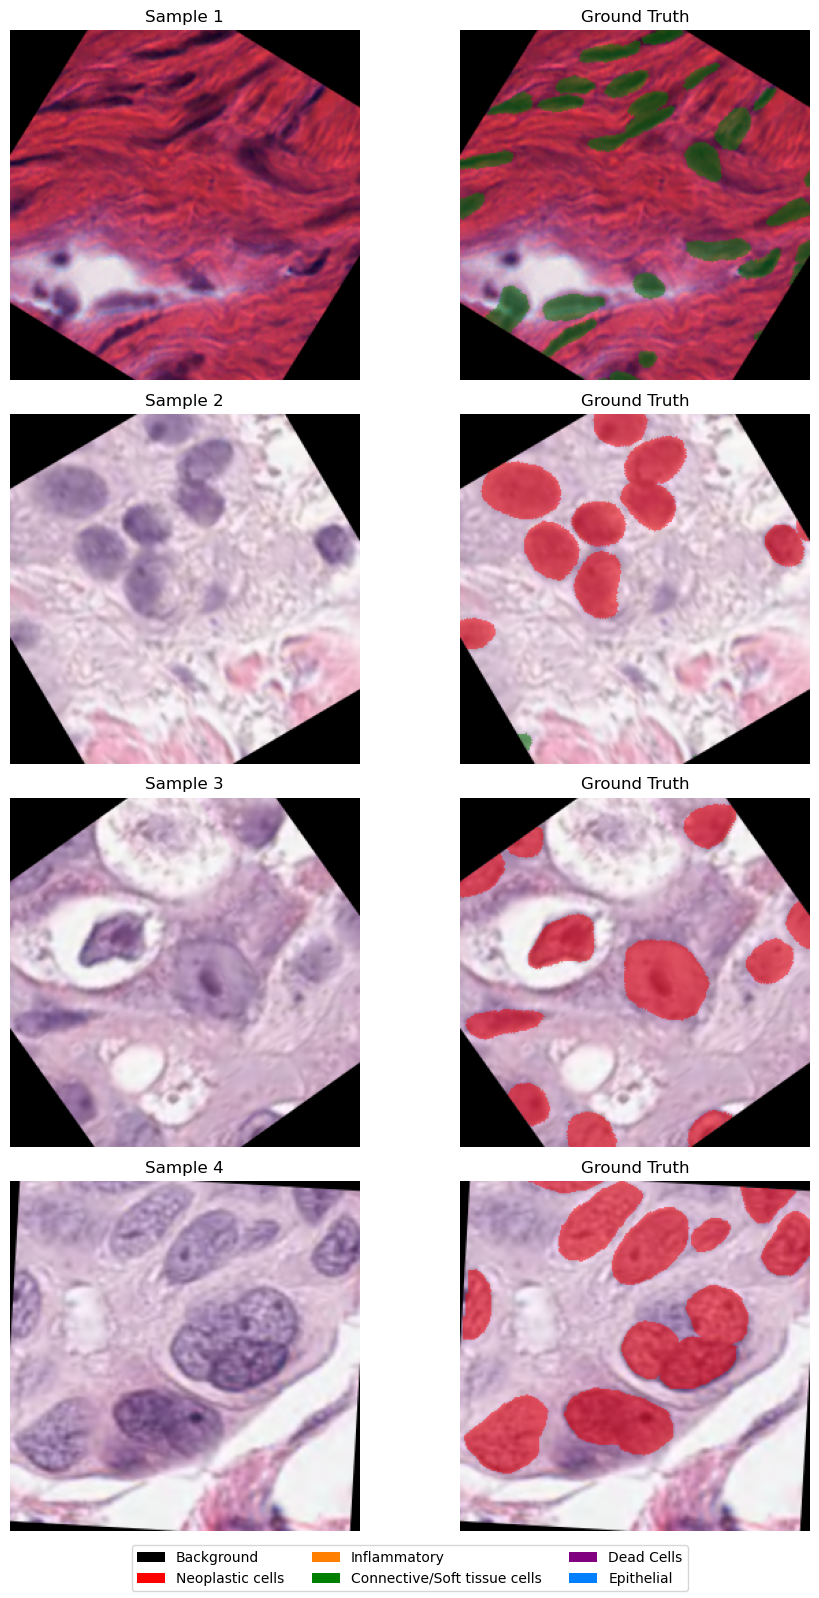

In [ ]:
# Define how many samples to visualize.
num_viz = 4
# Select 'num_viz' random, unique indices from the training dataset length.
indices = random.sample(range(len(train_dataset)), num_viz)

images = []
labels = []

# Loop through the random indices, fetch the sample data, and append to lists.
for idx in indices:
    sample = train_dataset[idx]
    images.append(sample['image']) # C x H x W tensor (normalized image)
    labels.append(sample['label']) # H x W tensor (class mask)

# Stack the list of tensors into a single batch tensor for plotting functions.
images = torch.stack(images) # B x C x H x W
labels = torch.stack(labels) # B x H x W

# Display the final visualization of the training samples (without predictions).
print(f"Visualizing {num_viz} random training samples")
plot_samples(images, labels, num_samples=num_viz)



#### Exploratory Data Analysis (EDA)

This code block executes a critical Exploratory Data Analysis (EDA) focused on characterizing the class imbalance within the training, validation, and test splits of the PanNuke dataset. The core logic is housed in the analyze_dataset_balance function, which iterates through every mask in the memory-mapped dataset to quantify two metrics for each of the six classes: pixel counts (total number of pixels belonging to a class) and image counts (the number of images containing at least one pixel of that class). Following the analysis, the plot_dataset_balance function visualizes these results using grouped bar plots. The first plot uses a logarithmic Y-axis to effectively highlight the severe pixel-level imbalance inherent to segmentation tasks (where the background class dominates) , while the second plot clearly shows class presence across the image population. This dual visualization is essential for determining if techniques like class weighting or robust sampling are necessary during the model training phase.

Analyzing Train dataset (2656 samples)...


Processing Train: 100%|██████████| 2656/2656 [00:25<00:00, 105.23it/s]


Analyzing Validation dataset (2523 samples)...


Processing Validation: 100%|██████████| 2523/2523 [00:23<00:00, 106.38it/s]


Analyzing Test dataset (2722 samples)...


Processing Test: 100%|██████████| 2722/2722 [00:25<00:00, 105.89it/s]


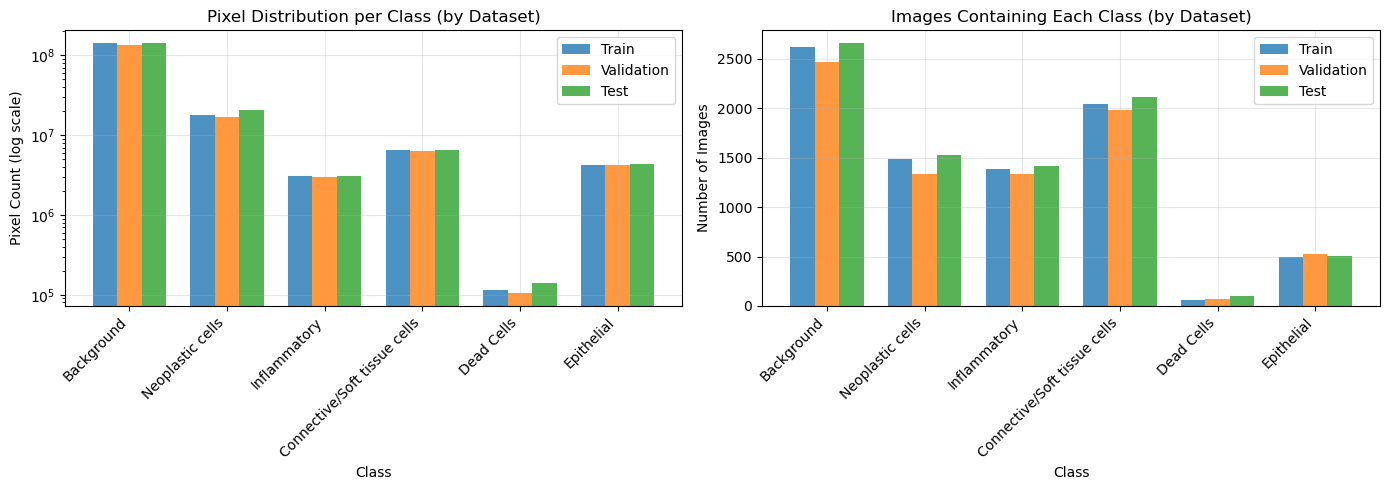

In [ ]:
def analyze_dataset_balance(datasets, dataset_names, num_classes=6):

    """
    Analyzes the class distribution across datasets, quantifying both:
    1. Pixel-level imbalance: Total number of pixels belonging to each class.
    2. Image-level presence: Total number of images that contain at least one pixel of each class.

    Args:
        datasets (list): List of PanNukeDataset objects (e.g., [train_dataset, val_dataset, test_dataset]).
        dataset_names (list): Corresponding names for visualization (e.g., ['Train', 'Validation', 'Test']).
        num_classes (int): Total number of classes (e.g., 6).

    Returns:
        tuple: (pixel_counts dictionary, image_counts dictionary).
    """

    # Define the remap array to ensure the Background class (originally 5 in PanNuke's one-hot)
    # is correctly mapped to 0, matching the convention used in __getitem__.
    remap = np.array([1, 2, 3, 4, 5, 0])  # Remap so background becomes 0 (0->1, 5->0, etc.)

    # Initialize dictionaries to store counts for each named dataset.
    pixel_counts = {name: np.zeros(num_classes, dtype=np.int64) for name in dataset_names}
    image_counts = {name: np.zeros(num_classes, dtype=np.int64) for name in dataset_names}

    # Iterate through each dataset split (Train, Val, Test).
    for dataset, name in zip(datasets, dataset_names):
        print(f"Analyzing {name} dataset ({len(dataset)} samples)...")

        # Iterate through every image in the current dataset using tqdm for progress tracking.
        for i in tqdm(range(len(dataset)), desc=f"Processing {name}"):

            # Retrieve the mask (which is memory-mapped) and perform preprocessing:
            # 1. np.argmax(..., axis=2) converts the H x W x 6 one-hot mask to H x W single-channel class IDs (0-5).
            # 2. remap[...] applies the label remapping (Background becomes 0).
            mask = remap[np.argmax(dataset.masks[i], axis=2)]

            # Efficiently count all unique class IDs and their pixel counts in the mask.
            unique, counts = np.unique(mask, return_counts=True)

            # Update the count dictionaries for the current dataset.
            for cls, cnt in zip(unique, counts):
                # Accumulate the total number of pixels for this class.
                pixel_counts[name][cls] += cnt
                # Increment the count of images that contain this specific class.
                image_counts[name][cls] += 1

    return pixel_counts, image_counts

def plot_dataset_balance(pixel_counts, image_counts, dataset_names, num_classes=6):

    """
    Visualizes the calculated class distributions using two bar plots:
    1. Pixel Count (on a logarithmic scale to handle severe imbalance).
    2. Image Presence Count.

    Args:
        pixel_counts (dict): Dictionary of total pixel counts per class per dataset.
        image_counts (dict): Dictionary of total images containing each class.
        dataset_names (list): Names of the datasets being plotted.
        num_classes (int): Total number of classes.
    """

    import matplotlib.pyplot as plt

    # Setup a figure with two subplots (1 row, 2 columns).
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    # Get human-readable class names for axis labels.
    class_labels = [CLASS_NAMES[i] for i in range(num_classes)]
    # Setup X-axis positions and bar width for grouped bar plots.
    x, width = np.arange(num_classes), 0.25

    # --- Subplot 1: Pixel Distribution (Log Scale) ---
    for idx, name in enumerate(dataset_names):
        # Plot bars for the current dataset, offsetting them by index * width.
        axes[0].bar(x + idx * width, pixel_counts[name], width, label=name, alpha=0.8)

    axes[0].set_xlabel('Class'); axes[0].set_ylabel('Pixel Count (log scale)')
    axes[0].set_title('Pixel Distribution per Class (by Dataset)')

    # Set the y-axis to a logarithmic scale, necessary because the background class
    # often has counts several orders of magnitude higher than foreground classes.
    axes[0].set_yscale('log')

    # Label X-axis ticks using class names, rotated for readability.
    axes[0].set_xticks(x + width); axes[0].set_xticklabels(class_labels, rotation=45, ha='right')
    axes[0].legend(); axes[0].grid(True, alpha=0.3)


    # --- Subplot 2: Image Presence Counts ---
    for idx, name in enumerate(dataset_names):
        # Plot bars showing how many images contain a given class.
        axes[1].bar(x + idx * width, image_counts[name], width, label=name, alpha=0.8)

    axes[1].set_xlabel('Class'); axes[1].set_ylabel('Number of Images')
    axes[1].set_title('Images Containing Each Class (by Dataset)')

    # Label X-axis ticks using class names, rotated for readability.
    axes[1].set_xticks(x + width); axes[1].set_xticklabels(class_labels, rotation=45, ha='right')
    axes[1].legend(); axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


# Run the analysis: The three dataset objects are passed along with their corresponding names.
pixel_counts, image_counts = analyze_dataset_balance(
    [train_dataset, val_dataset, test_dataset],
    ['Train', 'Validation', 'Test'],
    num_classes=config["num_classes"]
)

# Visualize the resulting statistics.
plot_dataset_balance(pixel_counts, image_counts, ['Train', 'Validation', 'Test'])


# 3. Models Definitions

## ResNetUnet

#### ConvBlock

This code defines a standard Convolutional Block (ConvBlock) that serves as a fundamental building component in many deep convolutional neural networks, particularly U-Net and ResNet-based architectures. The block encapsulates three sequential operations: a 3x3 Convolution (nn.Conv2d), Batch Normalization (nn.BatchNorm2d), and a ReLU activation (nn.ReLU). Crucially, the convolution sets bias=False because the subsequent Batch Normalization layer neutralizes the effect of the bias term, making it redundant and saving parameters. The block's forward pass implements this specific sequence, which is designed to efficiently extract features, stabilize training by normalizing intermediate outputs, and introduce essential non-linearity for learning complex patterns.



Given the input $
\mathbf{x} \in \mathbb{R}^{B \times C_{\text{in}} \times H_{\text{in}} \times W_{\text{in}}}
$, and the output $
\mathbf{y} \in \mathbb{R}^{B \times C_{\text{out}} \times H_{\text{out}} \times W_{\text{out}}}
$

The general formula for the output dimension for a convolution block is:

$$
H_{\text{out}} = \left\lfloor \frac{H_{\text{in}} + 2p - (k - 1) - 1}{s} \right\rfloor + 1
$$

$$
W_{\text{out}} = \left\lfloor \frac{W_{\text{in}} + 2p - (k - 1) - 1}{s} \right\rfloor + 1
$$

In this case:
- $k = 3$
- $p = 1$

$$
H_{\text{out}} 
= \left\lfloor \frac{H_{\text{in}} - 1}{s} \right\rfloor + 1
= \left\lceil \frac{H_{\text{in}}}{s} \right\rceil
$$

$$
W_{\text{out}} 
= \left\lfloor \frac{W_{\text{in}} - 1}{s} \right\rfloor + 1
= \left\lceil \frac{W_{\text{in}}}{s} \right\rceil
$$



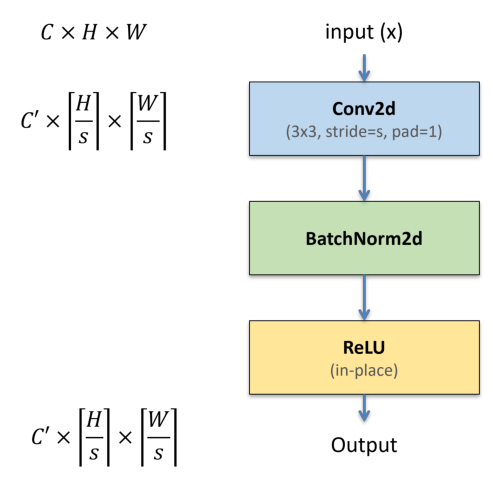

In [ ]:
display_image('images/convBlock.png', figsize=(12, 6))

In [28]:
import torch.nn as nn

class ConvBlock(nn.Module):

    """
    A foundational convolutional block used throughout the U-Net architecture.
    It performs a 3x3 Convolution, followed by Batch Normalization, and finally
    ReLU activation.
    """

    def __init__(self, in_channels, out_channels, stride=1):

        """
        Initializes the ConvBlock layers.

        Args:
            in_channels (int): The number of input feature channels.
            out_channels (int): The number of output feature channels.
            stride (int): The stride for the convolution operation (default is 1 for maintaining size).
        """

        # Calling constructor of the base class
        super(ConvBlock, self).__init__()

        # 1. Convolutional Layer (Conv2d)
        self.conv = nn.Conv2d(
            in_channels,      # Input channels, passed as a parameter
            out_channels,     # Output channels, passed as a parameter
            kernel_size=3,    # Standard 3x3 kernel size
            stride=stride,    # Stride of the kernel, passed as a parameter but defaults to 1
            padding=1,        # Padding=1 ensures the output spatial size (H, W) remains the same if stride=1
            bias=False        # Bias is set to False because it is rendered useless by the subsequent Batch Normalization layer.
        )

        # 2. Batch Normalization (BN)
        # BN normalizes the output of the convolution across the batch,
        # stabilizing training by mitigating exploding gradient issues
        self.bn = nn.BatchNorm2d(out_channels)

        # 3. Activation Function (ReLU)
        # ReLU introduces non-linearity. 'inplace=True' saves memory by
        # modifying the input directly.
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):

        """
        Defines the forward pass sequence: Convolution -> Batch Normalization -> ReLU.
        """

        x = self.conv(x)      # x is passed through the convolutional layer
        x = self.bn(x)        # the output is normalized
        return self.relu(x)   # and it's finally passed through the ReLU activation


#### ResBlock

This code defines the Residual Block (ResBlock), which is the fundamental unit of the ResNet architecture. Its primary purpose is to enable the training of very deep neural networks by introducing a shortcut connection that bypasses one or more layers, ensuring that the gradient can flow easily during backpropagation. The block is structured around two main paths, which are merged before the final activation:

[1] The Convolutional Path (Main Path): This path consists of a two-layer sequence designed for feature transformation, starting with a ConvBlock and followed by a second 3x3 Convolution and Batch Normalization.

[2] The Identity Path (Shortcut): This path simply carries the input tensor x forward to be added to the output of the main path. If the convolutional path changes the spatial dimensions (via stride=2) or the number of channels (if in_channels $\neq$ out_channels), the optional downsample module is applied to the input $x$ to match the required dimensions for the element-wise **residual addition** (out += identity`).

The final output is then passed through a ReLU activation.

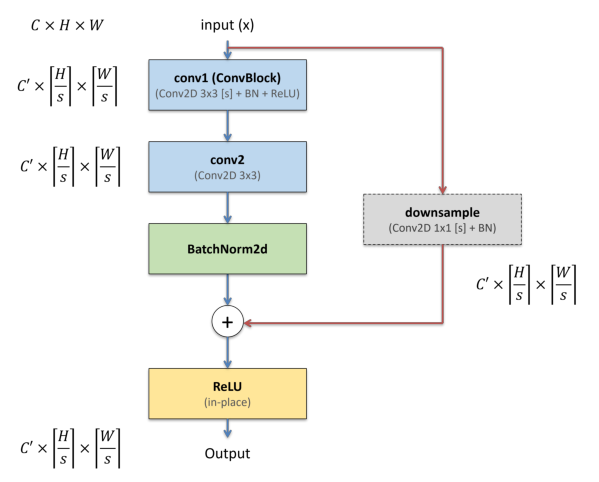

In [36]:
display_image('images/resblock.png', figsize=(12, 6))

In [29]:
import torch.nn as nn


class ResBlock(nn.Module):

    """
    A foundational Residual Block (ResNet identity or projection block).
    It implements the core residual connection:
    Output = ReLU(Convolutional_Path(x) + Identity).
    """

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):

        """
        Initializes the ResBlock layers.

        Args:
            in_channels (int): Number of input feature channels.
            out_channels (int): Number of output feature channels.
            stride (int): Stride for the first convolution
                (used for downsampling/projection). Default is 1.
            downsample (nn.Module, optional): A module (typically 1x1 Conv + BN)
                used to match dimensions of the input 'x' to the output of the
                convolutional path.
        """

        # Calling base module constructor
        super(ResBlock, self).__init__()

        # First Convolution (includes BN and ReLU from ConvBlock)
        # This layer may reduce the spatial size if stride > 1 (e.g., in the
        # first block of a stage).
        self.conv1 = ConvBlock(
            in_channels,    # Input channels, passed as a parameter
            out_channels,   # Output channels, passed as a parameter
            stride          # Stride, passed as a parameter but defaults to 1
        )

        # Second Convolution (Standard 3x3)
        # It takes the output channels from conv1 and maps to the final output channels.
        self.conv2 = nn.Conv2d(
            out_channels,   # Input channels (equal to the output channels)
            out_channels,   # Output channels
            kernel_size=3,  # Size of the sliding kernel
            padding=1,      # Padding=1 keeps spatial size constant (assuming stride=1 from conv1)
            bias=False      # Bias is set to False as it's followed by Batch Normalization.
        )

        # Batch Normalization (applied after conv2)
        self.bn = nn.BatchNorm2d(out_channels)

        # The downsample module is used if the input 'x' needs dimension matching
        # (either channel count or spatial size) with the output of the main path.
        # (e.g. width and height have been reduced or number of channels has increased)
        self.downsample = downsample

        # Final activation that has to be used after the residual connection (i.e.
        # after summing the output of the identity or downsample)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):

        """
        Defines the forward pass sequence: (ConvBlock -> Conv -> BatchNormalization.
         + DownSample) -> ReLU.
        """

        # Prepare the Identity/Shortcut
        # If downsample module is provided, apply it to the input 'x'
        # to match dimensions (C, H, W) of the main convolutional path output.
        identity = x
        if self.downsample:
            identity = self.downsample(x)

        # Main Convolutional Path
        out = self.conv1(x)    # a) ConvBlock = Conv -> BN -> Relu
        out = self.conv2(out)  # b) Conv
        out = self.bn(out)     # c) BN (applied after the second convolution)

        # Residual Connection (The core of ResNet)
        # Add the identity shortcut to the output of the convolutional path.
        # This addition only works because the dimensions of 'out' and 'identity' now match.
        out += identity

        # The sum is passed through the final ReLU activation.
        return self.relu(out)


#### DownBlock

This code defines the DownBlock module, which is responsible for the crucial downsampling (contraction) step in the encoder path of the ResNet-UNet architecture. Its primary function is to reduce the spatial dimensions (height and width) of the feature map by half while simultaneously increasing the channel depth, thereby extracting higher-level features. The DownBlock achieves this by constructing and encapsulating a ResBlock specifically configured for projection. The necessary dimension matching for the residual connection is handled by creating a downsample module: this module is a sequence of a 1x1 Convolution with a stride of 2 (to halve H and W) followed by Batch Normalization. This pre-configured downsample module is then passed to the ResBlock, ensuring that both the main convolutional path and the shortcut path reduce the spatial dimensions and adjust the channel depth identically, allowing for the proper residual addition (out += identity) before the feature map is passed to the next encoder stage.

In [6]:
import torch.nn as nn

class DownBlock(nn.Module):

    """
    This module performs the downsampling (or contraction) step in the U-Net
    encoder path.
    It encapsulates a ResBlock configured specifically for dimension reduction.
    """

    def __init__(self, in_channels, out_channels, stride=2):

        """
        Initializes the DownBlock layers.

        Args:
            in_channels (int): The number of input feature channels (from the previous stage).
            out_channels (int): The desired number of output feature channels (often doubled).
            stride (int): The stride used for downsampling (default is 2 to halve H and W).
        """

        # Calling base module constructor
        super(DownBlock, self).__init__()

        # Define the Downsampling/Projection Path (Shortcut)
        # This sequential module is used by the ResBlock's shortcut connection
        # to ensure dimension matching when the spatial size is halved and channel count increases.
        downsample = nn.Sequential(

            # 1x1 Convolution:
            # - Changes the channel depth from in_channels to out_channels.
            # - Uses stride=2 to halve the spatial size (H, W), matching the main path's output.
            nn.Conv2d(
                in_channels,    # Input channels of the ResBlock
                out_channels,   # Output channels of the ResBlock
                kernel_size=1,  # Kernel is 1x1
                stride=stride,  # Stride is set to 2 because we need to halve height and width
                bias=False      # Bias is excluded because Batch Normalization follows.
            ),

            # Batch Normalization:
            # - Normalizes the output of the 1x1 convolution.
            nn.BatchNorm2d(out_channels)
        )

        # Instantiate the ResBlock
        # - The 'stride' is passed to the ResBlock, causing the first convolution ( conv1
        #   inside ResBlock) to perform the spatial downsampling (halving H and W).
        # - The 'downsample' module is passed as the shortcut path, ensuring the dimensions
        #   of the input 'x' and the main path's output align for residual addition.
        self.resblock = ResBlock(in_channels, out_channels, stride, downsample)

    def forward(self, x):

        """
        Defines the forward pass, which is simply running the input through the
        configured ResBlock.
        """

        # The downsampling, channel increase, and residual addition all happen
        # within the ResBlock.
        return self.resblock(x)


#### UpBlock

This code defines the UpBlock, which is the core expansion and integration module in the U-Net decoder path. Its function is to perform three sequential tasks:

[1] Upsampling: The input feature map (x) from the previous, lower-resolution decoder stage is spatially doubled via nn.ConvTranspose2d (unless the initial upsample=False flag is set, primarily for the bottleneck).

[2] Concatenation: The upsampled feature map is then fused with the high-resolution feature map (skip_connection) from the corresponding encoder stage using torch.cat(..., dim=1). This concatenation is vital as it merges low-resolution semantic context with fine-grained spatial detail.

[3] Feature Refinement: The resulting feature map, which has a doubled channel count due to concatenation, is passed through a sequence of two ConvBlocks (self.double_conv). As correctly noted in the code comments, the input channel parameter (in_channels) passed to the first ConvBlock must precisely equal the sum of the channels from the upsampled tensor and the skip connection tensor. If the total input channels do not match the expected concatenated size, a dimension mismatch error will occur when the double_conv is called in the forward pass.

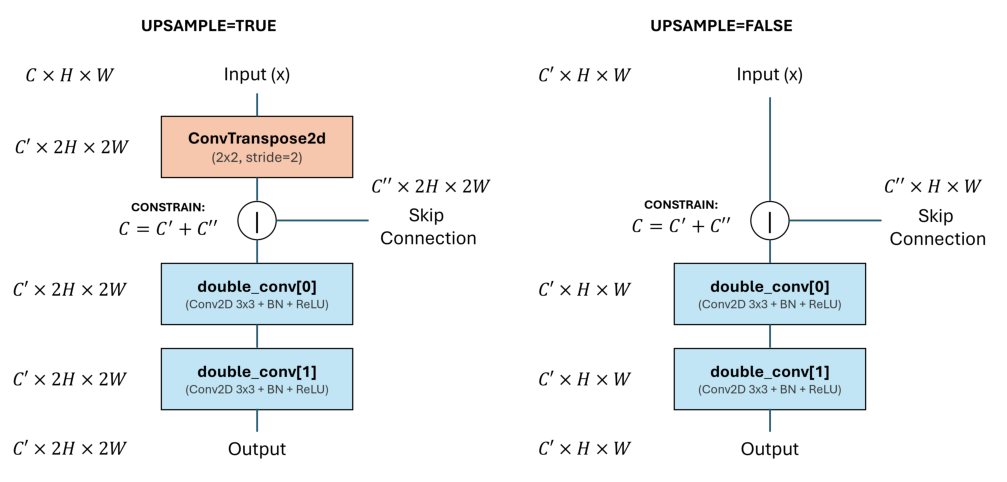

In [8]:
display_image('images/upblock.png', figsize=(16, 6))

In [31]:
import torch
import torch.nn as nn


class UpBlock(nn.Module):

    """
    This module performs the expansion (upsampling) step in the U-Net decoder path.
    It handles upsampling, concatenating the skip connection, and refining features
    with a sequence of two convolutional blocks.
    """

    def __init__(self, in_channels, out_channels, upsample=True):

        """
        Initializes the UpBlock layers.

        Args:
            in_channels (int): The number of input feature channels (from the
                previous, lower-resolution decoder stage).
            out_channels (int): The number of desired output feature channels (often halved).
            upsample (bool): If True, a ConvTranspose2d layer is used for upsampling H and W.
                Set to False primarily for the bottleneck block initialization.
        """

        # Calling base module constructor
        super(UpBlock, self).__init__()

        # - Upsampling Layer -
        # Use ConvTranspose2d (Transposed Convolution) for upsampling.
        # kernel_size=2 and stride=2 effectively doubles the spatial dimensions (H, W).
        # The output channels are set to 'out_channels' to prepare for concatenation.
        if upsample:
            self.upsample = nn.ConvTranspose2d(
                in_channels,      # Input channels
                out_channels,     # Output channels which are halved to match convolution after concatenation
                kernel_size=2,    # Kernel Size set to 2 (thus no overlapping between kernel applications since stride=2)
                stride=2          # Stride Size set to 2 to double height and width
            )

        # Used for the first block in the decoder (the one connected to the bottleneck)
        # where no initial upsampling is needed.
        else:
            self.upsample = None
        
        # - Double Convolution Block for Feature Refinement -
        # NOTE: Channels assumptions for in and out:
        # If upsample is True: Input channels = out_channels (from upsample) + channels_from_skip_connection
        # If upsample is False: Input channels = in_channels (from previous layer) + channels_from_skip_connection

        # Sequential block which will be fed with the concatenation of the skip
        # connection with the previous upsampling (the dimension concatenated is
        # the channel dimension)
        self.double_conv = nn.Sequential(

            # First ConvBlock takes the concatenated features (channels: in_channels)
            # and shrinks them to out_channels
            ConvBlock(in_channels, out_channels),

            # Second ConvBlock takes the output and maintains the channel size
            ConvBlock(out_channels, out_channels)
        )


    def forward(self, x, skip_connection):
        """
        Defines the forward pass sequence: Upsample -> Concatenate -> Double Convolution.

        Args:
            x (Tensor): The feature map from the previous decoder stage (lower
                resolution).
            skip_connection (Tensor): The feature map from the corresponding
                encoder stage (higher resolution).
        """

        # - Upsampling (if enabled)
        # Double the spatial dimensions (H, W) of the incoming feature map using conv transpose
        # From in_channels to out_channels
        if self.upsample:
            x = self.upsample(x)

        # - Skip Connection Concatenation
        # Concatenate the upsampled (or non-upsampled) decoder feature map (x)
        # with the high-resolution feature map from the encoder (skip_connection).
        # dim=1 is the channel dimension (B, C, H, W). This fuses semantic context
        # (from x) with fine-grained detail (from skip_connection).
        # x_channels (out_channels) + skip_connection_channels = in_channels  for construction
        x = torch.cat((x, skip_connection), dim=1)

        # - Feature Refinement
        # The concatenated features are processed by two ConvBlocks to learn how
        # to effectively combine the information.
        return self.double_conv(x)


#### ResNetUNet

This code defines the ResNetUNet architecture, a powerful model often used for semantic segmentation, that leverages the robust feature extraction capabilities of ResNet-style residual blocks within the classic U-Net framework. The network is fundamentally divided into an encoder (contraction), a bottleneck, and a decoder (expansion). The Encoder Path utilizes an initial ConvBlock to expand input channels, followed by a series of DownBlocks (which are stride-2 ResBlocks) to progressively halve the spatial dimensions while doubling the channel depth. The output of each encoder stage is saved as a skip connection. The deepest part of the network is the Bottleneck, which performs a brief, dense sequence of convolutions to maximize contextual feature extraction before the expansion phase begins. The Decoder Path uses UpBlocks in reverse order of the encoder, performing upsampling and feature refinement. Crucially, each UpBlock concatenates the upsampled low-resolution features with a corresponding high-resolution skip connection from the encoder, ensuring that fine-grained spatial details are preserved throughout the reconstruction process. The model concludes with a Final Convolution that maps the feature map back to the required number of output classes. The architecture is carefully designed to manage channel counts, particularly in the UpBlock where the input channels must match the sum of the upsampled feature channels and the skip connection channels to avoid dimension errors.

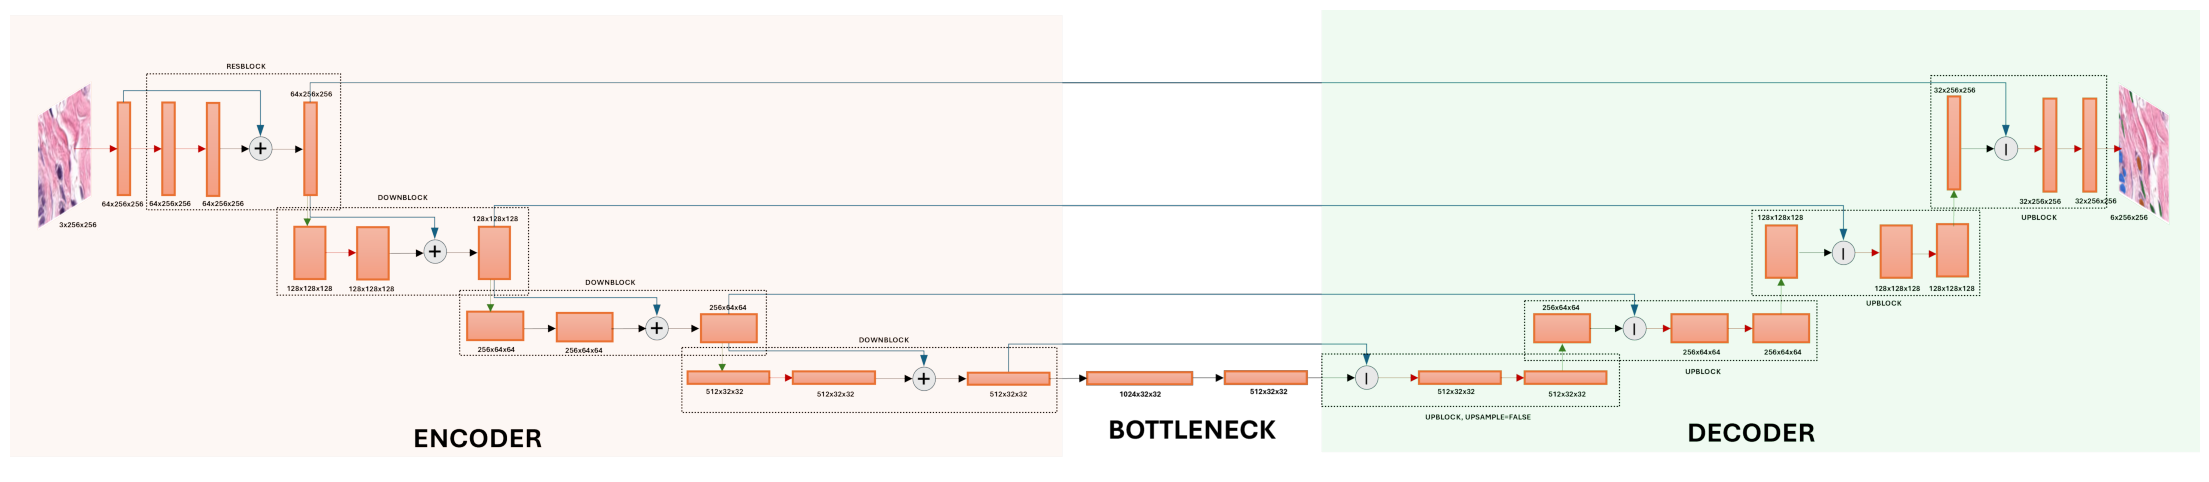

In [15]:
display_image('images/RESNET.png', figsize=(48, 6))

In [ ]:
import torch
import torch.nn as nn

class ResNetUNet(nn.Module):

    """
    A U-Net architecture that utilizes ResNet-style blocks (ResBlock and DownBlock)
    for its encoder path, providing robust feature extraction for segmentation tasks.
    """

    def __init__(self, in_channels, out_channels, features):

        """
        Initializes the ResNetUNet layers.

        Args:
            in_channels (int): Number of channels in the input image (e.g., 3 for RGB).
            out_channels (int): Number of output classes for segmentation.
            features (list): A list defining the channel depths for each encoder stage (e.g., [64, 128, 256, 512]).
        """

        # Calling base module constructor
        super(ResNetUNet, self).__init__()

        # - Initial Feature Expansion
        # Converts the input image channels (e.g., 3) to the starting feature
        # depth (features[0], e.g., 64).
        self.initial_conv = ConvBlock(in_channels, features[0])

        # - Encoder Path (Contraction)
        # Creating Encoder block by traversing list of feature map sizes
        self.encoders = nn.ModuleList()
        for idx, feature in enumerate(features):

            # The first encoder block (at the highest resolution) is a standard ResBlock (stride=1).
            # It processes features[0] -> features[0] without downsampling H/W.
            if idx == 0:
                self.encoders.append(ResBlock(features[idx], features[idx]))

            # Subsequent encoder blocks use DownBlock (ResBlock with stride=2).
            # It performs downsampling (H/W halved) and channel increase
            # (features[idx-1] -> features[idx]).
            else:
                self.encoders.append(DownBlock(features[idx - 1], feature))

        # - Bottleneck
        # The deepest part of the network, connecting the encoder to the decoder.
        # 1) Expansion (×2): Increases representational capacity temporarily, allowing the network to
        #    learn more complex features interaction and create a reacher space
        # 2) Compression (/2): Returns to the original channel count maintaining architectural symmetry with the encoder path
        bottleneck_channels = features[-1]
        self.bottleneck = nn.Sequential(
            ConvBlock(bottleneck_channels, bottleneck_channels * 2),
            ConvBlock(bottleneck_channels * 2, bottleneck_channels)
        )

        # - Decoder Path (Expansion)
        # Process the features list in reverse order to go from deep (high channels, low resolution)
        # to shallow (low channels, high resolution).
        reversed_features = features[::-1]

        # Creating Decoder blocks by traversing list of feature map sizes
        self.decoders = nn.ModuleList()
        for idx, feature in enumerate(reversed_features):

            # Determine the input channels for the UpBlock constructor:
            # Input channels = Channel from previous decoder stage (upsampled) + Channel from skip connection.

            # The first decoder block connects directly to the bottleneck.
            # 'upsample=False' is used because the bottleneck output is already at the correct size/depth
            # (features[-1]) and we need to handle the channel increase before the first concatenation.
            # Input channels = Bottleneck output (features[-1]) + Skip connection (features[-1]) = features[-1] * 2
            if idx == 0:
                self.decoders.append(UpBlock(features[-1]*2, feature, upsample=False))

            # Subsequent decoder blocks (idx > 0).
            # Skip connection channels arriving in the layer = feature channels = output channels
            # reversed_features[idx - 1] = output channels coming from the previous layer
            else:
                self.decoders.append(UpBlock(reversed_features[idx - 1], feature))

        # - Final Output
        # 1x1 Convolution maps the final feature depth (features[0], e.g., 64)
        # down to the required number of output classes (out_channels).
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):

        """
        Defines the data flow through the U-Net.
        """

        # - Encoder Path
        skip_connections = []
        x = self.initial_conv(x)

        # Sequentially pass data through encoder blocks, collecting feature maps
        # before each downsampling step for skip connections.
        for encoder in self.encoders:
            x = encoder(x)
            skip_connections.append(x) # Store feature map for later concatenation

        # - Bottleneck
        x = self.bottleneck(x)

        # - Decoder Path
        # Reverse the list of skip connections so they can be matched correctly
        # from deepest (last encoder output) to shallowest (first encoder output).
        skip_connections = skip_connections[::-1]

        # Iterate through decoder blocks, performing upsampling and feature merging.
        for idx, decoder in enumerate(self.decoders):
            # Pass the current feature map (x) and the corresponding skip connection.
            # The decoder handles upsampling (if necessary) and concatenation.
            x = decoder(x, skip_connections[idx])


        # - Final Output
        # Map the final feature map to the desired output class count.
        return self.final_conv(x)

First, an instance of the ResNetUNet model is created, dynamically setting its size and complexity using parameters like input channels, output classes, and the internal features list (defining the channel count in each U-Net stage) sourced from a config dictionary. Following instantiation, the summary function is called to provide a structured, layer-by-layer breakdown of the entire network. This summary is essential for verifying the model's structure, tracking how the tensor size changes (especially the spatial dimensions and channel counts), and quantifying the total number of parameters . By setting input_size with a dummy batch and specifying depth=4, the user requests a deep, detailed inspection that reveals the individual components of nested custom blocks (like ConvBlocks and ResBlocks), ensuring every internal operation and its associated parameter count is visible.

In [ ]:
# Create an instance of the ResNetUNet model.
# The parameters (in_channels, out_channels, features) are loaded from a configuration dictionary.
resNetUNet = ResNetUNet(
    in_channels=config["num_channels"],    # channels of input image
    out_channels=config["num_classes"],    # number of possible classes
    features=config["conv_channels"]       # defining channel (feature map size) decrease and increase (in the decoder, encoder)
)

# Use the summary tool to print a detailed table of the network architecture.
summary(

    # ResNetUNet model previously instantiated
    resNetUNet,

    # Define the shape of a single dummy input tensor (batch size, channels, height, width).
    # The '1' represents the batch size.
    input_size=(
        1,                                # Batch Size (1 for summary purposes)
        config["num_channels"],           # C: Input Channels (e.g., 3)
        config["image_size"],             # H: Input Height (e.g., 256)
        config["image_size"]              # W: Input Width (e.g., 256)
    ),

    # Specify which columns to display in the printed summary table.
    col_names=[
        "input_size",                     # Shows the input tensor shape for each layer
        "output_size",                    # Shows the output tensor shape for each layer
        "num_params"                      # Shows the number of trainable parameters in each layer
    ],

    # Set the depth for nested module inspection.
    # depth=4 means the summary will recurse 4 levels deep into nn.Sequentials,
    # nn.ModuleLists, and custom blocks (like ResBlock, DownBlock, UpBlock),
    # providing a highly detailed view of the internal layers (Conv2d, BatchNorm, etc.).
    depth=4,

    # Set the verbosity level. verbose=1 prints the full layer breakdown.
    verbose=1
)

print("") # Print a newline for clean formatting after the summary table.

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #
ResNetUNet                                    [1, 3, 256, 256]          [1, 6, 256, 256]          --
├─ConvBlock: 1-1                              [1, 3, 256, 256]          [1, 64, 256, 256]         --
│    └─Conv2d: 2-1                            [1, 3, 256, 256]          [1, 64, 256, 256]         1,728
│    └─BatchNorm2d: 2-2                       [1, 64, 256, 256]         [1, 64, 256, 256]         128
│    └─ReLU: 2-3                              [1, 64, 256, 256]         [1, 64, 256, 256]         --
├─ModuleList: 1-2                             --                        --                        --
│    └─ResBlock: 2-4                          [1, 64, 256, 256]         [1, 64, 256, 256]         --
│    │    └─ConvBlock: 3-1                    [1, 64, 256, 256]         [1, 64, 256, 256]         --
│    │    │    └─Conv2d: 4-1                  [1, 64, 256, 256]         [1, 64, 25

## TransUNet

### Embeddings

I have implemented these modules to serve as the Hybrid Embedding front-end for the TransUNet architecture, bridging the gap between convolutional feature extraction and transformer-based global modeling. The PatchEmbeddings class functions as a progressive encoder that uses a series of strided convolutions to downsample the image from 256x256 to a 16x16 feature map while simultaneously increasing channel depth. This convolutional bottleneck is essential for medical image segmentation because it captures localized spatial details, preserved in the skips dictionary for later use by the decoder, before flattening the data into a sequence of 256 visual tokens. Finally, the Embeddings class injects learnable positional information into these tokens through element-wise addition, ensuring the transformer layers understand the relative spatial arrangement of the patches, and applies dropout to enhance the model's generalization capabilities during training.

In [ ]:

class PatchEmbeddings(nn.Module):

    """
    Transforms an input image into a sequence of learnable patch tokens.
    Unlike a standard ViT that uses a single large stride, this version uses
    a 'Hybrid' approach with multiple convolutional layers to extract
    spatial features and skip connections for the decoder.
    """

    def __init__(self, config):

        """
        Initializes the PatchEmbeddings layers.

        Args:
            config (dict): A dictionary containing configuration parameters.
        """

        # Calling base module constructor
        super().__init__()

        # Total tokens = (Image Side / Patch Side)^2. Standard ViT patch size = 16
        embedding_channels = config["embedding_channels"]
        self.num_patches = (config["image_size"] // config["patch_size"]) ** 2

        # --- Initial Feature Extraction ---

        # With a kernel size of 3, a padding of 1 (to maintain the same image size) -> feature extraction
        # Layer0: B x 3 x 256 x 256 -> B x 64 x 256 x 256
        self.conv0 = ConvBlock(config["num_channels"], embedding_channels[0])

        # --- Downsampling Stack ---
        # Layer1: (B x 64 x 256 x 256) -> (B x 64 x 128 x 128)
        self.conv1 = ConvBlock(embedding_channels[0], embedding_channels[0], stride=2)

        # Layer 2: (B x 64 x 128 x 128) -> (B x 128 x 64 x 64)
        self.conv2 = ConvBlock(embedding_channels[0], embedding_channels[1], stride=2)

        # Layer 3: (B x 128 x 64 x 64) -> (B x 256 x 32 x 32)
        self.conv3 = ConvBlock(embedding_channels[1], embedding_channels[2], stride=2)


        # --- Final Projection ---

        # Projects the feature map to the Transformer's hidden dimension.
        # With a kernel size of 3, a padding of 1 and a stride set to 2
        # we are dividing by 2 both H and W
        # Layer4: (B x 256 x 32 x 32) -> (B x hidden_size x 16 x 16)
        self.projection = nn.Conv2d(
            in_channels=embedding_channels[2],             # Feature map now goes from 256 to the
            out_channels=config["hidden_size"],            # hidden size of the embeddings (512)
            kernel_size=3, stride=2, padding=1             # Reducing image size by 2 for each dim
        )

    def forward(self, x):
        """
            Defines the forward pass sequence

            Args:
                x (Tensor): Input tensor of shape (Batch, Channels, Height, Width).
        """

        # Input: (Batch, Channels, 256, 256)
        y0 = self.conv0(x)
        y1 = self.conv1(y0)
        y2 = self.conv2(y1)
        y3 = self.conv3(y2)


        # Patch projection and Tokenization
        # (B x 256 x 32 x 32) -> (B x 512 x 16 x 16)
        x_proj = self.projection(y3)                  # Shape: (B, hidden, 16, 16)

        # Flatten spatial dims into a sequence: (B, hidden, 256)
        # Then swap dims for Transformer input: (B, 256, hidden)
        tokens = x_proj.flatten(2).transpose(1, 2)

        # Return tokens plus intermediate feature maps for UNet-style skip connections
        skips = {
            'conv1': y1,
            'conv2': y2,
            'conv3': y3,
            'conv4': x_proj
        }

        return tokens, skips


class Embeddings(nn.Module):
    """
    Combines Patch Embeddings with Learnable Position Embeddings.
    This prepares the image data for processing by the Transformer encoder.
    """

    def __init__(self, config):

        """
            Initializes the Embeddings layers.
            > PatchEmbeddings: B x 3 x 256 x 256 -> B x (16 * 16) x hidden_size
            > PositionEmbeddings: B x (16*16) x hidden_size

            Args:
                config (dict): A dictionary containing configuration parameters.
        """

        # Calling constructor of base module
        super().__init__()

        # Initializing Patch Embeddings
        self.patch_embeddings = PatchEmbeddings(config)

        # Position Embeddings: Learnable parameters that give the model info about patch location, learned since images have a fixed number of patches (tokens)
        # Shape: (1, Num_Patches, Hidden_Size)
        self.position_embeddings = nn.Parameter(
            torch.zeros(1, self.patch_embeddings.num_patches, config["hidden_size"])
        )

        # Regularization to prevent overfitting on specific positions
        self.dropout = nn.Dropout(config["hidden_dropout_prob"])


    def forward(self, x):

        """
            Defines the forward pass sequence:
            > Return: PatchEmbeddings + PositionEmbeddings, Skip Connections

            Args:
                x (Tensor): Input tensor of shape (Batch, Channels, Height, Width).
        """

        # Create tokens and extract skip features
        x , skips = self.patch_embeddings(x)

        # Element-wise addition of position information
        # PyTorch broadcasting handles the batch dimension automatically
        embeddings = x + self.position_embeddings

        # Apply dropout and return
        embeddings = self.dropout(embeddings)

        # Returning Final Embeddings + Skip Connections
        return embeddings, skips


### Encoder

This code defines the Attention module, which serves as the core communication mechanism within the Transformer Encoder by implementing Multi-Head Self-Attention (MHSA). By utilizing PyTorch's nn.MultiheadAttention, the model projects the input tokens into multiple "heads," allowing it to simultaneously attend to different types of spatial relationships across the image. Unlike standard convolutional layers that only "see" neighboring pixels, this module allows every patch in the 16x16 grid to interact with every other patch, effectively creating a global receptive field. In the forward pass, the Query, Key, and Value matrices are all derived from the same input x, and the need_weights=False parameter is strategically used to optimize performance by skipping the materialization of the full attention matrix, which is unnecessary during the training phase.

In [ ]:
class Attention(nn.Module):
    """
    Implements a Multi-Head Self-Attention (MHSA) mechanism.
    This allows the model to jointly attend to information from different
    representation subspaces at different positions.
    """

    def __init__(self, config):
        """
            Initializes the Attention layers.

            Args:
                config (dict): A dictionary containing configuration parameters.
        """

        # Calling base model constructor
        super().__init__()

        # Multi-Head Attention Layer used for the Transformer Encoder
        # embed_dim: The total dimension of the model (hidden_size).
        # num_heads: Parallel attention layers. hidden_size must be divisible by num_heads.
        # dropout: Probability of dropout, looked up in global config dictionary
        # batch_first=True: Expects input tensors of shape (Batch, Seq_Len, Hidden_Dim).
        self.mha = nn.MultiheadAttention(
            embed_dim=config["hidden_size"],
            num_heads=config["num_attention_heads"],
            dropout=config["attention_probs_dropout_prob"],
            batch_first=True
        )

    def forward(self, x):
        """
            Defines the forward pass sequence:
            > Return: Attention Output

            Args:
                x (Tensor): Input tensor of shape (Batch, Seq_Len, Hidden_Dim).
        """

        # x: (batch_size, num_patches, hidden_size)
        # In Self-Attention, Query (Q), Key (K), and Value (V) all come from
        # the same input x.
        # need_weights=False avoids unnecessary computation of the attention
        # map during training (we don't care about internal scores)
        attn_output, _attn_weights = self.mha(x, x, x, need_weights=False)
        return attn_output

This code implements the MLP (Multi-Layer Perceptron) module, which acts as the position-wise feed-forward network within each Transformer block. While the attention mechanism allows tokens to communicate with one another, the MLP focuses on processing the features of each token independently, enabling the model to learn complex non-linear transformations within the high-dimensional feature space. It follows a standard expansion-contraction bottleneck design, where the first linear layer projects the hidden_size to a larger intermediate_size, allowing the model to capture more intricate patterns, before the second layer projects it back to the original dimension.

The use of the GELU (Gaussian Error Linear Unit) activation function provides a smooth, non-monotonic gradient that is standard in Vision Transformers, while strategically placed dropout layers provide essential regularization to prevent overfitting on the training data.

In [83]:

class MLP(nn.Module):

    """
    A two-layer Feed-Forward Network (FFN) applied to each token independently.
    It expands the hidden dimension and then projects it back to the original size.
    """

    def __init__(self, config):

        """
            Initializes the MLP layers.

            Args:
                config (dict): A dictionary containing configuration parameters.
        """

        # Calling base model constructor
        super().__init__()

        # First linear layer expands the dimension (2 x hidden_size).
        # Second linear layer projects it back to the hidden_size.
        self.fc1 = nn.Linear(config["hidden_size"], config["intermediate_size"])
        self.fc2 = nn.Linear(config["intermediate_size"], config["hidden_size"])

        # GELU (Gaussian Error Linear Unit) is the standard activation for ViT/Transformers.
        # Dropout is set according to global configuration dictionary value
        self.activation = nn.GELU()
        self.dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x):

        """
            Defining Forward Pass as
            Linear -> GELU -> Dropout -> Linear -> Dropout

            Args:
                x (Tensor): Input tensor of shape (Batch, Seq_Len, Hidden_Dim).
        """

        # Layer 1: Linear -> GELU -> Dropout
        x = self.fc1(x)
        x = self.activation(x)
        x = self.dropout(x) # Regularization after activation

        # Layer 2: Linear -> Dropout
        x = self.fc2(x)
        x = self.dropout(x) # Final regularization

        return x


I have implemented the TransformerBlock class to function as the fundamental computational unit of the encoder, seamlessly integrating global communication with localized feature refinement. This module follows the modern Pre-Norm architecture, where LayerNorm is applied before the Attention and MLP sub-layers to ensure stable gradient flow and prevent internal covariate shift during training. A critical component of this design is the use of Residual Connections (or skip connections), implemented via the x + h operations. These connections allow the original input signal to bypass the non-linear transformations of each sub-layer, effectively mitigating the vanishing gradient problem and enabling the model to learn incremental refinements across deep stacks. By alternating between Multi-Head Attention for global spatial reasoning and an MLP for token-wise processing, this block provides a balanced and robust mechanism for extracting complex hierarchical features from the image tokens.

In [ ]:

class TransformerBlock(nn.Module):

    """
    A single Transformer Encoder block consisting of Multi-Head Attention and an MLP,
    wrapped with Layer Normalization and Residual (skip) connections.
    """

    def __init__(self, config):

        """
            Initializes the TransformerBlock layers.

            Args:
                config (dict): A dictionary containing configuration parameters.
        """

        # Calling base module constructor
        super().__init__()

        # Initializing attention layer and MLP layer
        self.attention = Attention(config)
        self.mlp = MLP(config)

        # LayerNorm is applied to stabilize the activations and gradients.
        # Pre-norm architecture is used here (norm before the sub-layers).
        self.layernorm_before = nn.LayerNorm(config["hidden_size"], eps=1e-6)
        self.layernorm_after = nn.LayerNorm(config["hidden_size"], eps=1e-6)

    def forward(self, x):

        """
            Defines the forward pass sequence:
            > LayerNorm -> Attention -> Residual Connection
            > LayerNorm -> MLP -> Residual Connection

            Args:
                x (Tensor): Input tensor of shape (Batch, Seq_Len, Hidden_Dim).
        """

        # Save for residual connection
        h = x

        # Applying LayerNorm, Attention and then Residual Connection
        x = self.layernorm_before(x)
        x = self.attention(x)
        x = x + h           # Residual connection 1: x_new = MHSA(LN(x)) + x

        # Save for residual connection
        h = x

        # Applying LayerNorm, MLP and then Residual Connection
        x = self.layernorm_after(x)
        x = self.mlp(x)
        x = x + h

        return x

I have implemented the Encoder class to serve as the high-level processing engine of the TransUNet, responsible for stacking multiple TransformerBlocks to form a deep hierarchical architecture. By utilizing a nn.ModuleList, the class manages a sequence of seven transformer blocks, allowing the model to iteratively refine the global context of the image tokens. As the hidden states pass through each successive block, the network learns increasingly abstract relationships between distant regions of the input image, overcoming the receptive field limitations of traditional convolutional encoders. The process concludes with a final LayerNorm operation, which standardizes the activations across the hidden dimension to ensure that the encoded tokens are well-conditioned before being passed to the decoder for high-resolution reconstruction.

In [85]:
class Encoder(nn.Module):

    """
    The full Transformer Encoder stack, composed of multiple TransformerBlocks.
    """

    def __init__(self, config):

        """
            Initializes the Encoder layers.

            Args:
                config (dict): A dictionary containing configuration parameters.
        """

        # Calling base module constructor
        super().__init__()

        # ModuleList allows PyTorch to track the list of sub-modules properly.
        # We stack 'num_hidden_layers' (7) Transformer Blocks
        self.num_hidden_layers = config["num_hidden_layers"]
        self.layer = nn.ModuleList([
            TransformerBlock(config) for _ in range(self.num_hidden_layers)
        ])

        # Final normalization applied to the output of the transformer stack.
        self.encoder_norm = nn.LayerNorm(config["hidden_size"], eps=1e-6)

    def forward(self, hidden_states):

        """
            Implements forward pass as a sequence of Transformer Blocks.

            Args:
                hidden_states (Tensor): Input tensor of shape (Batch, Seq_Len, Hidden_Dim).
        """

        # Sequentially pass the tokens through each transformer block.
        for layer_block in self.layer:
            hidden_states = layer_block(hidden_states)

        # Final layer normalization.
        encoded = self.encoder_norm(hidden_states)

        return encoded


### Decoder

I have implemented the Decoder module to act as the expansive path of the TransUNet, transforming abstract 1D transformer tokens back into high-resolution 2D feature maps. The process begins with a crucial spatial reconstruction step, where the $256$ tokens are reshaped into a $16 \times 16$ grid to re-establish a convolutional format.  To ensure the decoder retains the rich spatial information typically lost during deep encoding, I've integrated a series of UpBlock layers that follow a U-Net style architecture.  This involves concatenating the upsampled features with high-resolution "skip" features (e.g., conv1 through conv4) extracted from the initial CNN-based PatchEmbeddings. By progressively doubling the spatial resolution while refining the channel depth, this decoder effectively marries the global contextual understanding of the Transformer with the precise localized details of the CNN, resulting in sharp and accurate segmentation boundaries.

In [ ]:

class Decoder(nn.Module):

    """
    The Decoder module is responsible for 'upsampling' the abstract 1D tokens
    back into a 2D segmentation mask. It uses a U-Net style architecture with
    skip connections to recover spatial details lost during encoding.
    """

    def __init__(self, config):

        """
            Initializes the Decoder layers.

            Args:
                config (dict): A dictionary containing configuration parameters.
        """

        # Calling base module constructor
        super().__init__()

        # Number of channels used progressively to decode i.e. [256, 128, 64]
        decoder_channels = config["decoder_channels"]

        # After concatenating the ViT output with the 'conv4' skip connection,
        # the channel depth doubles. This block reduces it back to hidden_size.
        self.reproj = ConvBlock(config["hidden_size"] * 2, config["hidden_size"])

        ## --- Upsampling Path ---
        ##  Each UpBlock performs: Upsample -> Concatenate Skip -> Convolution

        # Level 1: (Bx512x16x16) -> (Bx256x32x32)
        # Level 2: (Bx256x32x32) -> (Bx128x64x64)
        # Level 3: (Bx128x64x64) -> (Bx64x128x128)
        self.up1 = UpBlock(config["hidden_size"], decoder_channels[0])
        self.up2 = UpBlock(decoder_channels[0], decoder_channels[1])
        self.up3 = UpBlock(decoder_channels[1], decoder_channels[2])


    def forward(self, hidden_states, skips):

        """
        Args:
            hidden_states (Tensor): Output from Transformer Encoder (B, 256, 512)
            skips (dict): Dictionary of feature maps from the CNN PatchEmbedding
        """

        # Reshape 1D Tokens to 2D Feature Map
        # (B, 256, 512) -> (B, 512, 256) -> (B, 512, 16, 16)
        B, n_patch, hidden = hidden_states.size()
        h = w = int(np.sqrt(n_patch))  # Calculates 16 for a 256-patch sequence
        x = hidden_states.permute(0, 2, 1).contiguous().view(B, hidden, h, w)

        # Integrate the deepest skip connection (conv4)
        # Dim 1 is the channel dimension. Cat results in (B, 1024, 16, 16)
        x = torch.cat((x, skips.get('conv4')), dim=1)
        x = self.reproj(x)

        # Successive Upsampling with Skip Connections
        # We pass the intermediate CNN features to recover fine-grained spatial boundaries.
        # (B, 512, 16, 16) + conv3 (32x32) -> (B, 256, 32, 32)
        # (B, 256, 32, 32) + conv2 (64x64) -> (B, 128, 64, 64)
        # (B, 128, 64, 64) + conv1 (128x128) -> (B, 64, 128, 128)
        x = self.up1(x, skips.get("conv3"))
        x = self.up2(x, skips.get("conv2"))
        x = self.up3(x, skips.get("conv1"))

        return x


I have implemented the SegmentationHead as the terminal component of the TransUNet architecture, designed to transition the high-dimensional feature representations back into the original pixel space for multi-class classification. The module utilizes a Transposed Convolution with a stride of 2 to effectively "un-pool" the feature maps, doubling their spatial resolution from $128 \times 128$ to the target $256 \times 256$.  By setting output_padding=1, I ensure the output dimensions exactly match the initial input size, resolving the mathematical ambiguity inherent in strided downsampling operations.  The process concludes with a BatchNorm and ReLU sequence to stabilize activations, followed by a final $3 \times 3$ convolutional layer that projects the feature channels into a set of logits corresponding to each nuclei class. This mapping translates abstract global and local features into a dense, pixel-wise prediction mask.

In [87]:

class SegmentationHead(nn.Module):

    """
    The final block of the network. It performs the last upsampling step
    to restore the original image resolution and projects the feature
    channels to the number of target classes.
    """

    def __init__(self, in_channels, num_classes, kernel_size=3):

        # Calling base module constructor
        super().__init__()

        # --- Final Upsampling ---
        # The decoder typically stops at 128x128. This Transposed Convolution
        # doubles the spatial dimensions to reach the final 256x256 resolution.
        # stride=2: Doubles H and W
        # output_padding=1: Ensures the output matches the exact input size (256)
        self.conv = nn.ConvTranspose2d(
            in_channels,                # Input channels
            in_channels,                # Output channels (they are not changed)
            kernel_size=kernel_size,    # Kernel size (defaults to 3)
            padding=kernel_size // 2,   # Padding equal to half kernel size (each original pixel is scanned)
            stride=2,                   # Stride set to 2 in order to double H and W
            output_padding=1            # This ensures that the output matches the exact input size (256)
        )

        # --- Normalization and Activation ---
        # Stabilizes the high-level features before the final classification
        self.bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)

        # --- Class Projection ---
        # A 3x3 convolution that collapses the high-dimensional
        # feature map into a set of heatmaps, one for each class.
        # Shape: (B, in_channels, 256, 256) -> (B, num_classes, 256, 256)
        self.conv2 = nn.Conv2d(
            in_channels,
            num_classes,
            kernel_size=kernel_size,
            padding=kernel_size // 2
        )

    def forward(self, x):

        """
            Forward pass sequence:
            Upsample -> BatchNorm -> ReLU -> Class Conv

            Args:
                x (Tensor): Input tensor of shape (Batch, Channels, Height, Width).
        """

        # Upsample -> BN -> Relu
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)

        # Final output contains raw logits for each class per pixel
        return self.conv2(x)


### TransUNet

I have implemented the TransUNet class as the master assembly for the entire architecture, effectively merging the strengths of Transformers and CNNs into a single U-shaped pipeline. The model begins with a hybrid encoding phase, where the Embeddings layer extracts multi-scale spatial features, stored in the skips dictionary, while simultaneously tokenizing the image for the Transformer Encoder. By processing these tokens through the global attention mechanism, the model gains a comprehensive understanding of the relationships between distant structures, such as different nuclei across a pathology slide. The Decoder then bridges this abstract global information back to the pixel level by iteratively upsampling and concatenating the high-resolution skip features. Finally, the SegmentationHead ensures that the final output is a dense prediction mask that matches the original input resolution, providing a pixel-wise classification that is both contextually aware and spatially precise.

In [92]:
class TransUNet(nn.Module):

    """
    TransUNet Architecture: A Hybrid CNN-Transformer for Medical Image Segmentation.
    This model combines the global context-modeling power of a Vision Transformer (ViT)
    with the precise localization capabilities of a U-Net decoder.
    """

    def __init__(self, config):

        """
        Initializes the top-level modules of the TransUNet.

        Args:
            config (dict): Global configuration containing hidden_size,
                          num_classes, and other architectural parameters.
        """

        # Calling base model constructor
        super().__init__()

        # --- Hybrid Encoder ---
        # The Embeddings module uses a CNN-based 'PatchEmbedding' to extract
        # local features (skips) and projects the image into 1D tokens.
        self.embeddings = Embeddings(config)

        # The Transformer Encoder processes the 1D tokens to capture
        # long-range dependencies (global context).
        self.encoder = Encoder(config)

        # --- Decoder ---
        # The Decoder takes the transformer output and uses U-Net style skip
        # connections to upsample the feature maps back toward the original resolution.
        self.decoder = Decoder(config)

        # --- Prediction Head ---
        # Converts the last feature map (64 channels) into the final class logits
        # and performs the final 2x upsampling to match the input image size.
        self.segmentation_head = SegmentationHead(
            in_channels=config["decoder_channels"][-1],
            num_classes=config["num_classes"]
        )

    def forward(self, x):

        """
        Full Forward Pass:
        Image -> Hybrid Embedding -> Transformer -> U-Net Decoder -> Prediction

        Args:
            x (Tensor): Input image batch of shape (Batch, 3, 256, 256)

        Returns:
            Tensor: Raw logits for each class of shape (Batch, num_classes, 256, 256)
        """

        # --- Encoding Phase ---
        # embedding_output: 1D tokens (Batch, 256, hidden_size)
        # skips: Dict of CNN feature maps used for spatial recovery in the decoder
        embedding_output, skips = self.embeddings(x)

        # Pass tokens through the stack of Transformer blocks
        encoded = self.encoder(embedding_output)

        # --- Decoding Phase ---
        # Reshapes tokens back to 2D and fuses them with skip connections (conv1-conv4)
        decoded = self.decoder(encoded, skips)

        # --- Final Phase ---
        # Final upsampling and 3x3 conv to produce class probability maps (logits)
        logits = self.segmentation_head(decoded)

        return logits


I have implemented this initialization and summary block to serve as the final validation step before launching the training pipeline. By instantiating the TransUNet with the global configuration dictionary and passing it through the torchsummary (or torchinfo) tool, I can verify that the complex tensor transformations, moving from 2D convolutions to 1D Transformer tokens and back to a 2D segmentation mask, are mathematically consistent. The summary output provides a layer-by-layer breakdown of the input and output shapes, ensuring that the skip connections from the convolutional encoder correctly align with the upsampling stages of the decoder. Furthermore, by setting the depth=4, I can inspect the internal parameter count of the Transformer blocks and the PatchEmbedding layers, ensuring that the model's capacity is correctly distributed and that the total number of trainable parameters fits within the available GPU memory constraints.

In [90]:
# Create an instance of the TransUNet model.
# The parameters are passed as a configuration dictionary.
transUNet = TransUNet(
    config=config   # Global Configuration Dictionary
)

# Use the summary tool to print a detailed table of the network architecture.
summary(

    # transUNet model previously instantiated
    transUNet,

    # Define the shape of a single dummy input tensor (batch size, channels, height, width).
    # The '1' represents the batch size.
    input_size=(
        1,                                # Batch Size (1 for summary purposes)
        config["num_channels"],           # C: Input Channels (e.g., 3)
        config["image_size"],             # H: Input Height (e.g., 256)
        config["image_size"]              # W: Input Width (e.g., 256)
    ),

    # Specify which columns to display in the printed summary table.
    col_names=[
        "input_size",                     # Shows the input tensor shape for each layer
        "output_size",                    # Shows the output tensor shape for each layer
        "num_params"                      # Shows the number of trainable parameters in each layer
    ],

    # Set the depth for nested module inspection.
    # depth=4 means the summary will recurse 4 levels deep
    depth=4,

    # Set the verbosity level. verbose=1 prints the full layer breakdown.
    verbose=1
)

print("") # Print a newline for clean formatting after the summary table.


Layer (type:depth-idx)                             Input Shape               Output Shape              Param #
TransUNet                                          [1, 3, 256, 256]          [1, 6, 256, 256]          --
├─Embeddings: 1-1                                  [1, 3, 256, 256]          [1, 256, 512]             131,072
│    └─PatchEmbeddings: 2-1                        [1, 3, 256, 256]          [1, 256, 512]             --
│    │    └─ConvBlock: 3-1                         [1, 3, 256, 256]          [1, 64, 256, 256]         --
│    │    │    └─Conv2d: 4-1                       [1, 3, 256, 256]          [1, 64, 256, 256]         1,728
│    │    │    └─BatchNorm2d: 4-2                  [1, 64, 256, 256]         [1, 64, 256, 256]         128
│    │    │    └─ReLU: 4-3                         [1, 64, 256, 256]         [1, 64, 256, 256]         --
│    │    └─ConvBlock: 3-2                         [1, 64, 256, 256]         [1, 64, 128, 128]         --
│    │    │    └─Conv2d: 4-4    

In [91]:
state_dict = torch.load("transUNet_final_train.pth", map_location="cpu")
transUNet.load_state_dict(state_dict)

C:\Users\brill\AppData\Local\Temp\ipykernel_23172\3968203710.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("transUNet_final_train.pth", map_loc

RuntimeError: Error(s) in loading state_dict for TransUNet:
	Missing key(s) in state_dict: "embeddings.patch_embeddings.conv0.conv.weight", "embeddings.patch_embeddings.conv0.bn.weight", "embeddings.patch_embeddings.conv0.bn.bias", "embeddings.patch_embeddings.conv0.bn.running_mean", "embeddings.patch_embeddings.conv0.bn.running_var", "embeddings.patch_embeddings.conv1.conv.weight", "embeddings.patch_embeddings.conv1.bn.weight", "embeddings.patch_embeddings.conv1.bn.bias", "embeddings.patch_embeddings.conv1.bn.running_mean", "embeddings.patch_embeddings.conv1.bn.running_var", "embeddings.patch_embeddings.conv2.conv.weight", "embeddings.patch_embeddings.conv2.bn.weight", "embeddings.patch_embeddings.conv2.bn.bias", "embeddings.patch_embeddings.conv2.bn.running_mean", "embeddings.patch_embeddings.conv2.bn.running_var", "embeddings.patch_embeddings.conv3.conv.weight", "embeddings.patch_embeddings.conv3.bn.weight", "embeddings.patch_embeddings.conv3.bn.bias", "embeddings.patch_embeddings.conv3.bn.running_mean", "embeddings.patch_embeddings.conv3.bn.running_var". 
	Unexpected key(s) in state_dict: "embeddings.patch_embeddings.bn0.weight", "embeddings.patch_embeddings.bn0.bias", "embeddings.patch_embeddings.bn0.running_mean", "embeddings.patch_embeddings.bn0.running_var", "embeddings.patch_embeddings.bn0.num_batches_tracked", "embeddings.patch_embeddings.bn1.weight", "embeddings.patch_embeddings.bn1.bias", "embeddings.patch_embeddings.bn1.running_mean", "embeddings.patch_embeddings.bn1.running_var", "embeddings.patch_embeddings.bn1.num_batches_tracked", "embeddings.patch_embeddings.bn2.weight", "embeddings.patch_embeddings.bn2.bias", "embeddings.patch_embeddings.bn2.running_mean", "embeddings.patch_embeddings.bn2.running_var", "embeddings.patch_embeddings.bn2.num_batches_tracked", "embeddings.patch_embeddings.bn3.weight", "embeddings.patch_embeddings.bn3.bias", "embeddings.patch_embeddings.bn3.running_mean", "embeddings.patch_embeddings.bn3.running_var", "embeddings.patch_embeddings.bn3.num_batches_tracked", "embeddings.patch_embeddings.conv0.weight", "embeddings.patch_embeddings.conv1.weight", "embeddings.patch_embeddings.conv2.weight", "embeddings.patch_embeddings.conv3.weight". 

# Training

## Loss

This code defines two crucial loss functions for semantic segmentation: DiceLoss and CombinedLoss. The DiceLoss class implements the mathematically derived Dice Loss, which maximizes the overlap between the predicted segmentation map and the ground truth. It achieves this by first converting the model's raw logits (inputs) into class probabilities using Softmax, then converting the integer targets into a one-hot encoding representation that matches the probability map's dimensions. The loss is calculated per class and per batch element using the formula $1 - \frac{2 Intersection}{Unione}$ with a small $\epsilon$ added for numerical stability, and finally averaged to produce a single scalar loss value. The CombinedLoss class then strategically integrates this specialized Dice Loss with the standard CrossEntropyLoss. By summing these two components with a weighted factor (here, a simple 50/50 split), the model is optimized to balance the strengths of both: Cross-Entropy ensures good per-pixel classification and convergence, while Dice Loss specifically handles the challenges of class imbalance and small object segmentation by focusing on spatial overlap.

Dice Loss is a common loss function used in deep learning, particularly for tasks like image segmentation where the goal is to predict the outline of objects (or pixels belonging to a class). It is based on the Dice Coefficient (or F1 Score), which is a statistic used to gauge the similarity of two samples.
The Dice Coefficient (D) is a measure of overlap between the predicted segmentation map (P) and the ground truth segmentation map (G).

The formula for the Dice Coefficient is: $D = \frac{|P \land G|}{|P| + |G|}$
The Dice Loss is defined as: $L=1-D$

Where $|P \land G|$ is the number of elements common to both sets (the true positives). $|P|$ and $|G|$ are the number of elements in the predicted and ground truth sets, respectively.

In [ ]:
class DiceLoss(nn.Module):

    """
    Implements the Dice Loss function, which is particularly effective for
    segmentation tasks with severe class imbalance.
    Loss = 1 - Dice Coefficient
    """

    def __init__(self, num_classes):

        """
        Initializes the DiceLoss.

        Args:
            num_classes (int): The number of output classes in the segmentation problem.
        """

        super().__init__()
        self.num_classes = num_classes


    def forward(self, inputs, targets):

        """
        Calculates the Dice Loss.

        Args:
            inputs (Tensor): The model's raw output (logits) tensor, shape
                (B, C, H, W).
            targets (Tensor): The ground truth labels tensor, shape (B, H, W).
                Contains class indices (0 to num_classes - 1).

        Returns:
            Tensor: The calculated Dice Loss value.
        """

        # - Softmax on Inputs (Convert logits to probabilities)
        # Apply Softmax along the channel dimension (dim=1) to get class probabilities.
        inputs = torch.softmax(inputs, dim=1)  # Shape: (B, C, H, W)

        # - One-Hot Encode Targets
        # Convert the integer target labels into one-hot encoded vectors.
        # F.one_hot output shape: (B, H, W, C)
        targets_one_hot = F.one_hot(targets.long(), num_classes=self.num_classes)

        # Permute the dimensions to match the input tensor shape: (B, C, H, W)
        targets_one_hot = targets_one_hot.permute(0, 3, 1, 2).float()

        # - Intersection (True Positives)
        # Element-wise multiplication, summed over spatial dimensions (H and W, i.e., dims 2 and 3).
        # This calculates the total overlap area for each class across all images in the batch.
        # Result shape: (B, C)
        intersection = (inputs * targets_one_hot).sum(dim=(2, 3))

        # - Union (Predicted + Target Areas)
        # Sum of predicted probabilities (P) and true target areas (G), summed over H and W.
        # Result shape: (B, C)
        union = inputs.sum(dim=(2, 3)) + targets_one_hot.sum(dim=(2, 3))

        # - Dice Coefficient Calculation
        # Add a small epsilon (1e-5) for numerical stability, preventing division by zero.
        # Dice = (2 * Intersection) / (Union)
        # Result shape: (B, C)
        dice = (2. * intersection + 1e-5) / (union + 1e-5)

        # - Final Dice Loss
        # The loss is 1 - Dice Coefficient. We take the mean across all classes (C) and all
        # images in the batch (B) to get a single loss value.
        dice_loss = 1 - dice.mean()
        return dice_loss


class CombinedLoss(nn.Module):

    """
    A weighted combination of Cross-Entropy Loss and Dice Loss.
    This combination often provides better results in segmentation by balancing
    the optimization between per-pixel accuracy (CE) and foreground overlap (Dice).
    """

    def __init__(self, num_classes):

        """
        Initializes the CombinedLoss components.

        Args:
            num_classes (int): The number of classes required for the DiceLoss initialization.
        """

        # Calling base model constructor
        super().__init__()

        # Cross-Entropy Loss: Good for general classification, penalizes pixel-wise errors.
        # Dice Loss: Good for handling class imbalance and optimizing for overlap.
        self.ce_loss = nn.CrossEntropyLoss()
        self.dice_loss = DiceLoss(num_classes)

    def forward(self, outputs, targets):

        """
        Calculates the combined loss.

        Args:
            outputs (Tensor): The model's raw output (logits), shape (B, C, H, W).
            targets (Tensor): The ground truth labels, shape (B, H, W).

        Returns:
            tuple: (Total Combined Loss, Cross-Entropy Loss, Dice Loss)
        """

        # Calculate individual losses
        ce = self.ce_loss(outputs, targets.long())
        dice = self.dice_loss(outputs, targets)

        # Calculate the total loss as a simple 50/50 weighted sum.
        total_loss = 0.5 * ce + 0.5 * dice

        # Return the total loss along with the components for monitoring/logging.
        return total_loss, ce, dice

## Helper Functions

This code defines the essential functions for a complete PyTorch training and evaluation loop, crucial for training the ResNetUNet segmentation model. The train_one_epoch function executes the iterative learning process: for each batch, it performs a forward pass to generate predictions, calculates the combined loss using the defined criterion (e.g., CrossEntropy + Dice Loss), performs backpropagation (loss.backward()) to calculate gradients, and updates the model weights using the optimizer.step(). The function ensures the model is in training mode (model.train()) to enable gradient tracking and layer updates, and it uses tqdm to provide real-time loss metrics. Conversely, the evaluate_one_epoch function measures performance on a validation or test set. It sets the model to evaluation mode (model.eval()) and uses the crucial with torch.no_grad(): context manager to disable gradient tracking. This saves computational resources and ensures the model weights remain frozen, providing an accurate, unbiased measure of generalization performance, reported using the average combined loss and the Dice Score.

In [ ]:

def train_one_epoch(model, dataloader, criterion, optimizer, device, epoch, iter_num):

    """
    Performs a single training pass over the entire dataset.

    Args:
        model (nn.Module): The segmentation model (e.g., ResNetUNet).
        dataloader (DataLoader): DataLoader for the training dataset.
        criterion (nn.Module): The loss function (e.g., CombinedLoss).
        optimizer (Optimizer): The optimization algorithm (e.g., SGD).
        device (torch.device): The device to run the computations on (e.g., 'cuda' or 'cpu').
        epoch (int): The current epoch number (for logging/progress bar).
        iter_num (int): Global iteration counter (for tracking total steps).

    Returns:
        tuple: (Average loss for the epoch, Average Dice Loss for the epoch, Updated global iteration count).
    """

    # Setting model to training mode
    # Enables gradient tracking, dropout, and batch normalization updates.
    model.train()

    # Initialize epoch metrics
    epoch_loss = 0.0
    dice_sum = 0.0

    # Iterate over the dataset with a progress bar using tqdm library
    pbar = tqdm(dataloader, desc=f"Training Epoch {epoch}")
    for batch in pbar:

        # Move data to the specified device (GPU preferred)
        images = batch['image'].to(device)
        labels = batch['label'].to(device)

        # Forward Pass and Computing combined loss (Cross-Entropy loss (ce),
        # and Dice Loss (dice) will not be used for backpropagation)
        # Reset gradients from the previous iteration
        # Computing gradients (i.e. backpropagation) and Updating model's weights
        outputs = model(images)
        loss, ce, dice = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics and Logging
        iter_num += 1
        epoch_loss += loss.item()
        dice_sum += dice.item()

        # Update the progress bar with real-time batch metrics
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'dice_loss': f'{dice.item():.4f}',
            'ce': f'{ce.item():.4f}'
        })

    # Calculate average metrics for the epoch
    avg_loss = epoch_loss / len(dataloader)
    avg_dice = dice_sum / len(dataloader)

    return avg_loss, avg_dice, iter_num


def evaluate_one_epoch(model, dataloader, criterion, device):

    """
    Performs a single evaluation (validation/test) pass over the dataset.
    Gradient computation is disabled to save memory and speed up computation.

    Args:
        model (nn.Module): The segmentation model.
        dataloader (DataLoader): DataLoader for the validation/test dataset.
        criterion (nn.Module): The loss function (e.g., CombinedLoss).
        device (torch.device): The device to run the computations on.

    Returns:
        tuple: (Average loss for the evaluation set, Average Dice Score for the evaluation set).
    """

    # Setting model to evaluation mode: it disables gradient tracking, dropout
    # and ensures fixed batch normalization statistics.
    model.eval()

    # Defining Metrics
    total_loss = 0.0
    total_dice_score = 0.0

    # Disable gradient calculations
    # Essential for efficiency and correctness during evaluation.
    with torch.no_grad():

        for batch in dataloader:
            # Move data to device
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            # Forward Pass
            # Calculate combined loss (loss), CE loss (_ce), and Dice Loss (dice_loss)
            outputs = model(images)
            loss, _ce, dice_loss = criterion(outputs, labels)

            # Accumulate metrics
            # Dice Score is the metric we want to maximize, calculated as 1 - Dice Loss
            total_loss += loss.item()
            total_dice_score += (1.0 - dice_loss.item())

    # Calculate average metrics
    avg_loss = total_loss / len(dataloader)
    avg_dice = total_dice_score / len(dataloader)

    return avg_loss, avg_dice


This code defines the complete process for calculating and reporting the Dice Score for a semantic segmentation model on a test set. The core logic resides in compute_dice_score, which calculates the Dice Coefficient (a measure of overlap) on a per-class basis for a single image, returning 1.0 if a class is absent in the ground truth to avoid penalizing the model for not predicting it. The main function, compute_dice_test, iterates through the test_loader with gradients disabled (torch.no_grad()). For each batch, it generates predictions by taking the argmax of the model's output logits, then iterates over the individual images to calculate their per-class Dice Scores using the helper function. Finally, after collecting scores from all test samples, the function uses NumPy to compute and print the mean and standard deviation of the Dice Score for every single class, along with the overall mean Dice Score, providing a robust statistical measure of the model's performance and variability across the entire test dataset.

In [ ]:

def compute_dice_score(pred, gt, num_classes):

    """
    Computes the per-class Dice Score (F1 Score) between a predicted and
    ground truth mask for a single image.

    The Dice Coefficient formula is: D = 2 * Intersection / (Predicted Area + Ground Truth Area).

    Args:
        pred (np.ndarray): The predicted segmentation mask (integer class indices).
        gt (np.ndarray): The ground truth segmentation mask (integer class indices).
        num_classes (int): The total number of classes.

    Returns:
        list: A list of Dice scores, one for each class.
              If a class is not present in the ground truth, its score is set to 1.0.
    """
    dice_scores = []

    # Iterate through every class index to compute its individual Dice Score
    for i in range(num_classes):

        # Create binary masks for the current class
        pred_i = (pred == i) # True for pixels predicted as class i
        gt_i = (gt == i)     # True for pixels that are truly class i

        # Calculate the total area (sum of pixels) of the ground truth class i
        gt_sum = gt_i.sum()

        # Check if the class 'i' is actually present in the ground truth mask
        if gt_sum > 0:

            # - Intersection (True Positives)
            # Element-wise AND between binary masks, summed to get the count of shared pixels.
            inter = (pred_i & gt_i).sum()

            # - Denominator (Predicted Area + Ground Truth Area)
            denom = pred_i.sum() + gt_sum

            # - Dice Score Calculation
            # Add a small epsilon (1e-5) to the denominator for numerical stability.
            dice = (2.0 * inter) / (denom + 1e-5)
            dice_scores.append(float(dice))

        # Handling Absent Classes:
        # If the class is not present in the ground truth, the score is set to 1.0.
        # This is a convention indicating perfect absence prediction.
        else:
            dice_scores.append(1.0)

    return dice_scores


def compute_dice_test(model, test_loader, device):

    """
    Evaluates the model on the test dataset and computes the mean and standard
    deviation of the per-class Dice Score across all samples.

    Args:
        model (nn.Module): The trained segmentation model.
        test_loader (DataLoader): DataLoader for the test dataset.
        device (torch.device): The device (e.g., 'cuda' or 'cpu') to run the model on.

    Returns:
        None: Prints the final statistical results to the console.
    """

    # Set the model to evaluation mode (disables dropout, batchnorm updates, gradient tracking)
    model.eval()

    # List to store all per-sample, per-class Dice scores
    all_dice = []

    # Disable gradient computation for efficiency and correctness during testing
    with torch.no_grad():

        # Interactive Loading Bar
        for batch in tqdm(test_loader, desc="Testing"):

            # Move data to device
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            # Forward Pass and then Converting raw logits (outputs) into final
            # class indices by finding the max probability along the channel
            outputs = model(images)
            predictions = torch.argmax(outputs, dim=1) # Shape: (B, H, W)

            # - Calculate Dice Score Per Image in Batch
            # Iterate through each image-label pair in the batch
            for pred, gt in zip(predictions, labels):

                # Calculate Dice scores for the current sample
                dice_scores = compute_dice_score(
                    pred.cpu().numpy(),          # Move prediction to CPU and convert to numpy for element-wise operation
                    gt.cpu().numpy(),            # Move ground truth to CPU and convert to numpy
                    num_classes=config["num_classes"],
                )
                all_dice.append(dice_scores)

    # Convert the list of per-sample scores into a NumPy array
    all_dice = np.array(all_dice)  # Final shape: (num_samples, num_classes)

    # Calculate the mean and standard deviation of Dice scores for each class
    # across all samples (axis=0).
    per_class_mean = np.mean(all_dice, axis=0)
    per_class_std = np.std(all_dice, axis=0)

    # - Print Results
    print("\nFINAL TEST RESULTS")

    # Print mean and std for each class
    for i, (mean, std) in enumerate(zip(per_class_mean, per_class_std)):

        # Retrieve the human-readable class name
        # Print the mean Dice Score along with its variability (standard deviation)
        class_name = CLASS_NAMES.get(i, f"Class_{i}")
        print(f"Class {i} ({class_name}): mean Dice = {mean:.4f} \u00B1 {std:.4f}")

    # Print the overall Mean Dice Score (mean across all classes)
    print(f"\nMean Dice: {per_class_mean.mean():.4f}")


These two functions provide essential visual feedback and performance tracking for the model's training lifecycle. The visualize_predictions function provides a qualitative assessment of the segmentation quality by randomly sampling a batch from the test set, running an inference pass with gradient tracking disabled, and displaying a side-by-side comparison of the input images, ground truth masks, and model predictions. Meanwhile, visualize_training_history offers a quantitative overview of the training process by using Matplotlib subplots to plot both loss and Dice score curves for the training and validation sets. This function automatically identifies and highlights the "best epoch"—the point where validation Dice score is maximized—with a vertical dashed line, allowing me to easily diagnose issues like overfitting or underfitting. Together, these tools ensure that I can monitor both the mathematical convergence and the actual visual accuracy of the ResNetUNet.

In [ ]:

def visualize_predictions(model, test_loader, device):

    """
    Randomly selects one batch from the test set, runs the model on it,
    and displays a few samples alongside their ground truth and predictions.

    Args:
        model (nn.Module): The trained segmentation model.
        test_loader (DataLoader): DataLoader for the test dataset.
        device (torch.device): The device the model is running on.

    Returns:
        None: Displays the plotted samples.
    """

    # Set the model to evaluation mode
    model.eval()

    # Disable gradient tracking
    with torch.no_grad():

        # Select a random batch index to visualize
        random_idx = random.randint(0, len(test_loader) - 1)

        # Iterate through the DataLoader until the random index is reached
        for i, batch in enumerate(test_loader):

            # This ensures the randomness during inspection
            if i == random_idx:

                # Move input image data to the specified device
                # Keep labels on CPU if plot_samples expects numpy or CPU tensors
                images = batch['image'].to(device)
                labels = batch['label']

                # Forward Pass and Convert raw logits (outputs) into class indices
                outputs = model(images)
                predictions = torch.argmax(outputs, dim=1) # B x C x H x W

                # Setup Visualization
                num_viz = 4          # Number of samples to plot from the batch
                print(f"\nVisualizing {num_viz} predictions from test set (Batch Index: {random_idx})")

                # Call external plotting function (e.g., plot_samples)
                # This function typically handles the visualization of Image, GT Mask, and Predicted Mask.
                plot_samples(
                    images[:num_viz],          # Pass the first 'num_viz' images
                    labels[:num_viz],          # Pass the corresponding ground truth labels
                    predictions[:num_viz],     # Pass the corresponding model predictions
                    num_samples=num_viz
                )

                break # Stop after processing the selected batch


def visualize_training_history(history):

    """
    Plots the training and validation loss and Dice Score curves over epochs.

    Args:
        history (dict): A dictionary containing training statistics
                        (e.g., {'train_loss': [...], 'val_loss': [...], 'val_dice': [...]}).

    Returns:
        None: Displays the generated plot.
    """

    # Create a figure with two subplots side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(12, 4)) # grid 1x2

    # Find the epoch index that yielded the highest validation Dice Score (a key metric).
    best_epoch = int(np.argmax(history['val_dice']))
    best_val_dice = history['val_dice'][best_epoch]


    ## Left Plot: (Train and Eval) Loss vs. Epoch
    axes[0].plot(history['train_loss'], label='Training Loss', color='blue')
    axes[0].plot(history['val_loss'], label='Val Loss', color='red')

    # Highlight the best epoch with a vertical dashed line
    axes[0].axvline(best_epoch, color='green', linestyle='--', label=f'Best Epoch ({best_epoch})')

    # Setting up some plot information
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Loss')
    axes[0].legend()
    axes[0].grid(True)


    ## Right Plot: Dice Score vs. Epoch
    axes[1].plot(history['train_dice'], label='Training Continuous Dice', color='blue')
    axes[1].plot(history['val_dice'], label='Val Continuous Dice', color='red')

    # Highlight the best epoch with a vertical dashed line
    # Mark the highest point on the validation Dice curve
    axes[1].axvline(best_epoch, color='green', linestyle='--', label=f'Best Epoch ({best_epoch})')
    axes[1].scatter(best_epoch, best_val_dice, color='green', zorder=5)

    # Setting up some plot information
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Dice Score')
    axes[1].set_title('Dice Score')
    axes[1].legend()
    axes[1].grid(True)


    # Adjust layout to prevent overlapping titles/labels
    plt.tight_layout()
    plt.show()

## Training

### Training Function

This function to serve as the central organizer for the entire training workflow, handling everything from hardware acceleration to model persistence. By integrating Stochastic Gradient Descent (SGD) with momentum, the function ensures that the optimization process can smooth out noisy gradients and accelerate toward a global minimum more efficiently than standard gradient descent. The logic includes a robust validation phase after every epoch, which tracks the Dice score to monitor real-world performance. A key feature is the early stopping mechanism; by monitoring the patience parameter, the function automatically terminates training if the validation metrics fail to improve, effectively preventing overfitting and saving computational time. Finally, the function manages the file system by saving the state_dict of the best-performing model and exporting the complete training history via Pickle, ensuring that the results are reproducible and ready for post-training visualization.

In [ ]:

def train_model(config, model, train_loader, val_loader, device, model_name):

    """
    Orchestrates the full training process, including optimization, validation,
    model checkpointing, and early stopping.

    Args:
        config (dict): Configuration parameters (LR, epochs, patience, etc.).
        model (nn.Module): The neural network to train.
        train_loader (DataLoader): Training data source.
        val_loader (DataLoader): Validation data source.
        device (torch.device): CPU or GPU.
        model_name (str): Prefix for saving files.

    Returns:
        dict: Training history containing loss and dice scores.
    """

    # Move the entire model to the selected device (e.g., CUDA GPU)
    model = model.to(device)

    # Criterion: Uses the custom CombinedLoss (CE + Dice)
    criterion = CombinedLoss(config["num_classes"])

    # Optimizer: Stochastic Gradient Descent with momentum for stable convergence
    optimizer = optim.SGD(
        model.parameters(),
        lr=config["learning_rate"],
        momentum=config["momentum"]   # adding a fraction of the prev update to the current one
    )

    # Initialize a dictionary to store performance metrics for later plotting
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_dice': [],
        'val_dice': [],
    }

    # Hyperparameters from config
    num_epochs = config["num_epochs"]
    patience = config["patient"] # Max epochs to wait for improvement before stopping

    # Initialization for the training loop
    best_dice = 0            # Tracks the highest validation Dice score achieved
    iter_num = 0            # Global counter for iterations/steps
    epochs_no_improve = 0   # Counter for Early Stopping


    ## TRAINING LOOP
    for epoch in range(num_epochs):

        # Printing fraction of epochs performed
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # Execute one full pass over the training data
        train_loss, avg_dice_loss, iter_num = train_one_epoch(
            model, train_loader, criterion, optimizer, device,
            epoch+1, iter_num
        )

        # Evaluate model on unseen data to check for generalization
        val_loss, val_dice = evaluate_one_epoch(model, val_loader, criterion, device)

        # avg_dice returned from train_one_epoch is a loss (1-dice).
        # We store 1 - avg_dice to get the actual Dice Score (0 to 1).
        train_dice_score = 1 - avg_dice_loss

        # Printing information regarding current epoch
        print(f"Epoch {epoch+1}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, "
              f"train_dice={train_dice_score:.4f}, val_dice={val_dice:.4f}")

        # Record metrics for the history dictionary
        history['train_loss'].append(train_loss)
        history['train_dice'].append(train_dice_score)
        history['val_dice'].append(val_dice)
        history['val_loss'].append(val_loss)

        # If the current validation Dice score is the best we've seen, save the weights
        # .state_dict() saves only the learnable parameters (weights and biases)
        if val_dice > best_dice:
            best_dice = val_dice
            torch.save(model.state_dict(), f'{model_name}_best_model.pth')
            print(f"Saved best model (dice: {best_dice:.4f})")
            epochs_no_improve = 0 # Reset the early stopping counter

        # Otherwise update the early stopping counter
        else:
            epochs_no_improve += 1

        # Stop training early if the model hasn't improved for 'patience' epochs
        # This prevents overfitting and saves time/compute resources.
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

    # Save the model state at the end of the final epoch
    final_path = f'{model_name}_final_train.pth'
    torch.save(model.state_dict(), final_path)

    # Save the history dictionary as a binary file for later analysis/plotting
    with open(f'{model_name}_history.pkl', 'wb') as f:
        pickle.dump(history, f)

    return history


### ResNetUnet Training

This code snippet initiates the execution of the complete training pipeline for the ResNetUNet model. By passing the global config dictionary, the previously instantiated resNetUNet model, and the respective data loaders for training and validation, the train_model function begins the iterative process of optimization and evaluation. During this execution, the model resides on the specified device (typically a GPU), and the function actively monitors performance to save the best weights and manage the early stopping logic. The resulting history_resNetUNet object captures all loss and Dice metrics across epochs, providing the raw data needed to visualize the model's convergence and learning behavior.

In [ ]:

# Training the ResNetUNet architecture
history_resNetUNet = train_model(
    config,        # Global Configuration Dictionary
    resNetUNet,    # Model to be trained
    train_loader,  # Train dataloader
    val_loader,    # Validation dataloader
    device,        # device on which tensors have to be stored
    'resNetUNet'   # model name, used when printing information
)



Epoch 1/100


Training Epoch 1: 100%|██████████| 83/83 [00:58<00:00,  1.41it/s, loss=0.6021, dice_loss=0.7995, ce=0.4046]


Epoch 1: train_loss=0.7337, val_loss=0.6596, train_dice=0.1819, val_dice=0.2001
Saved best model (dice: 0.2001)

Epoch 2/100


Training Epoch 2: 100%|██████████| 83/83 [00:58<00:00,  1.43it/s, loss=0.6193, dice_loss=0.7950, ce=0.4436]


Epoch 2: train_loss=0.6214, val_loss=0.6476, train_dice=0.2072, val_dice=0.2021
Saved best model (dice: 0.2021)

Epoch 3/100


Training Epoch 3: 100%|██████████| 83/83 [00:58<00:00,  1.43it/s, loss=0.5972, dice_loss=0.7814, ce=0.4130]


Epoch 3: train_loss=0.6148, val_loss=0.6374, train_dice=0.2105, val_dice=0.2107
Saved best model (dice: 0.2107)

Epoch 4/100


Training Epoch 4: 100%|██████████| 83/83 [00:57<00:00,  1.44it/s, loss=0.5839, dice_loss=0.7805, ce=0.3874]


Epoch 4: train_loss=0.6119, val_loss=0.6459, train_dice=0.2137, val_dice=0.2130
Saved best model (dice: 0.2130)

Epoch 5/100


Training Epoch 5: 100%|██████████| 83/83 [00:57<00:00,  1.44it/s, loss=0.5641, dice_loss=0.7692, ce=0.3591]


Epoch 5: train_loss=0.5958, val_loss=0.6177, train_dice=0.2242, val_dice=0.2261
Saved best model (dice: 0.2261)

Epoch 6/100


Training Epoch 6: 100%|██████████| 83/83 [00:57<00:00,  1.44it/s, loss=0.5954, dice_loss=0.7554, ce=0.4353]


Epoch 6: train_loss=0.5729, val_loss=0.5983, train_dice=0.2403, val_dice=0.2328
Saved best model (dice: 0.2328)

Epoch 7/100


Training Epoch 7: 100%|██████████| 83/83 [00:57<00:00,  1.44it/s, loss=0.5158, dice_loss=0.7348, ce=0.2968]


Epoch 7: train_loss=0.5618, val_loss=0.5782, train_dice=0.2485, val_dice=0.2513
Saved best model (dice: 0.2513)

Epoch 8/100


Training Epoch 8: 100%|██████████| 83/83 [00:57<00:00,  1.44it/s, loss=0.5379, dice_loss=0.7555, ce=0.3203]


Epoch 8: train_loss=0.5544, val_loss=0.5918, train_dice=0.2547, val_dice=0.2564
Saved best model (dice: 0.2564)

Epoch 9/100


Training Epoch 9: 100%|██████████| 83/83 [00:57<00:00,  1.44it/s, loss=0.5300, dice_loss=0.7266, ce=0.3334]


Epoch 9: train_loss=0.5448, val_loss=0.5807, train_dice=0.2602, val_dice=0.2468

Epoch 10/100


Training Epoch 10: 100%|██████████| 83/83 [00:57<00:00,  1.44it/s, loss=0.5358, dice_loss=0.7382, ce=0.3333]


Epoch 10: train_loss=0.5394, val_loss=0.5659, train_dice=0.2633, val_dice=0.2577
Saved best model (dice: 0.2577)

Epoch 11/100


Training Epoch 11: 100%|██████████| 83/83 [00:57<00:00,  1.45it/s, loss=0.5073, dice_loss=0.7135, ce=0.3010]


Epoch 11: train_loss=0.5342, val_loss=0.5493, train_dice=0.2663, val_dice=0.2617
Saved best model (dice: 0.2617)

Epoch 12/100


Training Epoch 12: 100%|██████████| 83/83 [00:57<00:00,  1.45it/s, loss=0.5388, dice_loss=0.7287, ce=0.3489]


Epoch 12: train_loss=0.5256, val_loss=0.5918, train_dice=0.2710, val_dice=0.2484

Epoch 13/100


Training Epoch 13: 100%|██████████| 83/83 [00:57<00:00,  1.44it/s, loss=0.5364, dice_loss=0.7185, ce=0.3542]


Epoch 13: train_loss=0.5222, val_loss=0.5580, train_dice=0.2745, val_dice=0.2668
Saved best model (dice: 0.2668)

Epoch 14/100


Training Epoch 14: 100%|██████████| 83/83 [00:57<00:00,  1.45it/s, loss=0.4948, dice_loss=0.7095, ce=0.2802]


Epoch 14: train_loss=0.5142, val_loss=0.5498, train_dice=0.2802, val_dice=0.2740
Saved best model (dice: 0.2740)

Epoch 15/100


Training Epoch 15: 100%|██████████| 83/83 [00:57<00:00,  1.45it/s, loss=0.5124, dice_loss=0.7332, ce=0.2915]


Epoch 15: train_loss=0.5073, val_loss=0.5261, train_dice=0.2867, val_dice=0.2810
Saved best model (dice: 0.2810)

Epoch 16/100


Training Epoch 16: 100%|██████████| 83/83 [00:57<00:00,  1.45it/s, loss=0.4913, dice_loss=0.7089, ce=0.2738]


Epoch 16: train_loss=0.5065, val_loss=0.5356, train_dice=0.2876, val_dice=0.2868
Saved best model (dice: 0.2868)

Epoch 17/100


Training Epoch 17: 100%|██████████| 83/83 [00:57<00:00,  1.45it/s, loss=0.5329, dice_loss=0.7110, ce=0.3547]


Epoch 17: train_loss=0.5026, val_loss=0.5279, train_dice=0.2914, val_dice=0.2949
Saved best model (dice: 0.2949)

Epoch 18/100


Training Epoch 18: 100%|██████████| 83/83 [00:57<00:00,  1.45it/s, loss=0.5056, dice_loss=0.7026, ce=0.3085]


Epoch 18: train_loss=0.5001, val_loss=0.5659, train_dice=0.2941, val_dice=0.2707

Epoch 19/100


Training Epoch 19: 100%|██████████| 83/83 [00:57<00:00,  1.44it/s, loss=0.4546, dice_loss=0.6834, ce=0.2258]


Epoch 19: train_loss=0.4948, val_loss=0.5596, train_dice=0.2971, val_dice=0.2815

Epoch 20/100


Training Epoch 20: 100%|██████████| 83/83 [00:57<00:00,  1.45it/s, loss=0.4637, dice_loss=0.6934, ce=0.2341]


Epoch 20: train_loss=0.4914, val_loss=0.5845, train_dice=0.2987, val_dice=0.2919

Epoch 21/100


Training Epoch 21: 100%|██████████| 83/83 [00:57<00:00,  1.45it/s, loss=0.4473, dice_loss=0.6831, ce=0.2116]


Epoch 21: train_loss=0.4907, val_loss=0.5282, train_dice=0.3004, val_dice=0.2916

Epoch 22/100


Training Epoch 22: 100%|██████████| 83/83 [00:57<00:00,  1.45it/s, loss=0.5184, dice_loss=0.7037, ce=0.3330]


Epoch 22: train_loss=0.4924, val_loss=0.6094, train_dice=0.2999, val_dice=0.2603

Epoch 23/100


Training Epoch 23: 100%|██████████| 83/83 [00:57<00:00,  1.44it/s, loss=0.5189, dice_loss=0.7227, ce=0.3150]


Epoch 23: train_loss=0.4886, val_loss=0.5282, train_dice=0.3018, val_dice=0.2898

Epoch 24/100


Training Epoch 24: 100%|██████████| 83/83 [00:57<00:00,  1.44it/s, loss=0.4545, dice_loss=0.6768, ce=0.2322]


Epoch 24: train_loss=0.4839, val_loss=0.5235, train_dice=0.3046, val_dice=0.3000
Saved best model (dice: 0.3000)

Epoch 25/100


Training Epoch 25: 100%|██████████| 83/83 [00:57<00:00,  1.45it/s, loss=0.4657, dice_loss=0.6941, ce=0.2372]


Epoch 25: train_loss=0.4834, val_loss=0.5039, train_dice=0.3057, val_dice=0.2980

Epoch 26/100


Training Epoch 26: 100%|██████████| 83/83 [00:57<00:00,  1.44it/s, loss=0.4543, dice_loss=0.6988, ce=0.2099]


Epoch 26: train_loss=0.4802, val_loss=0.5442, train_dice=0.3064, val_dice=0.2898

Epoch 27/100


Training Epoch 27: 100%|██████████| 83/83 [00:57<00:00,  1.45it/s, loss=0.4633, dice_loss=0.6987, ce=0.2278]


Epoch 27: train_loss=0.4797, val_loss=0.5012, train_dice=0.3078, val_dice=0.3038
Saved best model (dice: 0.3038)

Epoch 28/100


Training Epoch 28: 100%|██████████| 83/83 [00:57<00:00,  1.45it/s, loss=0.4717, dice_loss=0.6748, ce=0.2685]


Epoch 28: train_loss=0.4786, val_loss=0.5008, train_dice=0.3084, val_dice=0.3082
Saved best model (dice: 0.3082)

Epoch 29/100


Training Epoch 29: 100%|██████████| 83/83 [00:57<00:00,  1.45it/s, loss=0.4589, dice_loss=0.6859, ce=0.2319]


Epoch 29: train_loss=0.4772, val_loss=0.5358, train_dice=0.3099, val_dice=0.3036

Epoch 30/100


Training Epoch 30: 100%|██████████| 83/83 [00:57<00:00,  1.44it/s, loss=0.4521, dice_loss=0.6851, ce=0.2190]


Epoch 30: train_loss=0.4758, val_loss=0.5136, train_dice=0.3100, val_dice=0.3041

Epoch 31/100


Training Epoch 31: 100%|██████████| 83/83 [00:57<00:00,  1.45it/s, loss=0.4835, dice_loss=0.6819, ce=0.2850]


Epoch 31: train_loss=0.4734, val_loss=0.5199, train_dice=0.3115, val_dice=0.3030

Epoch 32/100


Training Epoch 32: 100%|██████████| 83/83 [00:57<00:00,  1.45it/s, loss=0.4516, dice_loss=0.6893, ce=0.2139]


Epoch 32: train_loss=0.4742, val_loss=0.5164, train_dice=0.3129, val_dice=0.2924

Epoch 33/100


Training Epoch 33: 100%|██████████| 83/83 [00:57<00:00,  1.45it/s, loss=0.4795, dice_loss=0.6825, ce=0.2765]


Epoch 33: train_loss=0.4710, val_loss=0.5146, train_dice=0.3127, val_dice=0.3060

Epoch 34/100


Training Epoch 34: 100%|██████████| 83/83 [00:57<00:00,  1.44it/s, loss=0.4713, dice_loss=0.6922, ce=0.2504]


Epoch 34: train_loss=0.4679, val_loss=0.5243, train_dice=0.3157, val_dice=0.2969

Epoch 35/100


Training Epoch 35: 100%|██████████| 83/83 [00:57<00:00,  1.44it/s, loss=0.4451, dice_loss=0.6668, ce=0.2234]


Epoch 35: train_loss=0.4721, val_loss=0.5217, train_dice=0.3135, val_dice=0.2974

Epoch 36/100


Training Epoch 36: 100%|██████████| 83/83 [00:57<00:00,  1.45it/s, loss=0.4506, dice_loss=0.6971, ce=0.2041]


Epoch 36: train_loss=0.4674, val_loss=0.4940, train_dice=0.3155, val_dice=0.3141
Saved best model (dice: 0.3141)

Epoch 37/100


Training Epoch 37: 100%|██████████| 83/83 [00:57<00:00,  1.44it/s, loss=0.4337, dice_loss=0.6712, ce=0.1962]


Epoch 37: train_loss=0.4641, val_loss=0.4918, train_dice=0.3175, val_dice=0.3070

Epoch 38/100


Training Epoch 38: 100%|██████████| 83/83 [00:57<00:00,  1.45it/s, loss=0.4800, dice_loss=0.6940, ce=0.2661]


Epoch 38: train_loss=0.4643, val_loss=0.5070, train_dice=0.3180, val_dice=0.3067

Epoch 39/100


Training Epoch 39: 100%|██████████| 83/83 [00:57<00:00,  1.44it/s, loss=0.5172, dice_loss=0.6846, ce=0.3498]


Epoch 39: train_loss=0.4641, val_loss=0.5435, train_dice=0.3177, val_dice=0.3126

Epoch 40/100


Training Epoch 40: 100%|██████████| 83/83 [00:57<00:00,  1.44it/s, loss=0.4667, dice_loss=0.6827, ce=0.2508]


Epoch 40: train_loss=0.4631, val_loss=0.5060, train_dice=0.3189, val_dice=0.2988

Epoch 41/100


Training Epoch 41: 100%|██████████| 83/83 [00:57<00:00,  1.45it/s, loss=0.4556, dice_loss=0.6893, ce=0.2218]


Epoch 41: train_loss=0.4618, val_loss=0.4905, train_dice=0.3197, val_dice=0.3144
Saved best model (dice: 0.3144)

Epoch 42/100


Training Epoch 42: 100%|██████████| 83/83 [00:57<00:00,  1.45it/s, loss=0.4523, dice_loss=0.6735, ce=0.2311]


Epoch 42: train_loss=0.4627, val_loss=0.4859, train_dice=0.3189, val_dice=0.3143

Epoch 43/100


Training Epoch 43: 100%|██████████| 83/83 [00:57<00:00,  1.45it/s, loss=0.4377, dice_loss=0.6719, ce=0.2035]


Epoch 43: train_loss=0.4606, val_loss=0.5291, train_dice=0.3200, val_dice=0.3112

Epoch 44/100


Training Epoch 44: 100%|██████████| 83/83 [00:57<00:00,  1.45it/s, loss=0.4878, dice_loss=0.6915, ce=0.2840]


Epoch 44: train_loss=0.4594, val_loss=0.4859, train_dice=0.3205, val_dice=0.3134

Epoch 45/100


Training Epoch 45: 100%|██████████| 83/83 [00:57<00:00,  1.44it/s, loss=0.4423, dice_loss=0.6664, ce=0.2182]


Epoch 45: train_loss=0.4582, val_loss=0.5002, train_dice=0.3219, val_dice=0.3150
Saved best model (dice: 0.3150)

Epoch 46/100


Training Epoch 46: 100%|██████████| 83/83 [00:57<00:00,  1.45it/s, loss=0.4622, dice_loss=0.6809, ce=0.2435]


Epoch 46: train_loss=0.4574, val_loss=0.5359, train_dice=0.3219, val_dice=0.3021

Epoch 47/100


Training Epoch 47: 100%|██████████| 83/83 [00:57<00:00,  1.44it/s, loss=0.4616, dice_loss=0.6969, ce=0.2262]


Epoch 47: train_loss=0.4567, val_loss=0.4868, train_dice=0.3224, val_dice=0.3145

Epoch 48/100


Training Epoch 48: 100%|██████████| 83/83 [00:57<00:00,  1.45it/s, loss=0.4806, dice_loss=0.7090, ce=0.2523]


Epoch 48: train_loss=0.4564, val_loss=0.5111, train_dice=0.3227, val_dice=0.3079

Epoch 49/100


Training Epoch 49: 100%|██████████| 83/83 [00:57<00:00,  1.45it/s, loss=0.4726, dice_loss=0.6947, ce=0.2505]


Epoch 49: train_loss=0.4560, val_loss=0.5002, train_dice=0.3232, val_dice=0.3150

Epoch 50/100


Training Epoch 50: 100%|██████████| 83/83 [00:57<00:00,  1.45it/s, loss=0.4612, dice_loss=0.6793, ce=0.2432]


Epoch 50: train_loss=0.4543, val_loss=0.4924, train_dice=0.3245, val_dice=0.3211
Saved best model (dice: 0.3211)

Epoch 51/100


Training Epoch 51: 100%|██████████| 83/83 [00:57<00:00,  1.45it/s, loss=0.4612, dice_loss=0.6743, ce=0.2481]


Epoch 51: train_loss=0.4526, val_loss=0.4971, train_dice=0.3248, val_dice=0.3053

Epoch 52/100


Training Epoch 52: 100%|██████████| 83/83 [00:57<00:00,  1.44it/s, loss=0.4194, dice_loss=0.6338, ce=0.2051]


Epoch 52: train_loss=0.4511, val_loss=0.4853, train_dice=0.3260, val_dice=0.3160

Epoch 53/100


Training Epoch 53: 100%|██████████| 83/83 [00:57<00:00,  1.45it/s, loss=0.4652, dice_loss=0.6793, ce=0.2511]


Epoch 53: train_loss=0.4512, val_loss=0.4961, train_dice=0.3268, val_dice=0.3066

Epoch 54/100


Training Epoch 54: 100%|██████████| 83/83 [00:57<00:00,  1.45it/s, loss=0.4705, dice_loss=0.6887, ce=0.2522]


Epoch 54: train_loss=0.4502, val_loss=0.4769, train_dice=0.3273, val_dice=0.3182

Epoch 55/100


Training Epoch 55: 100%|██████████| 83/83 [00:57<00:00,  1.45it/s, loss=0.4526, dice_loss=0.6782, ce=0.2270]


Epoch 55: train_loss=0.4512, val_loss=0.5571, train_dice=0.3271, val_dice=0.3033

Epoch 56/100


Training Epoch 56: 100%|██████████| 83/83 [00:57<00:00,  1.45it/s, loss=0.4171, dice_loss=0.6415, ce=0.1928]


Epoch 56: train_loss=0.4513, val_loss=0.5028, train_dice=0.3263, val_dice=0.3099

Epoch 57/100


Training Epoch 57: 100%|██████████| 83/83 [00:57<00:00,  1.45it/s, loss=0.4444, dice_loss=0.6603, ce=0.2284]


Epoch 57: train_loss=0.4490, val_loss=0.4861, train_dice=0.3287, val_dice=0.3223
Saved best model (dice: 0.3223)

Epoch 58/100


Training Epoch 58: 100%|██████████| 83/83 [00:57<00:00,  1.45it/s, loss=0.4419, dice_loss=0.6787, ce=0.2051]


Epoch 58: train_loss=0.4471, val_loss=0.5238, train_dice=0.3290, val_dice=0.3091

Epoch 59/100


Training Epoch 59: 100%|██████████| 83/83 [00:57<00:00,  1.45it/s, loss=0.4364, dice_loss=0.6585, ce=0.2144]


Epoch 59: train_loss=0.4459, val_loss=0.5369, train_dice=0.3301, val_dice=0.3094

Epoch 60/100


Training Epoch 60: 100%|██████████| 83/83 [00:57<00:00,  1.44it/s, loss=0.5048, dice_loss=0.6742, ce=0.3355]


Epoch 60: train_loss=0.4452, val_loss=0.6037, train_dice=0.3304, val_dice=0.3007

Epoch 61/100


Training Epoch 61: 100%|██████████| 83/83 [00:57<00:00,  1.44it/s, loss=0.4497, dice_loss=0.6649, ce=0.2346]


Epoch 61: train_loss=0.4488, val_loss=0.5030, train_dice=0.3290, val_dice=0.3164

Epoch 62/100


Training Epoch 62: 100%|██████████| 83/83 [00:57<00:00,  1.45it/s, loss=0.4392, dice_loss=0.6606, ce=0.2179]


Epoch 62: train_loss=0.4493, val_loss=0.5040, train_dice=0.3290, val_dice=0.3090

Epoch 63/100


Training Epoch 63: 100%|██████████| 83/83 [00:57<00:00,  1.44it/s, loss=0.4629, dice_loss=0.6825, ce=0.2434]


Epoch 63: train_loss=0.4466, val_loss=0.5349, train_dice=0.3296, val_dice=0.3079

Epoch 64/100


Training Epoch 64: 100%|██████████| 83/83 [00:57<00:00,  1.45it/s, loss=0.4556, dice_loss=0.6752, ce=0.2361]


Epoch 64: train_loss=0.4450, val_loss=0.4912, train_dice=0.3308, val_dice=0.3141

Epoch 65/100


Training Epoch 65: 100%|██████████| 83/83 [00:57<00:00,  1.45it/s, loss=0.4447, dice_loss=0.6693, ce=0.2201]


Epoch 65: train_loss=0.4459, val_loss=0.4938, train_dice=0.3306, val_dice=0.3178

Epoch 66/100


Training Epoch 66: 100%|██████████| 83/83 [00:57<00:00,  1.45it/s, loss=0.4219, dice_loss=0.6776, ce=0.1663]


Epoch 66: train_loss=0.4439, val_loss=0.4676, train_dice=0.3323, val_dice=0.3250
Saved best model (dice: 0.3250)

Epoch 67/100


Training Epoch 67: 100%|██████████| 83/83 [00:57<00:00,  1.45it/s, loss=0.4343, dice_loss=0.6686, ce=0.2000]


Epoch 67: train_loss=0.4418, val_loss=0.4656, train_dice=0.3324, val_dice=0.3270
Saved best model (dice: 0.3270)

Epoch 68/100


Training Epoch 68: 100%|██████████| 83/83 [00:57<00:00,  1.44it/s, loss=0.4586, dice_loss=0.6684, ce=0.2487]


Epoch 68: train_loss=0.4419, val_loss=0.5534, train_dice=0.3326, val_dice=0.3054

Epoch 69/100


Training Epoch 69: 100%|██████████| 83/83 [00:57<00:00,  1.44it/s, loss=0.4467, dice_loss=0.6673, ce=0.2260]


Epoch 69: train_loss=0.4434, val_loss=0.5513, train_dice=0.3327, val_dice=0.3079

Epoch 70/100


Training Epoch 70: 100%|██████████| 83/83 [00:57<00:00,  1.45it/s, loss=0.4857, dice_loss=0.6725, ce=0.2989]


Epoch 70: train_loss=0.4446, val_loss=0.4902, train_dice=0.3324, val_dice=0.3157

Epoch 71/100


Training Epoch 71: 100%|██████████| 83/83 [00:57<00:00,  1.45it/s, loss=0.4303, dice_loss=0.6657, ce=0.1948]


Epoch 71: train_loss=0.4426, val_loss=0.5185, train_dice=0.3324, val_dice=0.3035

Epoch 72/100


Training Epoch 72: 100%|██████████| 83/83 [00:57<00:00,  1.44it/s, loss=0.4635, dice_loss=0.6497, ce=0.2772]


Epoch 72: train_loss=0.4406, val_loss=0.4715, train_dice=0.3335, val_dice=0.3259

Epoch 73/100


Training Epoch 73: 100%|██████████| 83/83 [00:57<00:00,  1.45it/s, loss=0.4346, dice_loss=0.6653, ce=0.2040]


Epoch 73: train_loss=0.4426, val_loss=0.4681, train_dice=0.3324, val_dice=0.3254

Epoch 74/100


Training Epoch 74: 100%|██████████| 83/83 [00:57<00:00,  1.44it/s, loss=0.4669, dice_loss=0.6911, ce=0.2428]


Epoch 74: train_loss=0.4436, val_loss=0.4803, train_dice=0.3334, val_dice=0.3198

Epoch 75/100


Training Epoch 75: 100%|██████████| 83/83 [00:57<00:00,  1.44it/s, loss=0.4335, dice_loss=0.6808, ce=0.1862]


Epoch 75: train_loss=0.4404, val_loss=0.5244, train_dice=0.3337, val_dice=0.3216

Epoch 76/100


Training Epoch 76: 100%|██████████| 83/83 [00:57<00:00,  1.45it/s, loss=0.4374, dice_loss=0.6942, ce=0.1807]


Epoch 76: train_loss=0.4388, val_loss=0.5149, train_dice=0.3350, val_dice=0.3165

Epoch 77/100


Training Epoch 77: 100%|██████████| 83/83 [00:57<00:00,  1.45it/s, loss=0.4440, dice_loss=0.6713, ce=0.2167]


Epoch 77: train_loss=0.4391, val_loss=0.4905, train_dice=0.3347, val_dice=0.3262
Early stopping triggered after 77 epochs


In this code block we are simply visualizing some information on training. To be more specific we are plotting (on the left) both the training loss and validation loss for each epoch and we are marking with a vertical dashed line the epoch where the validation loss has the lowest value. On the right we are plotting, instead, the dice score (computed on the training and validation set) with respect to the epoch and, once again, we are marking with a vertical dashed line the epoch with the highest validation dice score

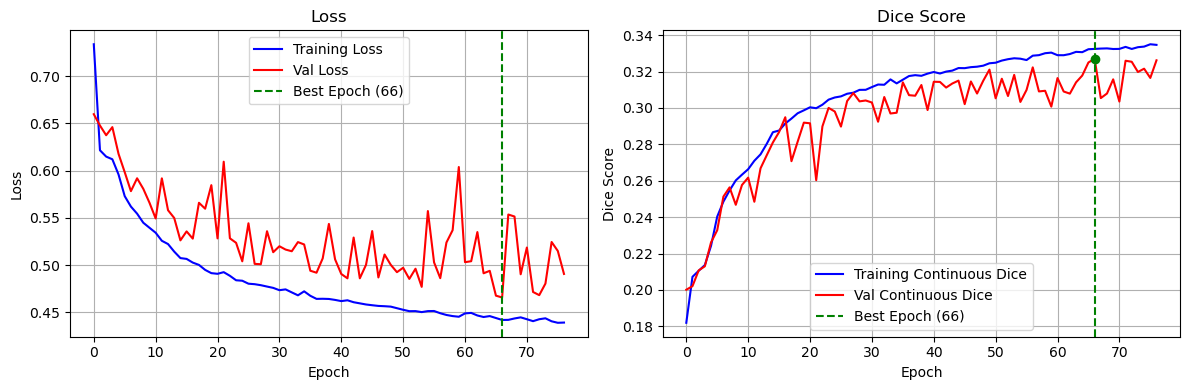

In [ ]:

# Visualizing training history: we are printing Loss vs Epoch on the left and
# Dice Score vs Epoch on the right while marking the best epoch (i.e. the one
# with lowest val loss or highest val dice score)
visualize_training_history(
    history_resNetUNet # Dictionary with train/val loss/score for each epoch
)

Loading the model from state dict if we don't have it as an object (e.g. we just want to test the model we have trained previously). Then we simply evaluate the dice score values for each class by computing mean and standard deviation

In [ ]:
## If you haven't trained the model (or trained it previously) but have the
## state dictionary of the model uncomment the following line to load it
# model.load_state_dict(torch.load('best_model_pannuke.pth'))

# Evaluates the model on the test dataset and computes the mean and standard
# deviation of the per-class Dice Score across all samples.
compute_dice_test(
    resNetUNet,    # trained model
    test_loader,   # dataloader with test data
    device         # device to use (GPU)
)


Testing: 100%|██████████| 86/86 [00:32<00:00,  2.67it/s]

FINAL TEST RESULTS
Class 0 (Background): mean Dice = 0.9633 ± 0.0305
Class 1 (Neoplastic cells): mean Dice = 0.8344 ± 0.2323
Class 2 (Inflammatory): mean Dice = 0.7481 ± 0.3245
Class 3 (Connective/Soft tissue cells): mean Dice = 0.6081 ± 0.3186
Class 4 (Dead Cells): mean Dice = 0.9644 ± 0.1854
Class 5 (Epithelial): mean Dice = 0.9096 ± 0.2192

Mean Dice: 0.8380


 Randomly selects one batch from the test set, runs the model on it, and displays a few samples alongside their ground truth and predictions.



Visualizing 4 predictions from test set


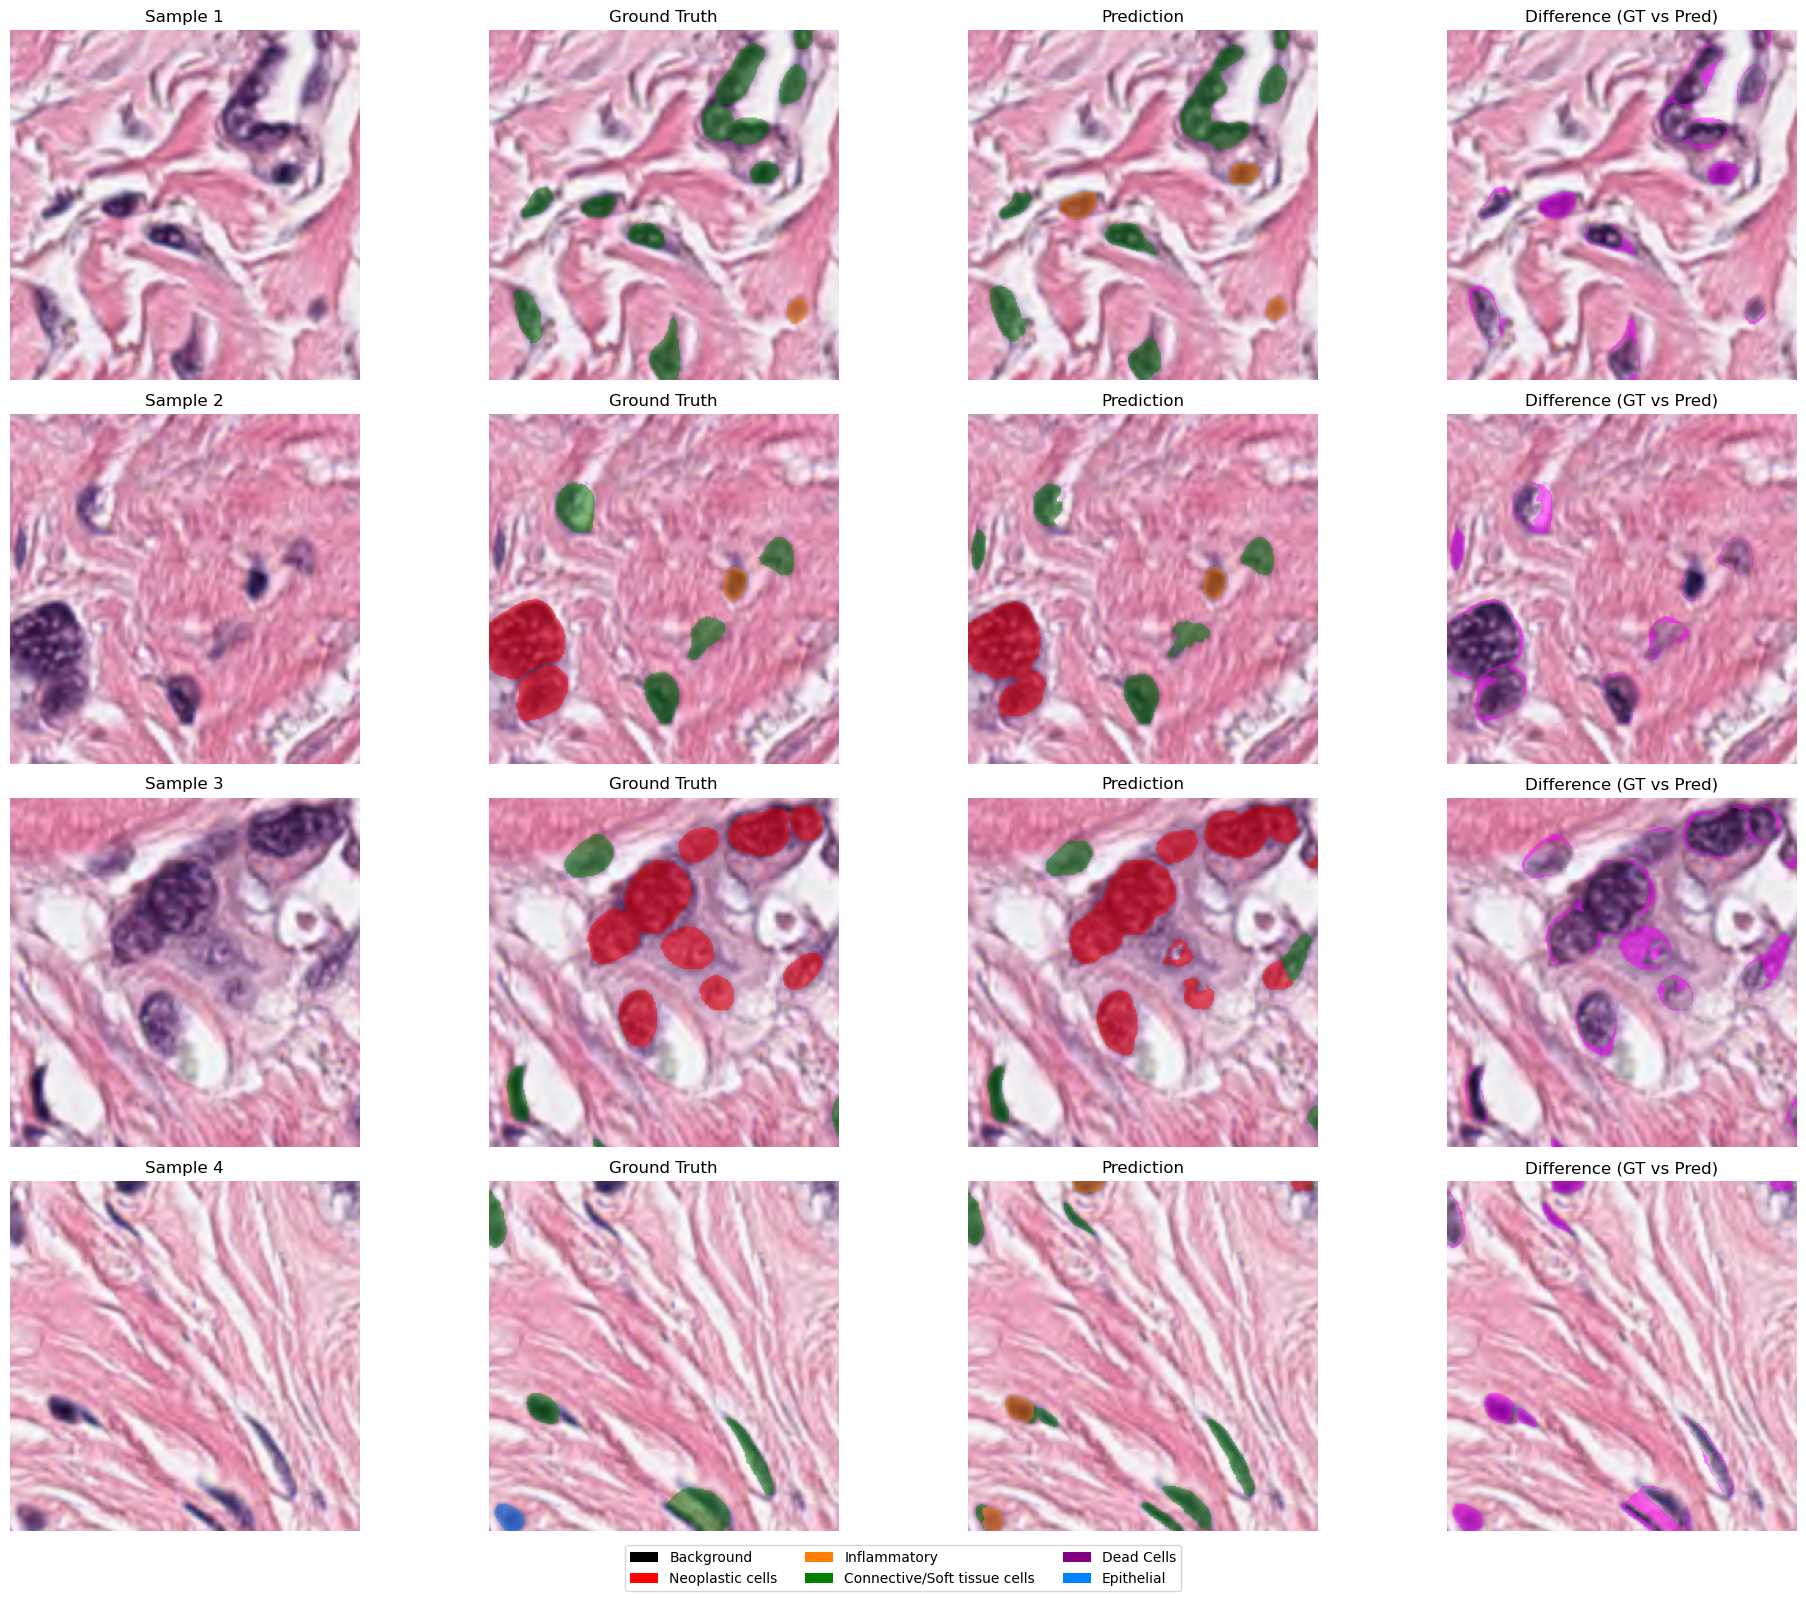

In [ ]:
# Visualizing prediciton (note: this function contains some randomness
# because the index of the batch to be used is decided randomly)
visualize_predictions(
    resNetUNet,     # trained model
    test_loader,    # test dataloader
    device          # device to use (GPU)
)


###  TransUNet Training

This code snippet initiates the execution of the complete training pipeline for the TransUNet model. By passing the global config dictionary, the previously instantiated resNetUNet model, and the respective data loaders for training and validation, the train_model function begins the iterative process of optimization and evaluation. During this execution, the model resides on the specified device (typically a GPU), and the function actively monitors performance to save the best weights and manage the early stopping logic. The resulting history_resNetUNet object captures all loss and Dice metrics across epochs, providing the raw data needed to visualize the model's convergence and learning behavior.

In [ ]:

# Training the TransUNet architecture
history_transUNet = train_model(
    config,        # Global Configuration Dictionary
    transUNet,     # Model to be trained
    train_loader,  # Train dataloader
    val_loader,    # Validation dataloader
    device,        # device on which tensors have to be stored
    'transUNet'    # model name, used when printing information
)



Epoch 1/100


Training Epoch 1: 100%|██████████| 83/83 [00:27<00:00,  3.07it/s, loss=0.6250, dice_loss=0.7930, ce=0.4571]


Epoch 1: train_loss=0.6856, val_loss=0.6580, train_dice=0.1847, val_dice=0.1958
Saved best model (dice: 0.1958)

Epoch 2/100


Training Epoch 2: 100%|██████████| 83/83 [00:27<00:00,  3.07it/s, loss=0.5804, dice_loss=0.7811, ce=0.3796]


Epoch 2: train_loss=0.6135, val_loss=0.6597, train_dice=0.2090, val_dice=0.2156
Saved best model (dice: 0.2156)

Epoch 3/100


Training Epoch 3: 100%|██████████| 83/83 [00:27<00:00,  3.07it/s, loss=0.6750, dice_loss=0.7652, ce=0.5847]


Epoch 3: train_loss=0.5938, val_loss=0.6093, train_dice=0.2242, val_dice=0.2326
Saved best model (dice: 0.2326)

Epoch 4/100


Training Epoch 4: 100%|██████████| 83/83 [00:27<00:00,  3.05it/s, loss=0.5574, dice_loss=0.7597, ce=0.3551]


Epoch 4: train_loss=0.5714, val_loss=0.6145, train_dice=0.2411, val_dice=0.2467
Saved best model (dice: 0.2467)

Epoch 5/100


Training Epoch 5: 100%|██████████| 83/83 [00:27<00:00,  3.06it/s, loss=0.5788, dice_loss=0.7584, ce=0.3991]


Epoch 5: train_loss=0.5572, val_loss=0.5910, train_dice=0.2518, val_dice=0.2518
Saved best model (dice: 0.2518)

Epoch 6/100


Training Epoch 6: 100%|██████████| 83/83 [00:27<00:00,  3.07it/s, loss=0.5531, dice_loss=0.7528, ce=0.3535]


Epoch 6: train_loss=0.5459, val_loss=0.6093, train_dice=0.2578, val_dice=0.2467

Epoch 7/100


Training Epoch 7: 100%|██████████| 83/83 [00:27<00:00,  3.06it/s, loss=0.5641, dice_loss=0.7434, ce=0.3849]


Epoch 7: train_loss=0.5392, val_loss=0.5784, train_dice=0.2620, val_dice=0.2498

Epoch 8/100


Training Epoch 8: 100%|██████████| 83/83 [00:27<00:00,  3.06it/s, loss=0.5546, dice_loss=0.7208, ce=0.3884]


Epoch 8: train_loss=0.5343, val_loss=0.6062, train_dice=0.2637, val_dice=0.2381

Epoch 9/100


Training Epoch 9: 100%|██████████| 83/83 [00:27<00:00,  3.07it/s, loss=0.5045, dice_loss=0.7250, ce=0.2839]


Epoch 9: train_loss=0.5301, val_loss=0.5527, train_dice=0.2664, val_dice=0.2630
Saved best model (dice: 0.2630)

Epoch 10/100


Training Epoch 10: 100%|██████████| 83/83 [00:27<00:00,  3.07it/s, loss=0.5146, dice_loss=0.7151, ce=0.3142]


Epoch 10: train_loss=0.5235, val_loss=0.5549, train_dice=0.2709, val_dice=0.2685
Saved best model (dice: 0.2685)

Epoch 11/100


Training Epoch 11: 100%|██████████| 83/83 [00:27<00:00,  3.04it/s, loss=0.5595, dice_loss=0.7334, ce=0.3856]


Epoch 11: train_loss=0.5195, val_loss=0.5450, train_dice=0.2738, val_dice=0.2698
Saved best model (dice: 0.2698)

Epoch 12/100


Training Epoch 12: 100%|██████████| 83/83 [00:27<00:00,  3.06it/s, loss=0.5233, dice_loss=0.7368, ce=0.3099]


Epoch 12: train_loss=0.5162, val_loss=0.5390, train_dice=0.2770, val_dice=0.2712
Saved best model (dice: 0.2712)

Epoch 13/100


Training Epoch 13: 100%|██████████| 83/83 [00:27<00:00,  3.06it/s, loss=0.4942, dice_loss=0.7086, ce=0.2798]


Epoch 13: train_loss=0.5059, val_loss=0.5473, train_dice=0.2830, val_dice=0.2736
Saved best model (dice: 0.2736)

Epoch 14/100


Training Epoch 14: 100%|██████████| 83/83 [00:27<00:00,  3.06it/s, loss=0.5130, dice_loss=0.7122, ce=0.3138]


Epoch 14: train_loss=0.4984, val_loss=0.5350, train_dice=0.2897, val_dice=0.2800
Saved best model (dice: 0.2800)

Epoch 15/100


Training Epoch 15: 100%|██████████| 83/83 [00:27<00:00,  3.06it/s, loss=0.4862, dice_loss=0.7086, ce=0.2639]


Epoch 15: train_loss=0.4997, val_loss=0.5173, train_dice=0.2898, val_dice=0.2889
Saved best model (dice: 0.2889)

Epoch 16/100


Training Epoch 16: 100%|██████████| 83/83 [00:27<00:00,  3.05it/s, loss=0.4983, dice_loss=0.6927, ce=0.3038]


Epoch 16: train_loss=0.4877, val_loss=0.5168, train_dice=0.2972, val_dice=0.2883

Epoch 17/100


Training Epoch 17: 100%|██████████| 83/83 [00:27<00:00,  3.06it/s, loss=0.5480, dice_loss=0.7219, ce=0.3740]


Epoch 17: train_loss=0.4891, val_loss=0.5318, train_dice=0.2988, val_dice=0.2875

Epoch 18/100


Training Epoch 18: 100%|██████████| 83/83 [00:27<00:00,  3.06it/s, loss=0.4943, dice_loss=0.7000, ce=0.2886]


Epoch 18: train_loss=0.4891, val_loss=0.5330, train_dice=0.2977, val_dice=0.2812

Epoch 19/100


Training Epoch 19: 100%|██████████| 83/83 [00:27<00:00,  3.05it/s, loss=0.5016, dice_loss=0.6957, ce=0.3074]


Epoch 19: train_loss=0.4813, val_loss=0.5193, train_dice=0.3021, val_dice=0.2903
Saved best model (dice: 0.2903)

Epoch 20/100


Training Epoch 20: 100%|██████████| 83/83 [00:27<00:00,  3.06it/s, loss=0.4742, dice_loss=0.7067, ce=0.2416]


Epoch 20: train_loss=0.4772, val_loss=0.5787, train_dice=0.3045, val_dice=0.2713

Epoch 21/100


Training Epoch 21: 100%|██████████| 83/83 [00:27<00:00,  3.06it/s, loss=0.5070, dice_loss=0.7162, ce=0.2977]


Epoch 21: train_loss=0.4803, val_loss=0.5062, train_dice=0.3028, val_dice=0.2980
Saved best model (dice: 0.2980)

Epoch 22/100


Training Epoch 22: 100%|██████████| 83/83 [00:27<00:00,  3.06it/s, loss=0.4583, dice_loss=0.6802, ce=0.2364]


Epoch 22: train_loss=0.4748, val_loss=0.4954, train_dice=0.3068, val_dice=0.3020
Saved best model (dice: 0.3020)

Epoch 23/100


Training Epoch 23: 100%|██████████| 83/83 [00:27<00:00,  3.06it/s, loss=0.4860, dice_loss=0.7026, ce=0.2694]


Epoch 23: train_loss=0.4731, val_loss=0.5008, train_dice=0.3080, val_dice=0.3065
Saved best model (dice: 0.3065)

Epoch 24/100


Training Epoch 24: 100%|██████████| 83/83 [00:27<00:00,  3.06it/s, loss=0.4327, dice_loss=0.6866, ce=0.1789]


Epoch 24: train_loss=0.4716, val_loss=0.5207, train_dice=0.3085, val_dice=0.2935

Epoch 25/100


Training Epoch 25: 100%|██████████| 83/83 [00:27<00:00,  3.05it/s, loss=0.4600, dice_loss=0.6781, ce=0.2419]


Epoch 25: train_loss=0.4690, val_loss=0.4846, train_dice=0.3106, val_dice=0.3094
Saved best model (dice: 0.3094)

Epoch 26/100


Training Epoch 26: 100%|██████████| 83/83 [00:27<00:00,  3.06it/s, loss=0.4530, dice_loss=0.6758, ce=0.2302]


Epoch 26: train_loss=0.4685, val_loss=0.5003, train_dice=0.3108, val_dice=0.3049

Epoch 27/100


Training Epoch 27: 100%|██████████| 83/83 [00:27<00:00,  3.06it/s, loss=0.4973, dice_loss=0.7055, ce=0.2891]


Epoch 27: train_loss=0.4630, val_loss=0.5169, train_dice=0.3135, val_dice=0.2983

Epoch 28/100


Training Epoch 28: 100%|██████████| 83/83 [00:27<00:00,  3.05it/s, loss=0.4595, dice_loss=0.6929, ce=0.2262]


Epoch 28: train_loss=0.4669, val_loss=0.4952, train_dice=0.3125, val_dice=0.3001

Epoch 29/100


Training Epoch 29: 100%|██████████| 83/83 [00:27<00:00,  3.04it/s, loss=0.4725, dice_loss=0.6867, ce=0.2582]


Epoch 29: train_loss=0.4628, val_loss=0.5018, train_dice=0.3135, val_dice=0.3094
Saved best model (dice: 0.3094)

Epoch 30/100


Training Epoch 30: 100%|██████████| 83/83 [00:27<00:00,  3.05it/s, loss=0.4659, dice_loss=0.7013, ce=0.2305]


Epoch 30: train_loss=0.4664, val_loss=0.4907, train_dice=0.3124, val_dice=0.3053

Epoch 31/100


Training Epoch 31: 100%|██████████| 83/83 [00:27<00:00,  3.05it/s, loss=0.4609, dice_loss=0.6794, ce=0.2424]


Epoch 31: train_loss=0.4655, val_loss=0.4929, train_dice=0.3130, val_dice=0.3066

Epoch 32/100


Training Epoch 32: 100%|██████████| 83/83 [00:27<00:00,  3.04it/s, loss=0.4437, dice_loss=0.6759, ce=0.2115]


Epoch 32: train_loss=0.4606, val_loss=0.4876, train_dice=0.3157, val_dice=0.3109
Saved best model (dice: 0.3109)

Epoch 33/100


Training Epoch 33: 100%|██████████| 83/83 [00:27<00:00,  3.06it/s, loss=0.4770, dice_loss=0.6976, ce=0.2564]


Epoch 33: train_loss=0.4623, val_loss=0.4839, train_dice=0.3161, val_dice=0.3114
Saved best model (dice: 0.3114)

Epoch 34/100


Training Epoch 34: 100%|██████████| 83/83 [00:27<00:00,  3.06it/s, loss=0.4597, dice_loss=0.6844, ce=0.2350]


Epoch 34: train_loss=0.4589, val_loss=0.4881, train_dice=0.3176, val_dice=0.3049

Epoch 35/100


Training Epoch 35: 100%|██████████| 83/83 [00:27<00:00,  3.05it/s, loss=0.4480, dice_loss=0.6841, ce=0.2119]


Epoch 35: train_loss=0.4544, val_loss=0.5255, train_dice=0.3196, val_dice=0.2948

Epoch 36/100


Training Epoch 36: 100%|██████████| 83/83 [00:27<00:00,  3.06it/s, loss=0.4398, dice_loss=0.6793, ce=0.2002]


Epoch 36: train_loss=0.4583, val_loss=0.4975, train_dice=0.3173, val_dice=0.3084

Epoch 37/100


Training Epoch 37: 100%|██████████| 83/83 [00:27<00:00,  3.06it/s, loss=0.4589, dice_loss=0.6942, ce=0.2235]


Epoch 37: train_loss=0.4559, val_loss=0.4959, train_dice=0.3192, val_dice=0.3082

Epoch 38/100


Training Epoch 38: 100%|██████████| 83/83 [00:27<00:00,  3.06it/s, loss=0.4576, dice_loss=0.6829, ce=0.2323]


Epoch 38: train_loss=0.4543, val_loss=0.5243, train_dice=0.3198, val_dice=0.3106

Epoch 39/100


Training Epoch 39: 100%|██████████| 83/83 [00:27<00:00,  3.06it/s, loss=0.4779, dice_loss=0.6864, ce=0.2694]


Epoch 39: train_loss=0.4532, val_loss=0.5002, train_dice=0.3209, val_dice=0.3062

Epoch 40/100


Training Epoch 40: 100%|██████████| 83/83 [00:27<00:00,  3.06it/s, loss=0.4382, dice_loss=0.6765, ce=0.1999]


Epoch 40: train_loss=0.4545, val_loss=0.4863, train_dice=0.3199, val_dice=0.3121
Saved best model (dice: 0.3121)

Epoch 41/100


Training Epoch 41: 100%|██████████| 83/83 [00:27<00:00,  3.06it/s, loss=0.4630, dice_loss=0.6741, ce=0.2519]


Epoch 41: train_loss=0.4514, val_loss=0.5169, train_dice=0.3220, val_dice=0.3038

Epoch 42/100


Training Epoch 42: 100%|██████████| 83/83 [00:27<00:00,  3.06it/s, loss=0.4532, dice_loss=0.6751, ce=0.2312]


Epoch 42: train_loss=0.4550, val_loss=0.4823, train_dice=0.3195, val_dice=0.3155
Saved best model (dice: 0.3155)

Epoch 43/100


Training Epoch 43: 100%|██████████| 83/83 [00:27<00:00,  3.07it/s, loss=0.4418, dice_loss=0.6647, ce=0.2188]


Epoch 43: train_loss=0.4488, val_loss=0.4794, train_dice=0.3237, val_dice=0.3164
Saved best model (dice: 0.3164)

Epoch 44/100


Training Epoch 44: 100%|██████████| 83/83 [00:27<00:00,  3.06it/s, loss=0.4519, dice_loss=0.6774, ce=0.2265]


Epoch 44: train_loss=0.4469, val_loss=0.5177, train_dice=0.3243, val_dice=0.2976

Epoch 45/100


Training Epoch 45: 100%|██████████| 83/83 [00:27<00:00,  3.06it/s, loss=0.4326, dice_loss=0.6546, ce=0.2106]


Epoch 45: train_loss=0.4558, val_loss=0.4819, train_dice=0.3207, val_dice=0.3151

Epoch 46/100


Training Epoch 46: 100%|██████████| 83/83 [00:27<00:00,  3.06it/s, loss=0.4587, dice_loss=0.6750, ce=0.2424]


Epoch 46: train_loss=0.4520, val_loss=0.4859, train_dice=0.3224, val_dice=0.3189
Saved best model (dice: 0.3189)

Epoch 47/100


Training Epoch 47: 100%|██████████| 83/83 [00:27<00:00,  3.06it/s, loss=0.4673, dice_loss=0.6825, ce=0.2521]


Epoch 47: train_loss=0.4499, val_loss=0.4970, train_dice=0.3241, val_dice=0.3078

Epoch 48/100


Training Epoch 48: 100%|██████████| 83/83 [00:27<00:00,  3.04it/s, loss=0.4231, dice_loss=0.6718, ce=0.1744]


Epoch 48: train_loss=0.4460, val_loss=0.4825, train_dice=0.3251, val_dice=0.3169

Epoch 49/100


Training Epoch 49: 100%|██████████| 83/83 [00:27<00:00,  3.06it/s, loss=0.4512, dice_loss=0.6826, ce=0.2197]


Epoch 49: train_loss=0.4461, val_loss=0.4934, train_dice=0.3265, val_dice=0.3083

Epoch 50/100


Training Epoch 50: 100%|██████████| 83/83 [00:27<00:00,  3.06it/s, loss=0.4594, dice_loss=0.6841, ce=0.2348]


Epoch 50: train_loss=0.4422, val_loss=0.4963, train_dice=0.3271, val_dice=0.3122

Epoch 51/100


Training Epoch 51: 100%|██████████| 83/83 [00:27<00:00,  3.07it/s, loss=0.4449, dice_loss=0.6724, ce=0.2174]


Epoch 51: train_loss=0.4463, val_loss=0.4794, train_dice=0.3263, val_dice=0.3162

Epoch 52/100


Training Epoch 52: 100%|██████████| 83/83 [00:27<00:00,  3.05it/s, loss=0.4260, dice_loss=0.6695, ce=0.1824]


Epoch 52: train_loss=0.4437, val_loss=0.4976, train_dice=0.3274, val_dice=0.3127

Epoch 53/100


Training Epoch 53: 100%|██████████| 83/83 [00:27<00:00,  3.03it/s, loss=0.4401, dice_loss=0.6722, ce=0.2081]


Epoch 53: train_loss=0.4427, val_loss=0.4755, train_dice=0.3283, val_dice=0.3195
Saved best model (dice: 0.3195)

Epoch 54/100


Training Epoch 54: 100%|██████████| 83/83 [00:27<00:00,  3.07it/s, loss=0.4438, dice_loss=0.6796, ce=0.2079]


Epoch 54: train_loss=0.4381, val_loss=0.4762, train_dice=0.3298, val_dice=0.3235
Saved best model (dice: 0.3235)

Epoch 55/100


Training Epoch 55: 100%|██████████| 83/83 [00:27<00:00,  3.05it/s, loss=0.4477, dice_loss=0.6629, ce=0.2325]


Epoch 55: train_loss=0.4442, val_loss=0.4881, train_dice=0.3269, val_dice=0.3181

Epoch 56/100


Training Epoch 56: 100%|██████████| 83/83 [00:27<00:00,  3.05it/s, loss=0.4279, dice_loss=0.6595, ce=0.1963]


Epoch 56: train_loss=0.4465, val_loss=0.4866, train_dice=0.3266, val_dice=0.3143

Epoch 57/100


Training Epoch 57: 100%|██████████| 83/83 [00:27<00:00,  3.07it/s, loss=0.4505, dice_loss=0.6614, ce=0.2395]


Epoch 57: train_loss=0.4416, val_loss=0.5116, train_dice=0.3292, val_dice=0.3025

Epoch 58/100


Training Epoch 58: 100%|██████████| 83/83 [00:27<00:00,  3.06it/s, loss=0.4495, dice_loss=0.6726, ce=0.2264]


Epoch 58: train_loss=0.4407, val_loss=0.4755, train_dice=0.3291, val_dice=0.3221

Epoch 59/100


Training Epoch 59: 100%|██████████| 83/83 [00:27<00:00,  3.06it/s, loss=0.4625, dice_loss=0.6626, ce=0.2624]


Epoch 59: train_loss=0.4389, val_loss=0.4850, train_dice=0.3307, val_dice=0.3186

Epoch 60/100


Training Epoch 60: 100%|██████████| 83/83 [00:27<00:00,  3.06it/s, loss=0.4384, dice_loss=0.6875, ce=0.1894]


Epoch 60: train_loss=0.4362, val_loss=0.5131, train_dice=0.3315, val_dice=0.3190

Epoch 61/100


Training Epoch 61: 100%|██████████| 83/83 [00:27<00:00,  3.05it/s, loss=0.4536, dice_loss=0.6676, ce=0.2396]


Epoch 61: train_loss=0.4388, val_loss=0.4715, train_dice=0.3310, val_dice=0.3171

Epoch 62/100


Training Epoch 62: 100%|██████████| 83/83 [00:27<00:00,  3.06it/s, loss=0.4623, dice_loss=0.6607, ce=0.2639]


Epoch 62: train_loss=0.4410, val_loss=0.4885, train_dice=0.3295, val_dice=0.3186

Epoch 63/100


Training Epoch 63: 100%|██████████| 83/83 [00:27<00:00,  3.06it/s, loss=0.4359, dice_loss=0.6767, ce=0.1950]


Epoch 63: train_loss=0.4351, val_loss=0.4846, train_dice=0.3321, val_dice=0.3136

Epoch 64/100


Training Epoch 64: 100%|██████████| 83/83 [00:27<00:00,  3.05it/s, loss=0.4280, dice_loss=0.6589, ce=0.1971]


Epoch 64: train_loss=0.4347, val_loss=0.4717, train_dice=0.3330, val_dice=0.3252
Saved best model (dice: 0.3252)

Epoch 65/100


Training Epoch 65: 100%|██████████| 83/83 [00:27<00:00,  3.06it/s, loss=0.4272, dice_loss=0.6587, ce=0.1958]


Epoch 65: train_loss=0.4361, val_loss=0.4739, train_dice=0.3329, val_dice=0.3230

Epoch 66/100


Training Epoch 66: 100%|██████████| 83/83 [00:27<00:00,  3.04it/s, loss=0.4229, dice_loss=0.6615, ce=0.1844]


Epoch 66: train_loss=0.4404, val_loss=0.4816, train_dice=0.3310, val_dice=0.3181

Epoch 67/100


Training Epoch 67: 100%|██████████| 83/83 [00:27<00:00,  3.06it/s, loss=0.4378, dice_loss=0.6821, ce=0.1935]


Epoch 67: train_loss=0.4365, val_loss=0.4705, train_dice=0.3320, val_dice=0.3240

Epoch 68/100


Training Epoch 68: 100%|██████████| 83/83 [00:27<00:00,  3.06it/s, loss=0.4410, dice_loss=0.6557, ce=0.2262]


Epoch 68: train_loss=0.4422, val_loss=0.5083, train_dice=0.3299, val_dice=0.3045

Epoch 69/100


Training Epoch 69: 100%|██████████| 83/83 [00:27<00:00,  3.06it/s, loss=0.4236, dice_loss=0.6552, ce=0.1919]


Epoch 69: train_loss=0.4389, val_loss=0.4758, train_dice=0.3302, val_dice=0.3220

Epoch 70/100


Training Epoch 70: 100%|██████████| 83/83 [00:27<00:00,  3.05it/s, loss=0.4346, dice_loss=0.6588, ce=0.2104]


Epoch 70: train_loss=0.4323, val_loss=0.4568, train_dice=0.3347, val_dice=0.3279
Saved best model (dice: 0.3279)

Epoch 71/100


Training Epoch 71: 100%|██████████| 83/83 [00:27<00:00,  3.06it/s, loss=0.4275, dice_loss=0.6661, ce=0.1888]


Epoch 71: train_loss=0.4339, val_loss=0.4768, train_dice=0.3337, val_dice=0.3205

Epoch 72/100


Training Epoch 72: 100%|██████████| 83/83 [00:27<00:00,  3.05it/s, loss=0.4298, dice_loss=0.6581, ce=0.2014]


Epoch 72: train_loss=0.4313, val_loss=0.4837, train_dice=0.3347, val_dice=0.3257

Epoch 73/100


Training Epoch 73: 100%|██████████| 83/83 [00:27<00:00,  3.06it/s, loss=0.4456, dice_loss=0.6794, ce=0.2118]


Epoch 73: train_loss=0.4691, val_loss=0.4890, train_dice=0.3177, val_dice=0.3080

Epoch 74/100


Training Epoch 74: 100%|██████████| 83/83 [00:27<00:00,  3.06it/s, loss=0.4259, dice_loss=0.6391, ce=0.2127]


Epoch 74: train_loss=0.4404, val_loss=0.4723, train_dice=0.3301, val_dice=0.3239

Epoch 75/100


Training Epoch 75: 100%|██████████| 83/83 [00:27<00:00,  3.04it/s, loss=0.4453, dice_loss=0.6709, ce=0.2197]


Epoch 75: train_loss=0.4403, val_loss=0.4632, train_dice=0.3307, val_dice=0.3257

Epoch 76/100


Training Epoch 76: 100%|██████████| 83/83 [00:27<00:00,  3.06it/s, loss=0.4198, dice_loss=0.6548, ce=0.1848]


Epoch 76: train_loss=0.4348, val_loss=0.4612, train_dice=0.3337, val_dice=0.3248

Epoch 77/100


Training Epoch 77: 100%|██████████| 83/83 [00:27<00:00,  3.06it/s, loss=0.4520, dice_loss=0.6619, ce=0.2422]


Epoch 77: train_loss=0.4345, val_loss=0.4758, train_dice=0.3339, val_dice=0.3246

Epoch 78/100


Training Epoch 78: 100%|██████████| 83/83 [00:27<00:00,  3.05it/s, loss=0.4299, dice_loss=0.6558, ce=0.2040]


Epoch 78: train_loss=0.4352, val_loss=0.4696, train_dice=0.3337, val_dice=0.3237

Epoch 79/100


Training Epoch 79: 100%|██████████| 83/83 [00:27<00:00,  3.06it/s, loss=0.4104, dice_loss=0.6436, ce=0.1773]


Epoch 79: train_loss=0.4301, val_loss=0.4669, train_dice=0.3366, val_dice=0.3293
Saved best model (dice: 0.3293)

Epoch 80/100


Training Epoch 80: 100%|██████████| 83/83 [00:27<00:00,  3.06it/s, loss=0.4302, dice_loss=0.6680, ce=0.1924]


Epoch 80: train_loss=0.4308, val_loss=0.4748, train_dice=0.3367, val_dice=0.3249

Epoch 81/100


Training Epoch 81: 100%|██████████| 83/83 [00:27<00:00,  3.04it/s, loss=0.4209, dice_loss=0.6691, ce=0.1727]


Epoch 81: train_loss=0.4346, val_loss=0.4604, train_dice=0.3351, val_dice=0.3269

Epoch 82/100


Training Epoch 82: 100%|██████████| 83/83 [00:27<00:00,  3.06it/s, loss=0.4255, dice_loss=0.6583, ce=0.1926]


Epoch 82: train_loss=0.4298, val_loss=0.4602, train_dice=0.3362, val_dice=0.3295
Saved best model (dice: 0.3295)

Epoch 83/100


Training Epoch 83: 100%|██████████| 83/83 [00:27<00:00,  3.06it/s, loss=0.4191, dice_loss=0.6714, ce=0.1668]


Epoch 83: train_loss=0.4285, val_loss=0.4691, train_dice=0.3374, val_dice=0.3309
Saved best model (dice: 0.3309)

Epoch 84/100


Training Epoch 84: 100%|██████████| 83/83 [00:27<00:00,  3.06it/s, loss=0.4028, dice_loss=0.6401, ce=0.1655]


Epoch 84: train_loss=0.4319, val_loss=0.4829, train_dice=0.3358, val_dice=0.3222

Epoch 85/100


Training Epoch 85: 100%|██████████| 83/83 [00:27<00:00,  3.06it/s, loss=0.4527, dice_loss=0.6527, ce=0.2527]


Epoch 85: train_loss=0.4313, val_loss=0.4721, train_dice=0.3370, val_dice=0.3236

Epoch 86/100


Training Epoch 86: 100%|██████████| 83/83 [00:27<00:00,  3.04it/s, loss=0.4737, dice_loss=0.6845, ce=0.2629]


Epoch 86: train_loss=0.4333, val_loss=0.4887, train_dice=0.3355, val_dice=0.3164

Epoch 87/100


Training Epoch 87: 100%|██████████| 83/83 [00:27<00:00,  3.06it/s, loss=0.4125, dice_loss=0.6359, ce=0.1891]


Epoch 87: train_loss=0.4290, val_loss=0.4553, train_dice=0.3378, val_dice=0.3293

Epoch 88/100


Training Epoch 88: 100%|██████████| 83/83 [00:27<00:00,  3.06it/s, loss=0.4187, dice_loss=0.6631, ce=0.1744]


Epoch 88: train_loss=0.4276, val_loss=0.4638, train_dice=0.3380, val_dice=0.3263

Epoch 89/100


Training Epoch 89: 100%|██████████| 83/83 [00:27<00:00,  3.05it/s, loss=0.4417, dice_loss=0.6783, ce=0.2052]


Epoch 89: train_loss=0.4279, val_loss=0.4709, train_dice=0.3394, val_dice=0.3220

Epoch 90/100


Training Epoch 90: 100%|██████████| 83/83 [00:27<00:00,  3.05it/s, loss=0.4229, dice_loss=0.6698, ce=0.1761]


Epoch 90: train_loss=0.4293, val_loss=0.4869, train_dice=0.3383, val_dice=0.3186

Epoch 91/100


Training Epoch 91: 100%|██████████| 83/83 [00:27<00:00,  3.07it/s, loss=0.3962, dice_loss=0.6507, ce=0.1416]


Epoch 91: train_loss=0.4233, val_loss=0.4686, train_dice=0.3403, val_dice=0.3263

Epoch 92/100


Training Epoch 92: 100%|██████████| 83/83 [00:27<00:00,  3.06it/s, loss=0.4591, dice_loss=0.6683, ce=0.2500]


Epoch 92: train_loss=0.4234, val_loss=0.4654, train_dice=0.3416, val_dice=0.3282

Epoch 93/100


Training Epoch 93: 100%|██████████| 83/83 [00:27<00:00,  3.05it/s, loss=0.4417, dice_loss=0.6519, ce=0.2315]


Epoch 93: train_loss=0.4262, val_loss=0.4665, train_dice=0.3399, val_dice=0.3308
Early stopping triggered after 93 epochs


In this code block we are simply visualizing some information on training. To be more specific we are plotting (on the left) both the training loss and validation loss for each epoch and we are marking with a vertical dashed line the epoch where the validation loss has the lowest value. On the right we are plotting, instead, the dice score (computed on the training and validation set) with respect to the epoch and, once again, we are marking with a vertical dashed line the epoch with the highest validation dice score

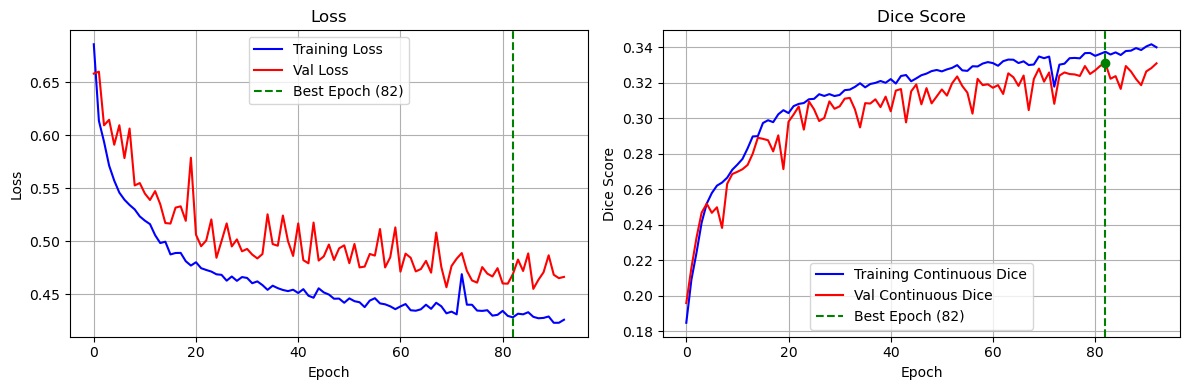

In [ ]:

# Visualizing training history: we are printing Loss vs Epoch on the left and
# Dice Score vs Epoch on the right while marking the best epoch (i.e. the one
# with lowest val loss or highest val dice score)
visualize_training_history(
    history_transUNet # Dictionary with train/val loss/score for each epoch
)


Loading the model from state dict if we don't have it as an object (e.g. we just want to test the model we have trained previously). Then we simply evaluate the dice score values for each class by computing mean and standard deviation

In [ ]:

## If you haven't trained the model (or trained it previously) but have the
## state dictionary of the model uncomment the following line to load it
# model.load_state_dict(torch.load('best_model_pannuke.pth'))

# Evaluates the model on the test dataset and computes the mean and standard
# deviation of the per-class Dice Score across all samples.
compute_dice_test(
    transUNet,     # trained model
    test_loader,   # dataloader with test data
    device         # device to use (GPU)
)

Testing: 100%|██████████| 86/86 [00:13<00:00,  6.61it/s]

FINAL TEST RESULTS
Class 0 (Background): mean Dice = 0.9590 ± 0.0693
Class 1 (Neoplastic cells): mean Dice = 0.8389 ± 0.2290
Class 2 (Inflammatory): mean Dice = 0.7565 ± 0.3132
Class 3 (Connective/Soft tissue cells): mean Dice = 0.5808 ± 0.3297
Class 4 (Dead Cells): mean Dice = 0.9644 ± 0.1854
Class 5 (Epithelial): mean Dice = 0.9389 ± 0.1690

Mean Dice: 0.8398


 Randomly selects one batch from the test set, runs the model on it, and displays a few samples alongside their ground truth and predictions.


Visualizing 4 predictions from test set


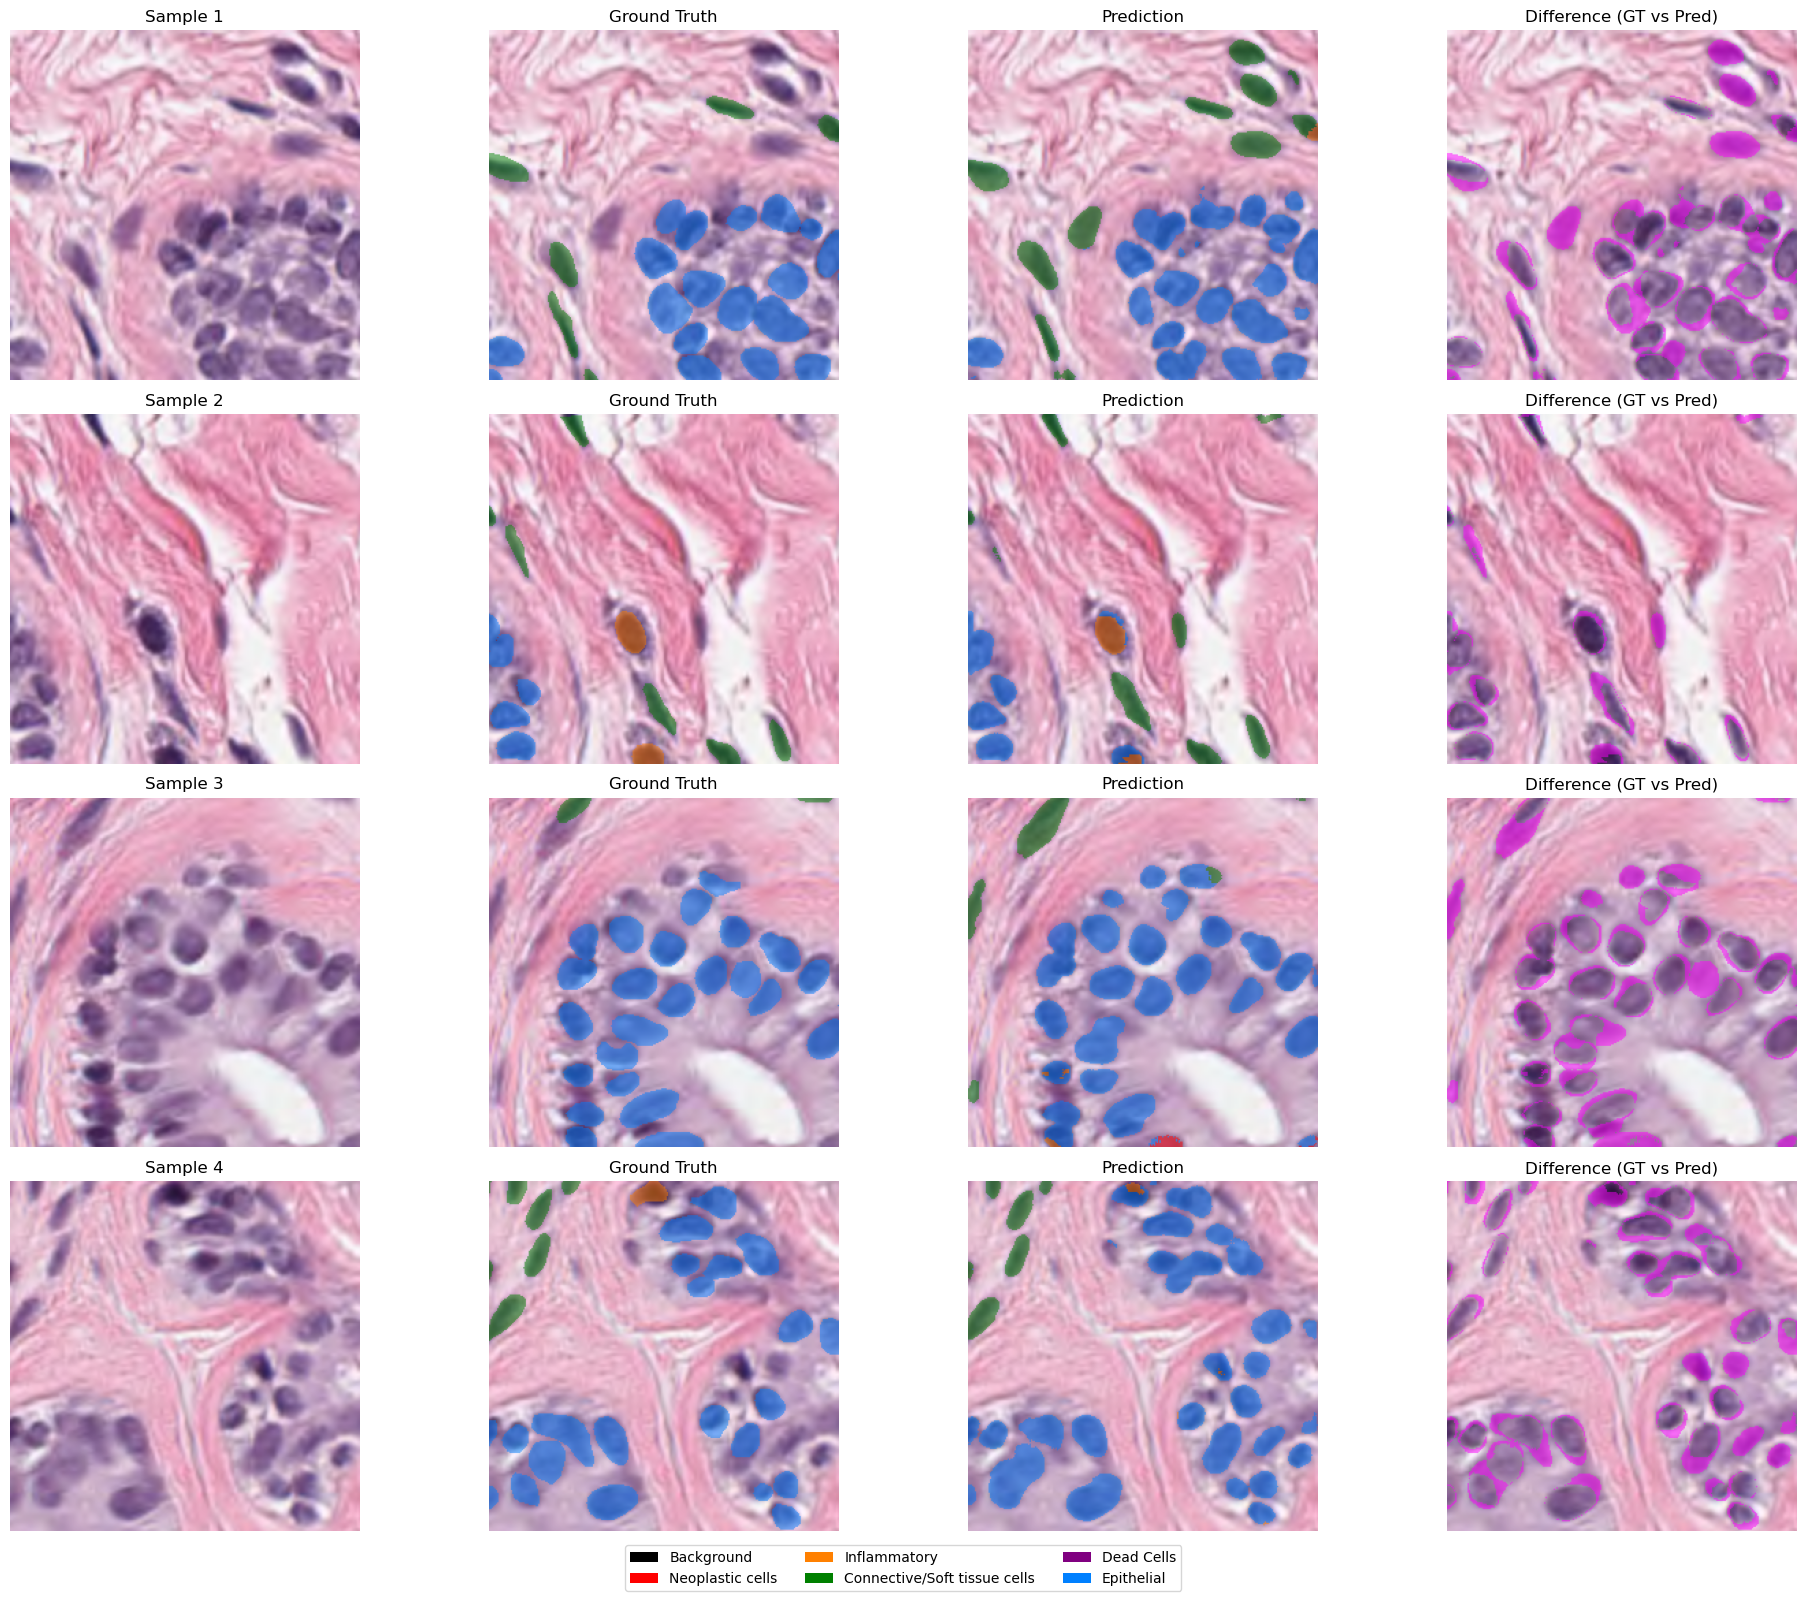

In [ ]:
# Visualizing prediciton (note: this function contains some randomness
# because the index of the batch to be used is decided randomly)
visualize_predictions(
    transUNet,      # trained model
    test_loader,    # test dataloader
    device          # device to use (GPU)
)

# Model Comparison

I have used this code to perform a direct comparative analysis between the TransUNet and ResNetUNet architectures by plotting their performance metrics side-by-side. By utilizing plt.subplots(1, 2), I can simultaneously evaluate the convergence behavior in terms of Loss and the actual segmentation quality via the Dice Score. The use of distinct colors (blue for TransUNet and red for ResNetUNet) combined with different line styles, solid for training and dashed for validation, makes it easy to identify key training dynamics, such as which model converges faster or if either architecture is prone to overfitting. This visualization is essential for making an informed decision on which model performs better for this specific segmentation task, as it highlights the stability and generalization capabilities of both networks across all epochs.

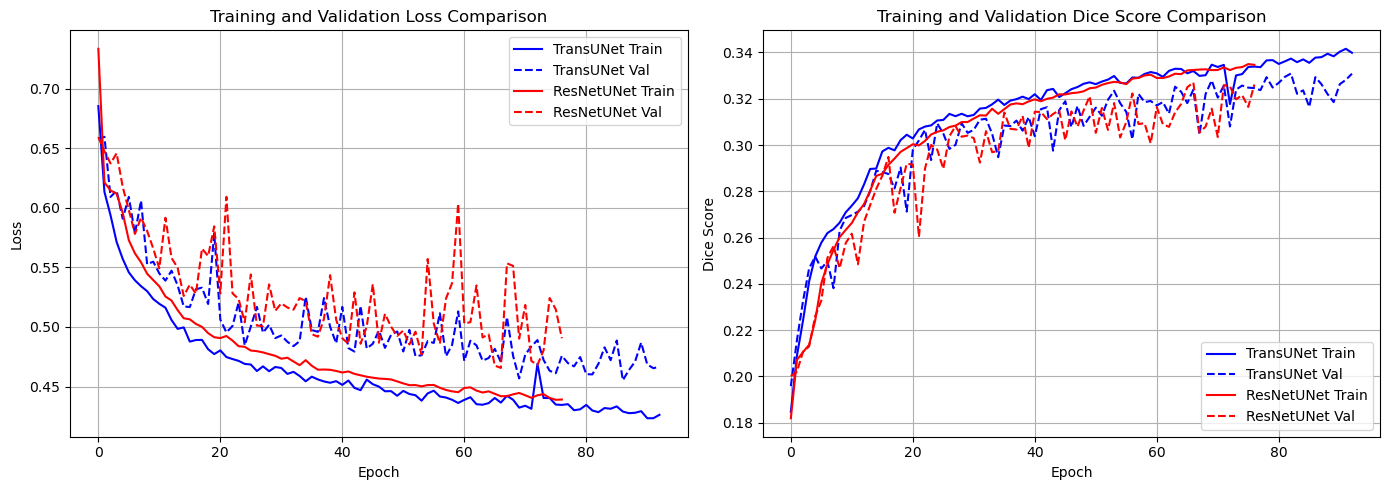

In [ ]:

# Create a figure with two subplots (1 row, 2 columns) to compare metrics side-by-side.
# figsize=(14, 5) ensures the plots are wide enough to see training trends clearly.
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plotting training and validation loss for both the TransUNet and ResNetUNet models.
# Solid lines ('-') are used for Training; Dashed lines ('--') for Validation.
axes[0].plot(history_transUNet['train_loss'], label='TransUNet Train', color='blue')
axes[0].plot(history_transUNet['val_loss'], label='TransUNet Val', color='blue', linestyle='--')

axes[0].plot(history_resNetUNet['train_loss'], label='ResNetUNet Train', color='red')
axes[0].plot(history_resNetUNet['val_loss'], label='ResNetUNet Val', color='red', linestyle='--')

# Setting labels and title for the loss axis
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss Comparison')
axes[0].legend()  # Display the legend to identify which line is which
axes[0].grid(True) # Add a grid for better readability of values

# Plotting the Dice Score (accuracy/overlap metric) for both models.
# This allows us to see which architecture achieves better segmentation performance over time.
axes[1].plot(history_transUNet['train_dice'], label='TransUNet Train', color='blue')
axes[1].plot(history_transUNet['val_dice'], label='TransUNet Val', color='blue', linestyle='--')

axes[1].plot(history_resNetUNet['train_dice'], label='ResNetUNet Train', color='red')
axes[1].plot(history_resNetUNet['val_dice'], label='ResNetUNet Val', color='red', linestyle='--')

# Setting labels and title for the Dice Score axis
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Dice Score')
axes[1].set_title('Training and Validation Dice Score Comparison')
axes[1].legend()
axes[1].grid(True)

# Final Display
# tight_layout() automatically adjusts subplot params so that the subplots fit in the figure area.
plt.tight_layout()
plt.show()


## Side-by-Side Prediction Comparison

This block of code implements a class-aware sampling strategy for visual verification, ensuring that the qualitative analysis covers all target nuclei types rather than relying on generic random selection. I achieve this by scanning a subset of the test data to build a dictionary of "candidates" for each specific class, then randomly selecting one representative sample per category to create a balanced visualization grid. To optimize performance, I perform a single batch inference pass for both the ResNetUNet and TransUNet models simultaneously. The final output is a structured multi-column plot that displays the raw image, the ground truth, and the predictions from both architectures side-by-side. By including per-sample Mean Dice scores and overlaying colored masks on the original textures, I can immediately identify which architecture better preserves the morphology of specific nuclei classes, providing a clear visual bridge between numerical metrics and real-world segmentation accuracy.

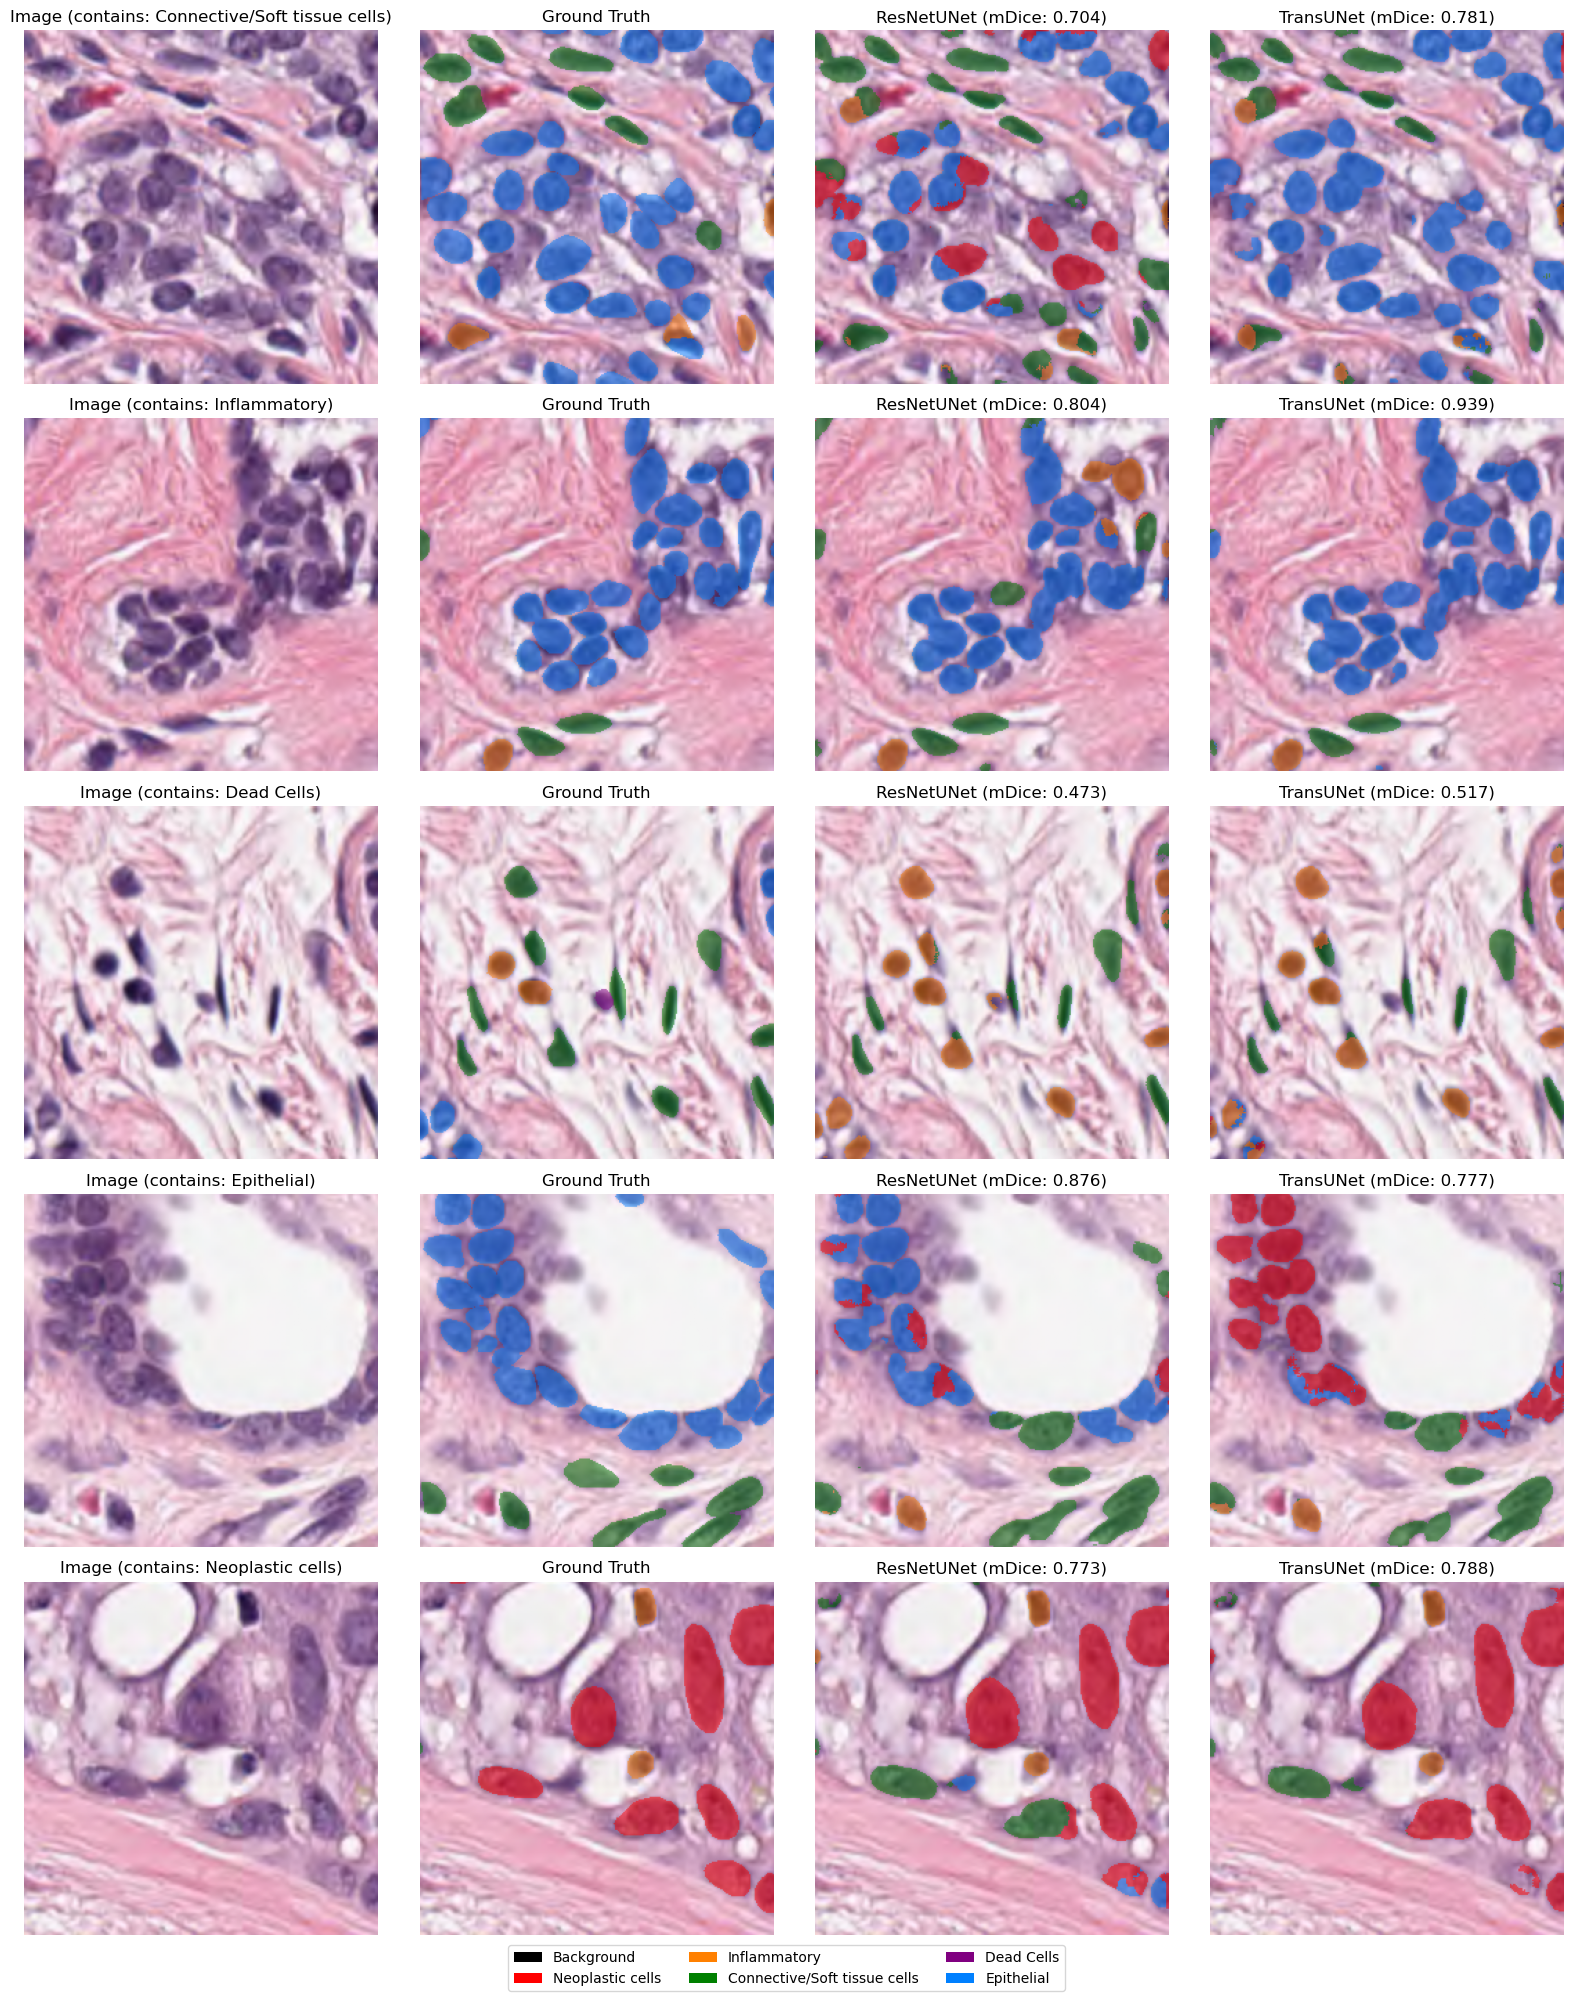

In [ ]:

# Advanced Visualization with Class-Specific Sampling
# This block ensures that we don't just pick random images, but specifically
# pick one random image for every target nuclei class to ensure full visual coverage.

if len(test_loader) > 0:

    # Preparation
    resNetUNet.eval()
    transUNet.eval()
    target_classes = [1, 2, 3, 4, 5]  # The specific nuclei types we want to see

    # Storage for potential candidates: class_id -> list of (image, ground_truth)
    candidates = {c: [] for c in target_classes}
    max_batches_to_scan = min(10, len(test_loader))  # Limit scan to 10 batches for speed

    # Candidate Collection Phase
    # We scan the test set to find images that contain at least one pixel of our target classes.
    with torch.no_grad():
        for bi, batch in enumerate(tqdm(test_loader, desc="Collecting candidates")):
            images_cpu = batch['image']
            labels_cpu = batch['label']

            # Check every individual sample in the batch
            for i in range(images_cpu.size(0)):

                # Identify which classes are present in this specific mask
                # and store them in a set for fast membership check
                gt_i = labels_cpu[i]
                present = set(torch.unique(gt_i).tolist())

                # For each class in the image append image to that class list
                for c in target_classes:
                    if c in present:
                        candidates[c].append((images_cpu[i], gt_i))

            # Stop early if we have found at least one candidate for every class
            # or we have reached the max number of batches to be scanned
            if bi + 1 >= max_batches_to_scan and all(len(candidates[c]) > 0 for c in target_classes):
                break

    # Random Selection
    # Pick exactly one random sample for each class discovered
    selected = {}
    for c in target_classes:
        if len(candidates[c]) > 0:
            idx = random.randrange(len(candidates[c]))
            selected[c] = candidates[c][idx]

    if len(selected) == 0:
        print("No qualifying samples found in test set.")
    else:
        # Shuffle the class order for the final plot display
        ordered = list(selected.keys())
        random.shuffle(ordered)

        # Batch Inference
        # For efficiency, we stack the selected images and run them through the models in one go
        imgs_stack = torch.stack([selected[c][0] for c in ordered]).to(device)
        with torch.no_grad():
            # Get logits from both models
            outs1 = resNetUNet(imgs_stack)
            outs2 = transUNet(imgs_stack)
            # Convert logits to class predictions (B, H, W)
            preds1 = torch.argmax(outs1, dim=1).cpu()
            preds2 = torch.argmax(outs2, dim=1).cpu()

        # Plotting Construction
        num_viz = len(ordered)

        # Create a grid:
        # Rows = Samples,
        # Columns = [Image, GT, ResNet Prediction, TransUNet Prediction]
        fig, axes = plt.subplots(num_viz, 4, figsize=(16, 4 * num_viz))

        # Ensure axes is always a 2D array even if we only have 1 row
        if num_viz == 1:
            axes = axes.reshape(1, -1)

        for row, c in enumerate(ordered):

            # Selecting images, ground truth mask, ResNetUNet predictions,
            # TransUNet prediction and converting them to numpy array
            img = selected[c][0].numpy()
            gt_np = selected[c][1].numpy().astype(np.int32)
            p1_np = preds1[row].numpy().astype(np.int32)
            p2_np = preds2[row].numpy().astype(np.int32)

            # Column 0: Original Image
            axes[row, 0].imshow(img.transpose(1, 2, 0))
            axes[row, 0].set_title(f"Image (contains: {CLASS_NAMES.get(c, str(c))})")
            axes[row, 0].axis('off')

            # Column 1: Ground Truth Mask Overlay
            gt_overlay = overlay_mask_on_image(img, gt_np, alpha=0.5, background_class=0)
            axes[row, 1].imshow(gt_overlay)
            axes[row, 1].set_title('Ground Truth')
            axes[row, 1].axis('off')

            # Column 2: ResNetUNet Prediction Overlay + Dice Score
            p1_overlay = overlay_mask_on_image(img, p1_np, alpha=0.5, background_class=0)
            dice1 = np.mean(compute_dice_score(p1_np, gt_np, config["num_classes"]))
            axes[row, 2].imshow(p1_overlay)
            axes[row, 2].set_title(f'ResNetUNet (mDice: {dice1:.3f})')
            axes[row, 2].axis('off')

            # Column 3: TransUNet Prediction Overlay + Dice Score
            p2_overlay = overlay_mask_on_image(img, p2_np, alpha=0.5, background_class=0)
            dice2 = np.mean(compute_dice_score(p2_np, gt_np, config["num_classes"]))
            axes[row, 3].imshow(p2_overlay)
            axes[row, 3].set_title(f'TransUNet (mDice: {dice2:.3f})')
            axes[row, 3].axis('off')

        # Final Formatting
        # Add a unified color legend at the bottom for the different nuclei classes
        legend_elements = create_legend()
        fig.legend(handles=legend_elements, loc='lower center', ncol=3, fontsize=10)

        plt.tight_layout()
        plt.subplots_adjust(bottom=0.03) # Leave space for the legend
        plt.show()



## Statistical Comparison

This block of code performs a formal statistical comparison between the ResNetUNet and TransUNet models, moving beyond simple average metrics to ensure the observed differences are scientifically valid. By collecting per-batch Dice scores, computing the mean, adding it to a sample and applying a Paired T-Test, I can calculate a p-value that determines if one model's superiority is statistically significant or merely due to random chance. To support these findings visually, I utilized plt.subplots to generate a boxplot that highlights the variance and outliers in model performance, alongside a histogram of differences. The histogram is particularly useful as it shows the distribution of gains or losses when switching from one architecture to the other, with a vertical line at zero clearly indicating which model "won" more frequently. This approach provides a rigorous foundation for concluding which architecture is more reliable for the specific nuclei segmentation task.

Computing scores for statistical test: 100%|██████████| 86/86 [00:31<00:00,  2.69it/s]



ResNetUNet  - Mean Dice: 0.8380 ± 0.1048
TransUNet   - Mean Dice: 0.8398 ± 0.1041

Difference  - Mean: 0.0018

T-statistic: 1.8225
P-value:     0.068491

Result: No significant difference (p >= 0.05)


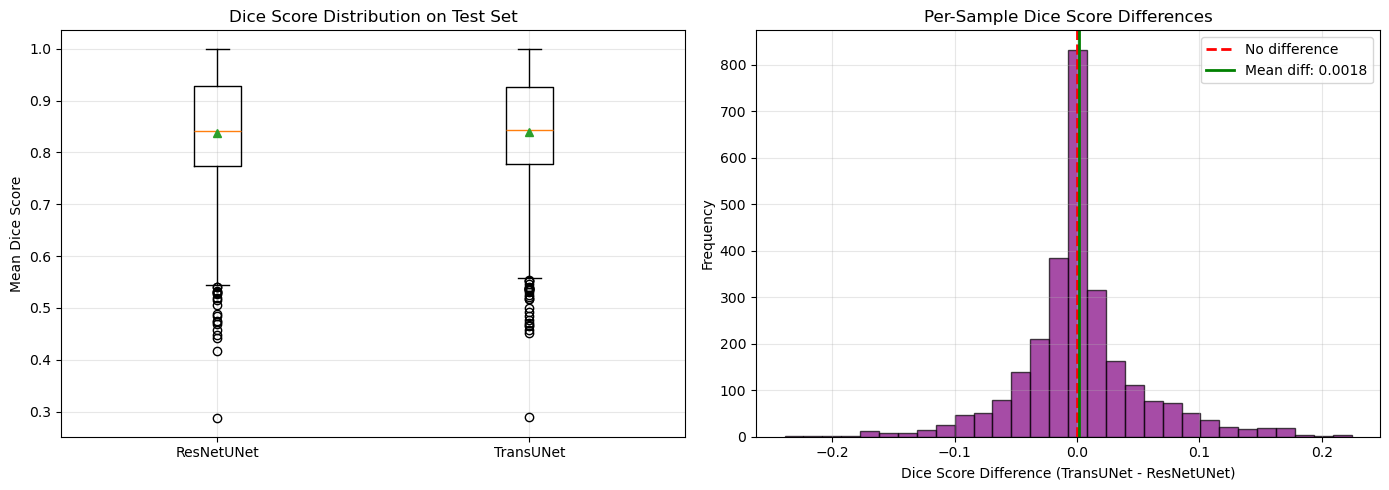

In [ ]:
# This block performs a rigorous statistical evaluation to determine if one
# architecture significantly outperforms the other.

# Set both models to evaluation mode
resNetUNet.eval()
transUNet.eval()

# Lists to store the average Dice score for every single image in the test set
resnet_scores = []
transunet_scores = []

# For efficiency and memory purposes we do not compute gradients
with torch.no_grad():

    # Iterate through the test set to collect predictions from both models
    for batch in tqdm(test_loader, desc="Computing scores for statistical test"):
        images = batch['image'].to(device)
        labels = batch['label']

        # Forward pass for ResNet-based U-Net
        outputs1 = resNetUNet(images)
        preds1 = torch.argmax(outputs1, dim=1).cpu()

        # Forward pass for Transformer-based U-Net
        outputs2 = transUNet(images)
        preds2 = torch.argmax(outputs2, dim=1).cpu()

        # Per-Sample Metric Calculation
        # We calculate the mean Dice score across all classes for each individual sample
        for pred1, pred2, gt in zip(preds1, preds2, labels):

            # compute_dice_score returns a list of scores (one per class)
            dice1 = compute_dice_score(pred1.numpy(), gt.numpy(), config["num_classes"])
            dice2 = compute_dice_score(pred2.numpy(), gt.numpy(), config["num_classes"])

            # Append the mean score of the sample to our tracking lists
            resnet_scores.append(np.mean(dice1))
            transunet_scores.append(np.mean(dice2))

# Convert lists to NumPy arrays for statistical processing
resnet_scores = np.array(resnet_scores)
transunet_scores = np.array(transunet_scores)

# Paired T-Test
# Since both models were tested on the exact same images, we use a 'Paired' T-Test.
# This tests the null hypothesis that the two models have identical performance.
t_statistic, p_value = stats.ttest_rel(transunet_scores, resnet_scores)

# 4. Results Display
print(f"\nResNetUNet  - Mean Dice: {resnet_scores.mean():.4f} ± {resnet_scores.std():.4f}")
print(f"TransUNet   - Mean Dice: {transunet_scores.mean():.4f} ± {transunet_scores.std():.4f}")
print(f"\nDifference  - Mean: {(transunet_scores - resnet_scores).mean():.4f}")
print(f"\nT-statistic: {t_statistic:.4f}")
print(f"P-value:     {p_value:.6f}")

# Interpretation of the P-value (Standard alpha threshold = 0.05)
if p_value < 0.05:
    print(f"\nResult: Significant difference (p < 0.05) *")
else:
    print(f"\nResult: No significant difference (p >= 0.05)")

# Visualization of Distributions
# Create subplots: Boxplot for spread comparison, Histogram for difference distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left Plot: Box Plot
# Shows the median, quartiles, and outliers for both models
axes[0].boxplot(
    [resnet_scores, transunet_scores],
    tick_labels=['ResNetUNet', 'TransUNet'],
    showmeans=True    # Green triangle indicates the mean
)
axes[0].set_ylabel('Mean Dice Score')
axes[0].set_title('Dice Score Distribution on Test Set')
axes[0].grid(True, alpha=0.3)

# Right Plot: Histogram of Differences
# This visualizes how much better (or worse) TransUNet is compared to ResNetUNet per sample.
differences = transunet_scores - resnet_scores
axes[1].hist(differences, bins=30, alpha=0.7, color='purple', edgecolor='black')

# Add a reference line at 0 (meaning zero difference between models)
axes[1].axvline(0, color='red', linestyle='--', linewidth=2, label='No difference')
# Add a reference line for the actual average difference
axes[1].axvline(differences.mean(), color='green', linestyle='-', linewidth=2,
                label=f'Mean diff: {differences.mean():.4f}')

axes[1].set_xlabel('Dice Score Difference (TransUNet - ResNetUNet)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Per-Sample Dice Score Differences')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# TODO: puo' aver senso fare anche un t-test separato per ogni classe
# cosi' magari vediamo che transNet e' piu' bravo a detectare classe X
# mentre resNetUNet e' piu' bravo per classe Y
